## モジュールのインポート

In [1]:
# -*- coding: UTF-8 -*-

import cv2
import os
from moviepy.editor import *
import json
import PIL
#import tqdm
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import glob
import random
import math
import numpy as np
import scipy.ndimage
import copy
import pandas as pd
import matplotlib.pyplot as plt
import sys
import matplotlib.gridspec as gridspec
import seaborn as sns
from PIL import Image
import mpl_toolkits.axes_grid1

server_data = '/Volumes/Drosophila2/Data'
local_data = '/Users/hiroki/Desktop/study/code/data'

datasets = {
        'mating'    : 'TsukubaRIKEN/mating_movie',
        'smile1'    : 'TsukubaRIKEN/seong09-191214-w1118EclosedFemale-smile-24h',
        'smile2'    : 'TsukubaRIKEN/seong09-191214-w1118EclosedMale-smile-24h',
        'w1118_1'   : 'TsukubaRIKEN/seong09-200429.w1118.M.ST',
        'w1118_2'   : 'TsukubaRIKEN/seong07-200422-w1118.F.ST',
        'w1118_3'   : 'TsukubaRIKEN/seong08-200429-w1118.ST.all-free',
        'OrR_1'     : 'TsukubaRIKEN/seong05-200514-OrR.M.ST',
        'OrR_2'     : 'TsukubaRIKEN/seong06-200514-OrR.F.ST',
        'OrR_3'     : 'TsukubaRIKEN/seong08-200514-0rR.ST.all-free',
        'CS_1'      : 'TsukubaRIKEN/seong09-200513.CS.M.ST',
        'CS_2'      : 'TsukubaRIKEN/seong10-20513CS.F.ST',
        'CS_3'      : 'TsukubaRIKEN/seong07-200513-CS.free.ST'
        }

mating_mv = [
        'vi_0033_20190424_133130',
        'vi_0034_20190425_013130',
        'vi_0035_20190425_133130',
        'vi_0036_20190426_013130',
        'vi_0037_20190426_133131',
        'vi_0038_20190427_013131',
        'vi_0039_20190427_133131',
        ]

smile1_mv = [
            'seong09-191214-w1118EclosedFemale-smile-24h',
            'seong09-191214-w1118EclosedFemale-smile-empty',
            'seong09-191214-w1118EclosedFemale-smile-empty2'
            ]

smile2_mv = [
            'seong09-191214-w1118EclosedMale-smile-24h',
            'seong09-191214-w1118EclosedMale-smile-empty1',
            'seong09-191214-w1118EclosedMale-smile-empty2'
            ]

w1118_1_mv = [
            'vi_0000_20200429_104213-back',
            'vi_0001_20200429_112841',
            'vi_0002_20200430_112841',
            'vi_0003_20200501_112841'
            ]

w1118_2_mv = [
            'seong07-200422-w1118.F.ST-back',
            'vi_0001_20200429_110751',
            'vi_0002_20200430_110751',
            'vi_0003_20200501_110751'
            ]

w1118_3_mv = [
            'vi_0001_20200429_094729',
            'vi_0002_20200429_104150',
            'vi_0003_20200430_104150',
            'vi_0004_20200501_104150'
            ]

OrR_1_mv = [
            'vi_0099_20200514_152926',
            'vi_0102_20200514_224210',
            'vi_0103_20200515_224210'
            ]

OrR_2_mv = [
            'vi_0110_20200514_152929(1)',
            'vi_0113_20200514_224230(1)',
            'vi_0114_20200515_224230'
            ]

OrR_3_mv = [
            'vi_0011_20200514_153005 (2)',
            'vi_0013_20200514_224247',
            'vi_0014_20200515_224247'
            ]

CS_1_mv =  [
            'vi_0014_20200513_182108 (1)',
            'vi_0015_20200513_193414 (1)',
            'vi_0016_20200514_193414'
            ]

CS_2_mv =  [
            'vi_0006_20200513_182208 (2)',
            'vi_0007_20200513_193827 (1)',
            'vi_0008_20200514_193827'
            ]

CS_3_mv =  [
            'vi_0016_20200513_182125 (1)',
            'vi_0017_20200513_194218 (1)',
            'vi_0018_20200514_194219'
            ]

movies = {
        'mating'    : mating_mv ,
        'smile1'    : smile1_mv ,
        'smile2'    : smile2_mv ,
        'w1118_1'   : w1118_1_mv,
        'w1118_2'   : w1118_2_mv,
        'w1118_3'   : w1118_3_mv,
        'OrR_1'     : OrR_1_mv  ,
        'OrR_2'     : OrR_2_mv  ,
        'OrR_3'     : OrR_3_mv  ,
        'CS_1'      : CS_1_mv   ,
        'CS_2'      : CS_2_mv   ,
        'CS_3'      : CS_3_mv   ,
        }

# 1:Male,2:Female,3:free

targets = [
            #'smile1',
            #'smile2',
            #'w1118_1',
            #'w1118_2',
            #'w1118_3',
            'OrR_1',
            #'OrR_2',
            'OrR_3',
            #'CS_1',
            #'CS_2',
            #'CS_3'
            ]


動画→画像（mask作成用なので１フレームのみ）

In [2]:
for target in tqdm(targets):
    k = 0
    data_dir = datasets[target]
    orgmv_paths = glob.glob(os.path.join(server_data, data_dir, '*.mp4'))

    for orgmv_path in tqdm(orgmv_paths):
        cap = cv2.VideoCapture(orgmv_path)

        save_dir = os.path.join(local_data,data_dir,'original')
        os.makedirs(save_dir, exist_ok=True)

        for i in tqdm(range(1)):
            cap.set(cv2.CAP_PROP_POS_FRAMES,i)
            ret, frame = cap.read()
            if ret:
                frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                cv2.imwrite('{}/{:05}.png'.format(save_dir,k), frame_gray)
                k += 1
            else:
                break

動画のトリミング

In [ ]:
for target in tqdm(targets):
    data_dir = datasets[target]
    with open(os.path.join(server_data, data_dir, 'mask_params.json')) as f:
        params = json.load(f)

    i = params['n-rows']
    j = params['n-clms']
    xlen = params['well-w']
    ylen = params['well-h']
    X = params['x']
    Y = params['y']

    for p in tqdm(range(len(movies[target]))):
        tar_mv = movies[target][p]

        file_path = os.path.join('{}/{}/{}.mp4'.format(server_data,data_dir,tar_mv)) #トリミングしたい動画のパス
        
        movie = cv2.VideoCapture(file_path)
        h = int(movie.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(movie.get(cv2.CAP_PROP_FPS))

        Y1 = h - Y - (ylen*(j-1))

        X_start= X #切り出しのスタートｘ座標

        Y_start = Y1 #切り出しのスタートy座標

        X_length = X + xlen #X_startからの切り出す長さ

        Y_length = Y1 + ylen #Y_startからの切り出す長さ

        save_dir = os.path.join(server_data, data_dir, 'trim_movie', tar_mv) #保存先のディレクトリ（for watch）
        #save_dir = os.path.join(server_data, data_dir, 'trim_mv4ed', tar_mv) #保存先のディレクトリ(for edit)

        os.makedirs(save_dir, exist_ok=True)

        for n in range(i):
            for m in range(j):
                k = m + (n * j)
                save_path = os.path.join('{}/well{:03}.mp4'.format(save_dir,k)) #保存先のパス

                X_start= X + xlen * m #切り出しのスタートｘ座標

                Y_start = Y1 + ylen * n #切り出しのスタートy座標

                X_length = X + xlen * (m+1) #X_startからの切り出す長さ

                Y_length = Y1 + ylen * (n+1) #Y_startからの切り出す長さ

                video = (VideoFileClip(file_path).crop(x1=X_start,y1=Y_start,x2=X_length,y2=Y_length))#トリミング実行

                video.write_videofile(save_path,fps=fps) #保存(for edit)

# Release everything if job is finished
movie.release()

切り出し動画の確認

In [8]:
for target in tqdm(targets):
    data_dir = datasets[target]
    with open(os.path.join(server_data, data_dir, 'mask_params.json')) as f:
        params = json.load(f)

    i = params['n-rows']
    j = params['n-clms']
    xlen = params['well-w']
    ylen = params['well-h']
    X = params['x']
    Y = params['y']

    tar_mv = movies[target][1]

    file_path = os.path.join(server_data, data_dir, 'trim_movie', tar_mv, 'well000.mp4')

    movie = cv2.VideoCapture(file_path)
    print('fps =',int(movie.get(cv2.CAP_PROP_FPS)))                         # 動画のFPSを取得
    print('w =',int(movie.get(cv2.CAP_PROP_FRAME_WIDTH)))                   # 動画の横幅を取得
    print('h =',int(movie.get(cv2.CAP_PROP_FRAME_HEIGHT)))                  # 動画の縦幅を取得
    print('mv_frame =',int(movie.get(cv2.CAP_PROP_FRAME_COUNT)))              # 動画の総フレーム数を取得
# Release everything if job is finished
movie.release()

fps = 3
w = 210
h = 210
mv_frame = 259278



注目個体の抽出

In [2]:
# 背景用動画未使用
# For Tracking Drosophila

for target in tqdm(targets):
    data_dir = datasets[target]
    with open(os.path.join(server_data, data_dir, 'mask_params.json')) as f:
        params = json.load(f)
    
    i = params['n-rows']
    j = params['n-clms']
    xlen = params['well-w']
    ylen = params['well-h']
    X = params['x']
    Y = params['y']
    
    mv_num = len(movies[target])
    #mv_num = 2
    
    M = i*j
    #M = 1

    for m in tqdm(range(M)):
        
        for num in tqdm(range(1, mv_num)):

            tar_mv = movies[target][num]
            # save_path = os.path.join(server_data, data_dir, 'trim_movie/tracking/MOG2', tar_mv )
            save_path = os.path.join(local_data, data_dir, 'trim_movie/tracking/MOG2', tar_mv )

            os.makedirs(save_path, exist_ok=True)

            tar_path = os.path.join('{}/{}/trim_movie/{}/well{:03}.mp4'.format(server_data, data_dir, tar_mv, m))

            mv_save = os.path.join('{}/tr_well{:03}.mp4'.format(save_path, m))

            # 前景用動画読み込みの設定
            movie = cv2.VideoCapture(tar_path)

            # 動画ファイル保存用の設定
            fps = int(movie.get(cv2.CAP_PROP_FPS))                         # 動画のFPSを取得
            w = int(movie.get(cv2.CAP_PROP_FRAME_WIDTH))                   # 動画の横幅を取得
            h = int(movie.get(cv2.CAP_PROP_FRAME_HEIGHT))                  # 動画の縦幅を取得
            fourcc = cv2.VideoWriter_fourcc('m','p','4','v')            # 動画保存時のfourcc設定（mp4用）
            video = cv2.VideoWriter(mv_save, fourcc, fps, (w, h), False) # 動画の仕様（ファイル名、fourcc,FPS,サイズ）

            # 背景差分の設定
            #fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()              # 背景オブジェクトを作成
            fgbg = cv2.createBackgroundSubtractorMOG2()              # 背景オブジェクトを作成
            #fgbg = cv2.bgsegm.createBackgroundSubtractorGMG()              # 背景オブジェクトを作成

            # ファイルからフレームを1枚ずつ取得して動画処理後に保存する
            while True:
                ret, frame = movie.read()  #前景フレームを取得
                fgmask = fgbg.apply(frame)  #前景領域
                video.write(fgmask)	  #動画を保存する

                # フレームが取得できない場合はループを抜ける
                if not ret:
                    break

# 撮影用オブジェクトとウィンドウの解放
movie.release()
video.release()
cv2.destroyAllWindows()

抽出動画の確認

In [3]:
for target in tqdm(targets):
    data_dir = datasets[target]
    with open(os.path.join(server_data, data_dir, 'mask_params.json')) as f:
        params = json.load(f)

    i = params['n-rows']
    j = params['n-clms']
    xlen = params['well-w']
    ylen = params['well-h']
    X = params['x']
    Y = params['y']

    tar_mv = movies[target][1]

    file_path = os.path.join(local_data, data_dir, 'trim_movie/tracking/MOG2', tar_mv, 'tr_well000.mp4')

    movie = cv2.VideoCapture(file_path)
    print('fps =',int(movie.get(cv2.CAP_PROP_FPS)))                         # 動画のFPSを取得
    print('w =',int(movie.get(cv2.CAP_PROP_FRAME_WIDTH)))                   # 動画の横幅を取得
    print('h =',int(movie.get(cv2.CAP_PROP_FRAME_HEIGHT)))                  # 動画の縦幅を取得
    print('mv_frame =',int(movie.get(cv2.CAP_PROP_FRAME_COUNT)))              # 動画の総フレーム数を取得
# Release everything if job is finished
movie.release()

fps = 3
w = 210
h = 210
mv_frame = 259308
fps = 3
w = 208
h = 208
mv_frame = 259251
fps = 3
w = 208
h = 208
mv_frame = 240759



初期配置の重心取得用画像の取り出し

In [4]:

for target in tqdm(targets):
    data_dir = datasets[target]
    tar_mv = movies[target][1]
    
    with open(os.path.join(server_data, data_dir, 'mask_params.json')) as f:
        params = json.load(f)

    i = params['n-rows']
    j = params['n-clms']
    xlen = params['well-w']
    ylen = params['well-h']
    X = params['x']
    Y = params['y']
    
    m = i*j
    #m = 1

    for n in tqdm(range(m)):        
        dir_path = os.path.join(server_data, data_dir, 'trim_movie', tar_mv)

        orgmv_path = os.path.join('{}/well{:03}.mp4'.format(dir_path, n))

        cap = cv2.VideoCapture(orgmv_path)

        #save_dir = os.path.join(server_data, data_dir, 'first_img')
        save_dir = os.path.join(local_data, data_dir, 'first_img')
        os.makedirs(save_dir, exist_ok=True)
        k = 0
        cap.set(cv2.CAP_PROP_POS_FRAMES,k)
        ret, frame = cap.read()
        cv2.imwrite('{}/well{:03}.png'.format(save_dir,n), frame)


ノイズ除去

In [4]:
# ノイズ除去した動画の作成
# For Tracking Drosophila

# MOG2 以外で抽出した時はここにディレクトリ名を追加
tr_movies = [
            'MOG2',
            #'bg_MOG2',
            #'mdbg_MOG2',
            #'md_MOG2'
            ]

for target in tqdm(targets):
    data_dir = datasets[target]
    
    with open(os.path.join(server_data, data_dir, 'mask_params.json')) as f:
        params = json.load(f)
    
    i = params['n-rows']
    j = params['n-clms']
    xlen = params['well-w']
    ylen = params['well-h']
    X = params['x']
    Y = params['y']
    
    mv_num = len(movies[target])
    #mv_num = 2
    
    M = i*j
    #M = 1
    
    for tr_movie in tqdm(tr_movies):

        for m in tqdm(range(M)):

            for num in tqdm(range(1, mv_num)):

                tar_mv = movies[target][num]
                #save_path = os.path.join(server_data, data_dir, 'trim_movie/tracking', tr_movie, 'morphorogy', tar_mv )
                save_path = os.path.join(local_data, data_dir, 'trim_movie/tracking', tr_movie, 'th_morphorogy_1', tar_mv )
                dir_path = os.path.join(server_data, data_dir, 'trim_movie/tracking', tr_movie, tar_mv )
                #dir_path = os.path.join(local_data, data_dir, 'trim_movie/tracking', tr_movie, tar_mv )

                os.makedirs(save_path, exist_ok=True)

                tar_path = os.path.join('{}/tr_well{:03}.mp4'.format(dir_path, m))
                mv_save = os.path.join('{}/well{:03}.mp4'.format(save_path, m))

                # 前景用動画読み込みの設定
                movie = cv2.VideoCapture(tar_path)

                # 動画ファイル保存用の設定
                fps = int(movie.get(cv2.CAP_PROP_FPS))                         # 動画のFPSを取得
                w = int(movie.get(cv2.CAP_PROP_FRAME_WIDTH))                   # 動画の横幅を取得
                h = int(movie.get(cv2.CAP_PROP_FRAME_HEIGHT))                  # 動画の縦幅を取得
                fourcc = cv2.VideoWriter_fourcc('m','p','4','v')            # 動画保存時のfourcc設定（mp4用）
                video = cv2.VideoWriter(mv_save, fourcc, fps, (w, h), False) # 動画の仕様（ファイル名、fourcc,FPS,サイズ）

                # ファイルからフレームを1枚ずつ取得して動画処理後に保存する
                while True:
                    ret, frame = movie.read()  #前景フレームを取得

                    # フレームが取得できない場合はループを抜ける
                    if not ret:
                        break

                    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                    
                    #dst = cv2.inRange(gray, 100, 200)
                    # グレースケール変換と二値化
                    thre=100
                    r,dst=cv2.threshold(gray, thre, 255, cv2.THRESH_BINARY)                   
                    
                    # Closing
                    kernel3 = np.ones((3,3), np.uint8)
                    dst = cv2.morphologyEx(dst, cv2.MORPH_CLOSE, kernel3) # closing処理
                    
                    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
                    #kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (4,4))
                    #kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5,5))

                    # Opening
                    iternum=1
                    erosion = cv2.erode(dst,kernel,iterations=iternum) # 収縮
                    result = cv2.dilate(erosion,kernel,iterations=iternum) # 膨張
                    #result = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel)

                    kernel2 = np.ones((3,3), np.uint8)
                    #kernel2 = np.ones((4,4), np.uint8)
                    #kernel2 = np.ones((5,5), np.uint8)
                    
                    # Opening
                    iternum=1
                    erosion2 = cv2.erode(result,kernel2,iterations=iternum) # 収縮
                    #erosion2 = cv2.erode(erosion,kernel2,iterations=iternum) # 収縮
                    result = cv2.dilate(erosion2,kernel2,iterations=iternum) # 膨張
                    #result = cv2.morphologyEx(result, cv2.MORPH_OPEN, kernel2) # opening処理
                    
                    #kernel3 = cv2.getStructuringElement(cv2.MORPH_CROSS, (4,4))
                    
                    # Opening
                    #iternum=1
                    #erosion3 = cv2.erode(result,kernel3,iterations=iternum) # 収縮
                    #erosion3 = cv2.erode(erosion,kernel2,iterations=iternum) # 収縮
                    #result = cv2.dilate(erosion3,kernel3,iterations=iternum) # 膨張
                    #result = cv2.morphologyEx(result, cv2.MORPH_OPEN, kernel2) # opening処理
                    
                    # Closing
                    kernel4 = np.ones((20,20), np.uint8)
                    result = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel4) # closing処理

                    video.write(result)  #動画を保存する
                    
# Release everything if job is finished
movie.release()
video.release()
cv2.destroyAllWindows()

In [25]:
# ノイズ除去した動画の作成
# For Tracking Drosophila

# MOG2 以外で抽出した時はここにディレクトリ名を追加
tr_movies = [
            'MOG2',
            #'bg_MOG2',
            #'mdbg_MOG2',
            #'md_MOG2'
            ]

for target in tqdm(targets):
    data_dir = datasets[target]
    
    with open(os.path.join(server_data, data_dir, 'mask_params.json')) as f:
        params = json.load(f)
    
    i = params['n-rows']
    j = params['n-clms']
    xlen = params['well-w']
    ylen = params['well-h']
    X = params['x']
    Y = params['y']
    
    mv_num = len(movies[target])
    #mv_num = 2
    
    M = i*j
    #M = 1
    
    for tr_movie in tqdm(tr_movies):

        for m in tqdm(range(M)):

            for num in tqdm(range(1, mv_num)):

                tar_mv = movies[target][num]
                #save_path = os.path.join(server_data, data_dir, 'trim_movie/tracking', tr_movie, 'morphorogy', tar_mv )
                save_path = os.path.join(local_data, data_dir, 'trim_movie/tracking', tr_movie, 'th_morphorogy_', tar_mv )
                #dir_path = os.path.join(server_data, data_dir, 'trim_movie/tracking', tr_movie, tar_mv )
                dir_path = os.path.join(local_data, data_dir, 'trim_movie/tracking', tr_movie, tar_mv )

                os.makedirs(save_path, exist_ok=True)

                tar_path = os.path.join('{}/tr_well{:03}.mp4'.format(dir_path, m))
                mv_save = os.path.join('{}/well{:03}.mp4'.format(save_path, m))

                # 前景用動画読み込みの設定
                movie = cv2.VideoCapture(tar_path)

                # 動画ファイル保存用の設定
                fps = int(movie.get(cv2.CAP_PROP_FPS))                         # 動画のFPSを取得
                w = int(movie.get(cv2.CAP_PROP_FRAME_WIDTH))                   # 動画の横幅を取得
                h = int(movie.get(cv2.CAP_PROP_FRAME_HEIGHT))                  # 動画の縦幅を取得
                fourcc = cv2.VideoWriter_fourcc('m','p','4','v')            # 動画保存時のfourcc設定（mp4用）
                video = cv2.VideoWriter(mv_save, fourcc, fps, (w, h), False) # 動画の仕様（ファイル名、fourcc,FPS,サイズ）

                # ファイルからフレームを1枚ずつ取得して動画処理後に保存する
                while True:
                    ret, frame = movie.read()  #前景フレームを取得

                    # フレームが取得できない場合はループを抜ける
                    if not ret:
                        break

                        
                     # グレースケール変換と二値化
                    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                    
                    #dst = cv2.inRange(gray, 100, 200) # only grayzone
                   
                    thre=200
                    r,bin_img=cv2.threshold(gray, thre, 255, cv2.THRESH_BINARY) # only whitezone

                    kernel = np.ones((3,3), np.uint8)
                    
                    # Opening for dst
                    iternum=1
                    #erosion_dst = cv2.erode(dst,kernel,iterations=iternum) # 収縮
                    #result_dst = cv2.dilate(erosion_dst,kernel,iterations=iternum) # 膨張
                    #result = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel)
                    
                    # Opening for bin_img
                    iternum=1
                    erosion_bin = cv2.erode(bin_img,kernel,iterations=iternum) # 収縮
                    result_bin = cv2.dilate(erosion_bin,kernel,iterations=iternum) # 膨張
                    #result = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel)
                    
                    #result = result_dst + result_bin
                    '''
                    r,result=cv2.threshold(result, thre, 255, cv2.THRESH_BINARY)
                    
                    kernel1 = np.ones((3,3), np.uint8)
                    
                    # Closing
                    result = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel1) # closing処理

                    #kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
                    kernel2 = cv2.getStructuringElement(cv2.MORPH_CROSS, (4,4))
                    #kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5,5))
                    
                    # Opening
                    iternum=1
                    erosion2 = cv2.erode(result,kernel2,iterations=iternum) # 収縮
                    #erosion2 = cv2.erode(erosion,kernel2,iterations=iternum) # 収縮
                    result = cv2.dilate(erosion2,kernel2,iterations=iternum) # 膨張
                    #result = cv2.morphologyEx(result, cv2.MORPH_OPEN, kernel2) # opening処理
                    
                    #kernel2 = np.ones((3,3), np.uint8)
                    kernel3 = np.ones((4,4), np.uint8)
                    #kernel2 = np.ones((5,5), np.uint8)
                    
                    # Opening
                    iternum=0
                    erosion3 = cv2.erode(result,kernel3,iterations=iternum) # 収縮
                    #erosion3 = cv2.erode(erosion,kernel2,iterations=iternum) # 収縮
                    result = cv2.dilate(erosion3,kernel3,iterations=iternum) # 膨張
                    #result = cv2.morphologyEx(result, cv2.MORPH_OPEN, kernel2) # opening処理
                    '''
                    # Closing
                    kernel4 = np.ones((10,10), np.uint8)
                    result = cv2.morphologyEx(result_bin, cv2.MORPH_CLOSE, kernel4) # closing処理
                    

                    video.write(result)  #動画を保存する
                    
# Release everything if job is finished
movie.release()
video.release()
cv2.destroyAllWindows()

In [23]:
bin_img.shape

(210, 210)

動画から画像への変換(※今はやってない)

In [ ]:
# for transrateing movie to 
# second per timestep
step = 1

# cut start time
cut_sec = 10

cut_ts = int(cut_sec / step)

for target in tqdm(targets):
    data_dir = datasets[target]
    
    with open(os.path.join(server_data, data_dir, 'mask_params.json')) as f:
        params = json.load(f)

    i = params['n-rows']
    j = params['n-clms']
    xlen = params['well-w']
    ylen = params['well-h']
    X = params['x']
    Y = params['y']

    for n in tqdm(range(i*j)):
        
        #dir_path = os.path.join(server_data, data_dir, 'trim_movie/tracking/MOG2')
        dir_path = os.path.join(local_data, data_dir, 'trim_movie/tracking/MOG2')

        orgmv_path = os.path.join('{}/well{:03}.mp4'.format(dir_path, n))

        cap = cv2.VideoCapture(orgmv_path)

        save_dir = os.path.join('{}/well{:03}'.format(dir_path, n))
        os.makedirs(save_dir, exist_ok=True)

        mv_frame = cap.get(cv2.CAP_PROP_FRAME_COUNT)

        fps = cap.get(cv2.CAP_PROP_FPS)

        mv_len = mv_frame / fps

        stop = round(mv_len / step)
        
        k = 0

        for i in tqdm(range(cut_ts, stop)):
            t = round(fps * step * i)
            cap.set(cv2.CAP_PROP_POS_FRAMES,t)
            ret, frame = cap.read()
            if ret:
                cv2.imwrite('{}/{:05}.png'.format(save_dir,k), frame)
                k += 1
            else:
                break

初期配置の重心取得

In [11]:
for target in tqdm(targets):
    data_dir = datasets[target]
    
    with open(os.path.join(server_data, data_dir, 'mask_params.json')) as f:
        params = json.load(f)

    i = params['n-rows']
    j = params['n-clms']
    xlen = params['well-w']
    ylen = params['well-h']
    X = params['x']
    Y = params['y']
    
    M = i*j
    #M = 1
    
    Gs = [[],[]]
    #Gss = np.zeros((2,6,2,3))
    Gss = np.zeros((2,6,2,1))

    k = 0
    
    for well_idx in tqdm(range(M)):
        #orgimg_path = os.path.join(server_data, data_dir, 'first_img/well{:03}.png'.format(well_idx))
        orgimg_path = os.path.join(local_data, data_dir, 'first_img/well{:03}.png'.format(well_idx))
    
        img = cv2.imread(orgimg_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        label_array, nums = scipy.ndimage.label(img)
        labels = list(range(1, nums+1))
        G = scipy.ndimage.measurements.center_of_mass(img, label_array, labels)
        G = sorted(G, key=lambda x: x[1])
        G1 = list(G)
        
        Gs[k].append(G)
        for num in range(nums):
            Gss[k][well_idx][0][num] = G1[num][0]
            Gss[k][well_idx][1][num] = G1[num][1]
            
    Gss1 = Gss[k].flatten()

    #save_dir = os.path.join("{}/{}/csv".format(server_data, data_dir))
    save_dir = os.path.join("{}/{}/csv".format(local_data, data_dir))
    os.makedirs(save_dir, exist_ok=True)
    np.savetxt("{}/fs_disper.csv".format(save_dir), Gss1, fmt="%f", delimiter=",")
    k += 1

In [386]:
lab = np.where(label_array==1)
labx=sum(lab[1])
laby=sum(lab[0])
ob_num=len(lab[0])
xxx = labx/ob_num
yyy = laby/ob_num
print(xxx)
print(yyy)
print(G)

151.28787878787878
96.71212121212122
[(96.45652173913044, 51.52173913043478), (101.10526315789474, 101.54385964912281), (96.71212121212122, 151.28787878787878)]


重心計算

In [28]:
tr_movies = [
            'MOG2',
            #'bg_MOG2',
            #'mdbg_MOG2',
            #'md_MOG2'
            ]

# eclosionの目視判定
eclo_time = {
            'w1118_1' : ['17:00:09', '19:53:18', '19:47:58', '21:24:47', '15:24:38', '19:39:20'],
            'w1118_2' : ['4:48:24', '20:1:57', '21:46:3', '5:17:2', '15:31:9','11:24:14'],
            'w1118_3' : ['2:17:11','2:30:46','21:0:15','20:18:22','14:50:57','2:35:20'],
            'OrR_1'   : ['3:17:17', '14:19:58', '11:32:9', '6:52:35', '11:29:47', '3:39:6'], 
            'OrR_2'   : ['11:19:30', '9:39:54', '10:2:29', '11:46:19', '9:49:48', '9:11:44'],
            'OrR_3'   : ['8:27:54','7:35:22','8:25:0','0:31:12','11:30:37','9:13:10'],
            'CS_1'    : ['12:9:6', '16:53:56', '14:16:44', '16:12:37', '13:11:6', '18:30:31'],
            'CS_2'    : ['16:11:28', '9:15:34', '0:0:0', '12:47:55', '13:42:40', '14:27:52'],
            'CS_3'    : ['12:5:21','12:44:23','6:41:34','11:26:11','11:6:31','8:3:1'],
            }


for target in tqdm(targets):
    data_dir = datasets[target]
    
    #file_path = os.path.join("{}/{}/csv".format(server_data, data_dir))
    file_path = os.path.join("{}/{}/csv".format(local_data, data_dir))
    
    # disper.csv は予め作った初期配置の重心を記録したcsv
    fs_dis = np.loadtxt("{}/fs_disper.csv".format(file_path), delimiter=",")
    
    with open(os.path.join(server_data, data_dir, 'mask_params.json')) as f:
        params = json.load(f)
    
    i = params['n-rows']
    j = params['n-clms']
    xlen = params['well-w']
    ylen = params['well-h']
    X = params['x']
    Y = params['y']

    mv_num = len(movies[target])
    #mv_num = 2
    
    wells = i*j

    tar_mv = movies[targets[0]][1]

    tar_path = os.path.join('{}/{}/{}.mp4'.format(server_data, data_dir, tar_mv))

    # 前景用動画読み込みの設定
    movie = cv2.VideoCapture(tar_path)

    # 動画ファイル保存用の設定
    fps = int(movie.get(cv2.CAP_PROP_FPS))                         # 動画のFPSを取得
    eclo_frames=np.zeros(wells)
    for eclo in range(len(eclo_time[target])):
        tmp=eclo_time[target][eclo]
        h,m,s=tmp.split(':')
        hs=np.int(h)*3600
        ms=np.int(m)*60
        ss=np.int(s)
        alls=hs+ms+ss
        eclo_frames[eclo]=alls*fps
    
    if target=='w1118_3' or target=='OrR_3' or target=='CS_3':
        fs_dis = fs_dis.reshape(i*j, 2, 1)
    else:
        fs_dis = fs_dis.reshape(i*j, 2, 3)
    GS = [ [] for l in range(wells) ]
    DS = [ [] for l in range(wells) ]
    Ds = []
    Gs = []
    Bs = []
    Ns = []
    log = 0
    
    #wells = 1
    
    for tr_movie in tqdm(tr_movies):

        for well_idx in tqdm(range(wells)):

            l = 0
            p = 0
            q = 0
            r = 0
            if target=='w1118_3' or target=='OrR_3' or target=='CS_3':
                preG = np.array(fs_dis[well_idx,:,0])
            else:
                preG = np.array(fs_dis[well_idx,:,1])
            eclo_frame = eclo_frames[well_idx]

            for num in tqdm(range(1, mv_num)):

                tar_mv = movies[target][num]
                dir_path = os.path.join(server_data, data_dir, 'trim_movie/tracking', tr_movie, 'morphorogy', tar_mv )
                #dir_path = os.path.join(local_data, data_dir, 'trim_movie/tracking', tr_movie, 'th_morphorogy_1', tar_mv )

                tar_path = os.path.join('{}/well{:03}.mp4'.format(dir_path, well_idx))

                # 前景用動画読み込みの設定
                movie = cv2.VideoCapture(tar_path)

                k = 0
                flag = 0
                # ファイルからフレームを1枚ずつ取得して動画処理後に保存する
                while True:
                    ret, frame = movie.read()  #前景フレームを取得
                    Gs.append([])
                    Ds.append([])
                    Ns.append([])

                    # フレームが取得できない場合はループを抜ける
                    if not ret:
                        #if k == 142671:
                        break
                        
                    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
                    ret, frame = cv2.threshold(frame, 100, 255, cv2.THRESH_BINARY)

                    if r < eclo_frame or k==0:
                        G = copy.copy(preG)
                        DS[well_idx].append(0)

                    else:
                        label_array, nums = scipy.ndimage.label(frame)
                        Ns[log].append(nums)
                        
                        if nums > 1:
                            labels = list(range(1, nums+1))
                            G = scipy.ndimage.measurements.center_of_mass(frame, label_array, labels)

                            for num in range(nums):
                                D = np.linalg.norm(G[num] - preG)
                                if D <= 40:
                                    Gs[log].append(G[num])
                                    Ds[log].append(D)

                            if Gs[log] == []:
                                G = copy.copy(preG)
                                DS[well_idx].append(0)
                                p += 1
                                
                                if p >= 10 and flag != 0:
                                    for f in range(p):
                                        GS[well_idx][flag+f] = copy.copy(GS[well_idx][flag-1])

                                    flag = 0
                                    G = copy.copy(GS[well_idx][r-1])

                            else:
                                MIN = np.argmin(Ds[log])
                                G = copy.copy(Gs[log][MIN])
                                DS[well_idx].append(Ds[log][MIN])
                                l += 1
                                if p>=10:
                                    flag=r
                                else:
                                    flag=0
                                p = 0

                        else:
                            G = scipy.ndimage.measurements.center_of_mass(frame)

                            if np.isnan(G[0]) == True and np.isnan(G[1]) == True:
                                G = copy.copy(preG)
                                DS[well_idx].append(0)
                                p += 1
                                
                                if p >= 10 and flag != 0:
                                    for f in range(p):
                                        GS[well_idx][flag+f] = copy.copy(GS[well_idx][flag-1])

                                    flag = 0
                                    G = copy.copy(GS[well_idx][r-1])
                                
                            else:
                                D = np.linalg.norm(G - preG)
                                DS[well_idx].append(D)
                                q += 1

                                if p>=10:
                                    if D > 40:
                                        G = copy.copy(preG)
                                        p += 1
                                        
                                        if flag != 0:
                                            for f in range(p):
                                                GS[well_idx][flag+f] = copy.copy(GS[well_idx][flag-1])

                                            flag = 0
                                            G = copy.copy(GS[well_idx][r-1])

                                    else:
                                        l += 1
                                        flag = r
                                        p = 0
                                        
                                else:
                                    if D > 40:
                                        G = copy.copy(preG)
                                        p += 1

                                    else:
                                        l += 1
                                        flag = 0
                                        p = 0
                            
                        if p > 10:
                            l = 0
                            q = 0
                        
                    preG = np.array(copy.copy(G))
                    GS[well_idx].append(G)
                    k+=1
                    r+=1
                    log += 1
                    
            save_dir = os.path.join("{}/{}/csv/dispersion".format(server_data, data_dir))
            #save_dir = os.path.join("{}/{}/csv/dispersion_1".format(local_data, data_dir))
            os.makedirs(save_dir, exist_ok=True)
            np.savetxt("{}/well{:03}.csv".format(save_dir,well_idx), np.array(GS[well_idx]), fmt="%f", delimiter=",") 
            

グラフの描画

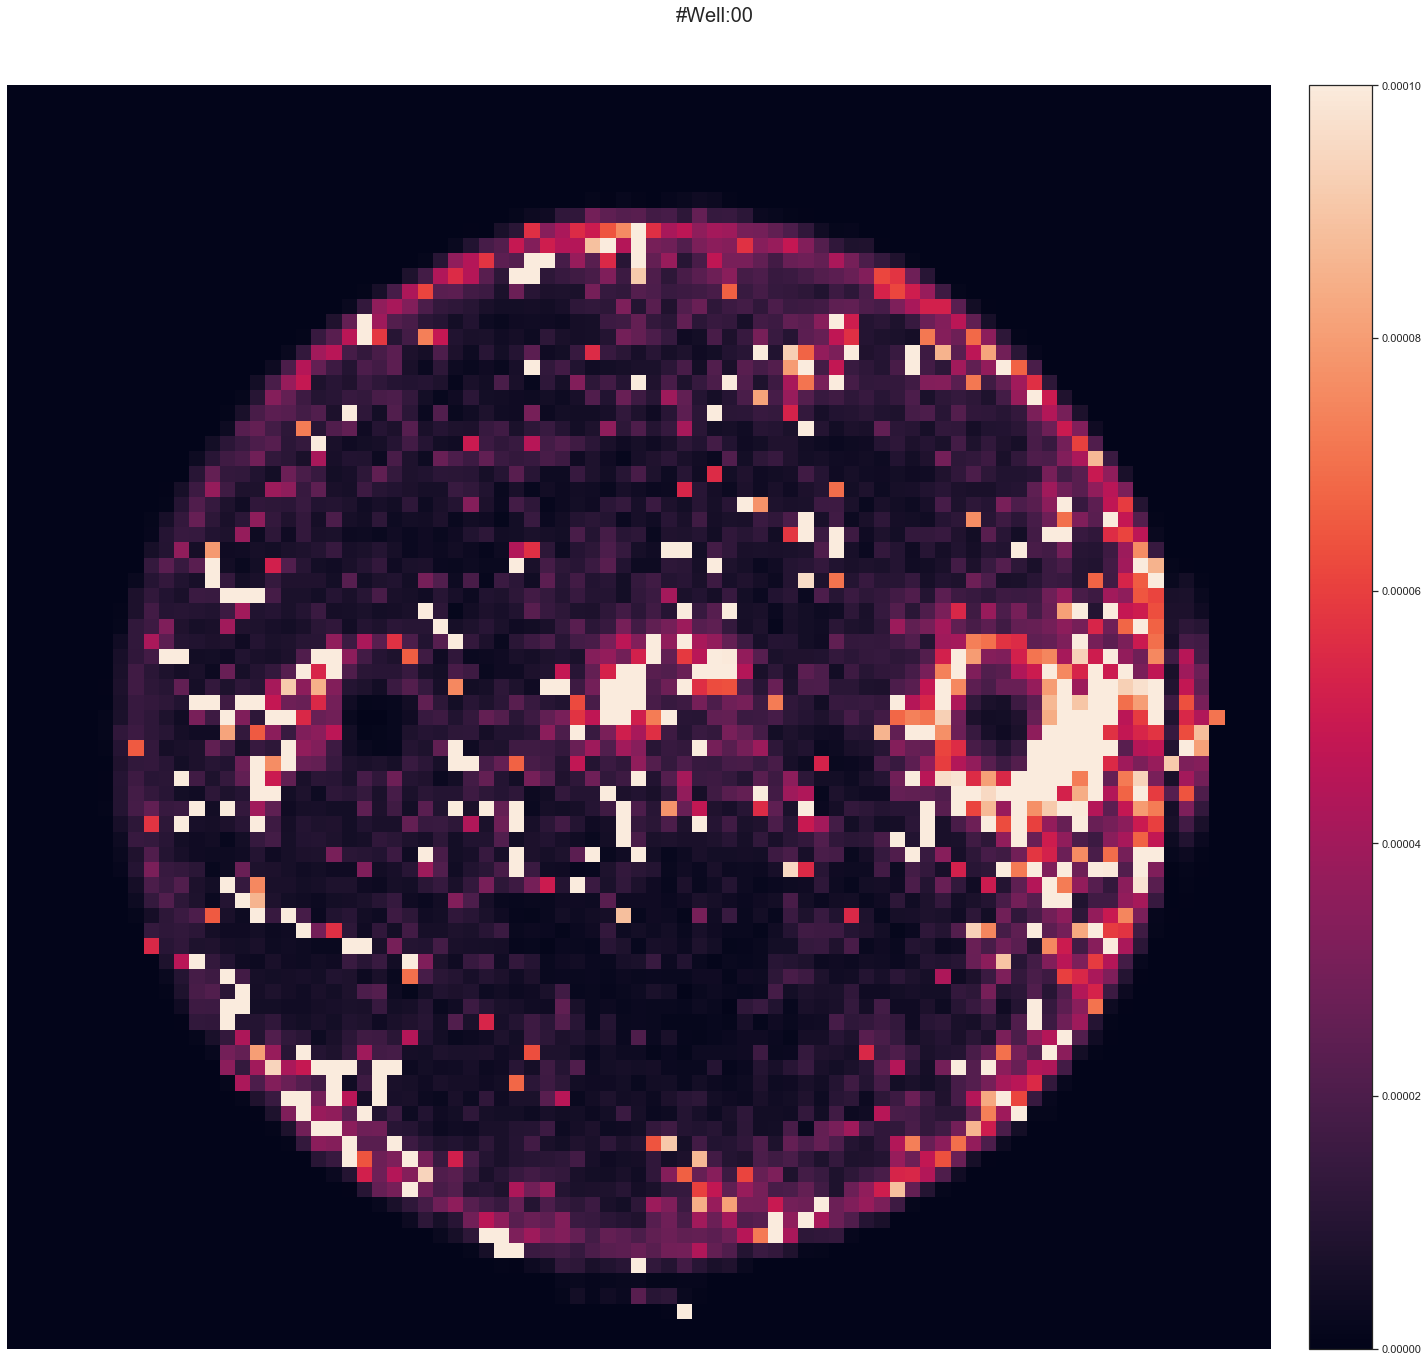

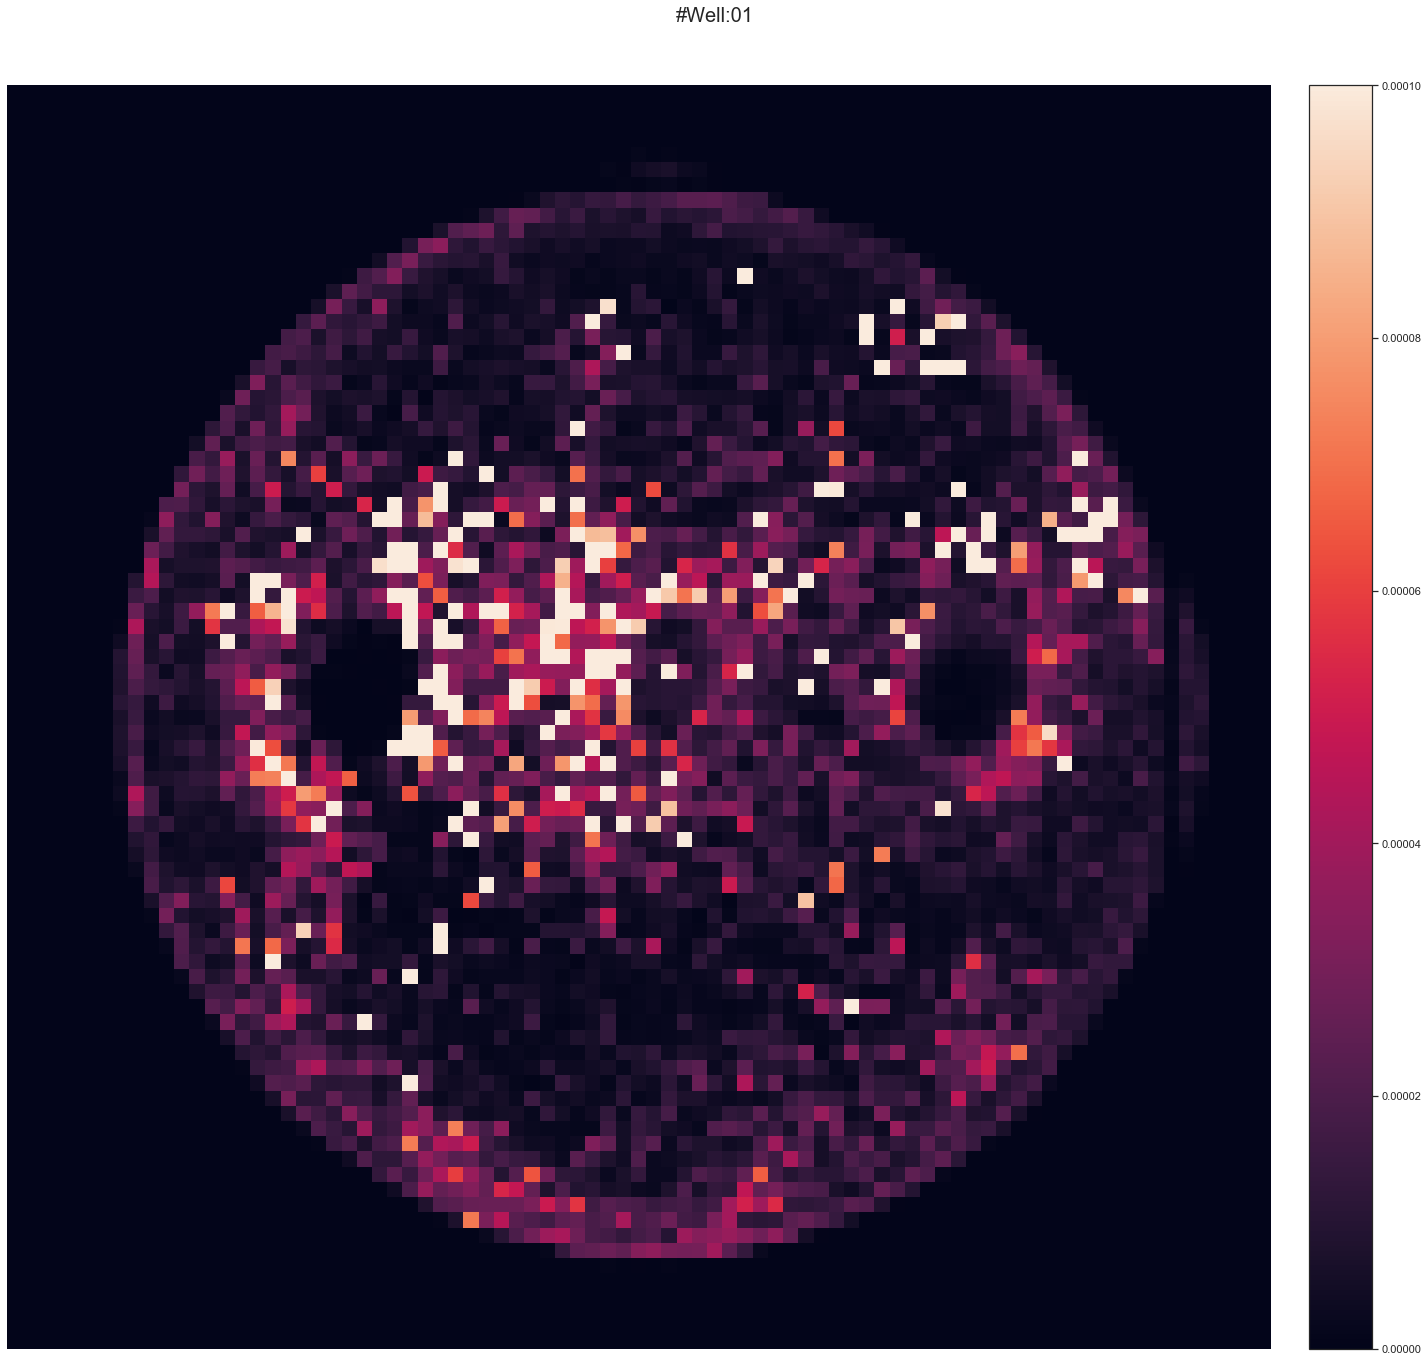

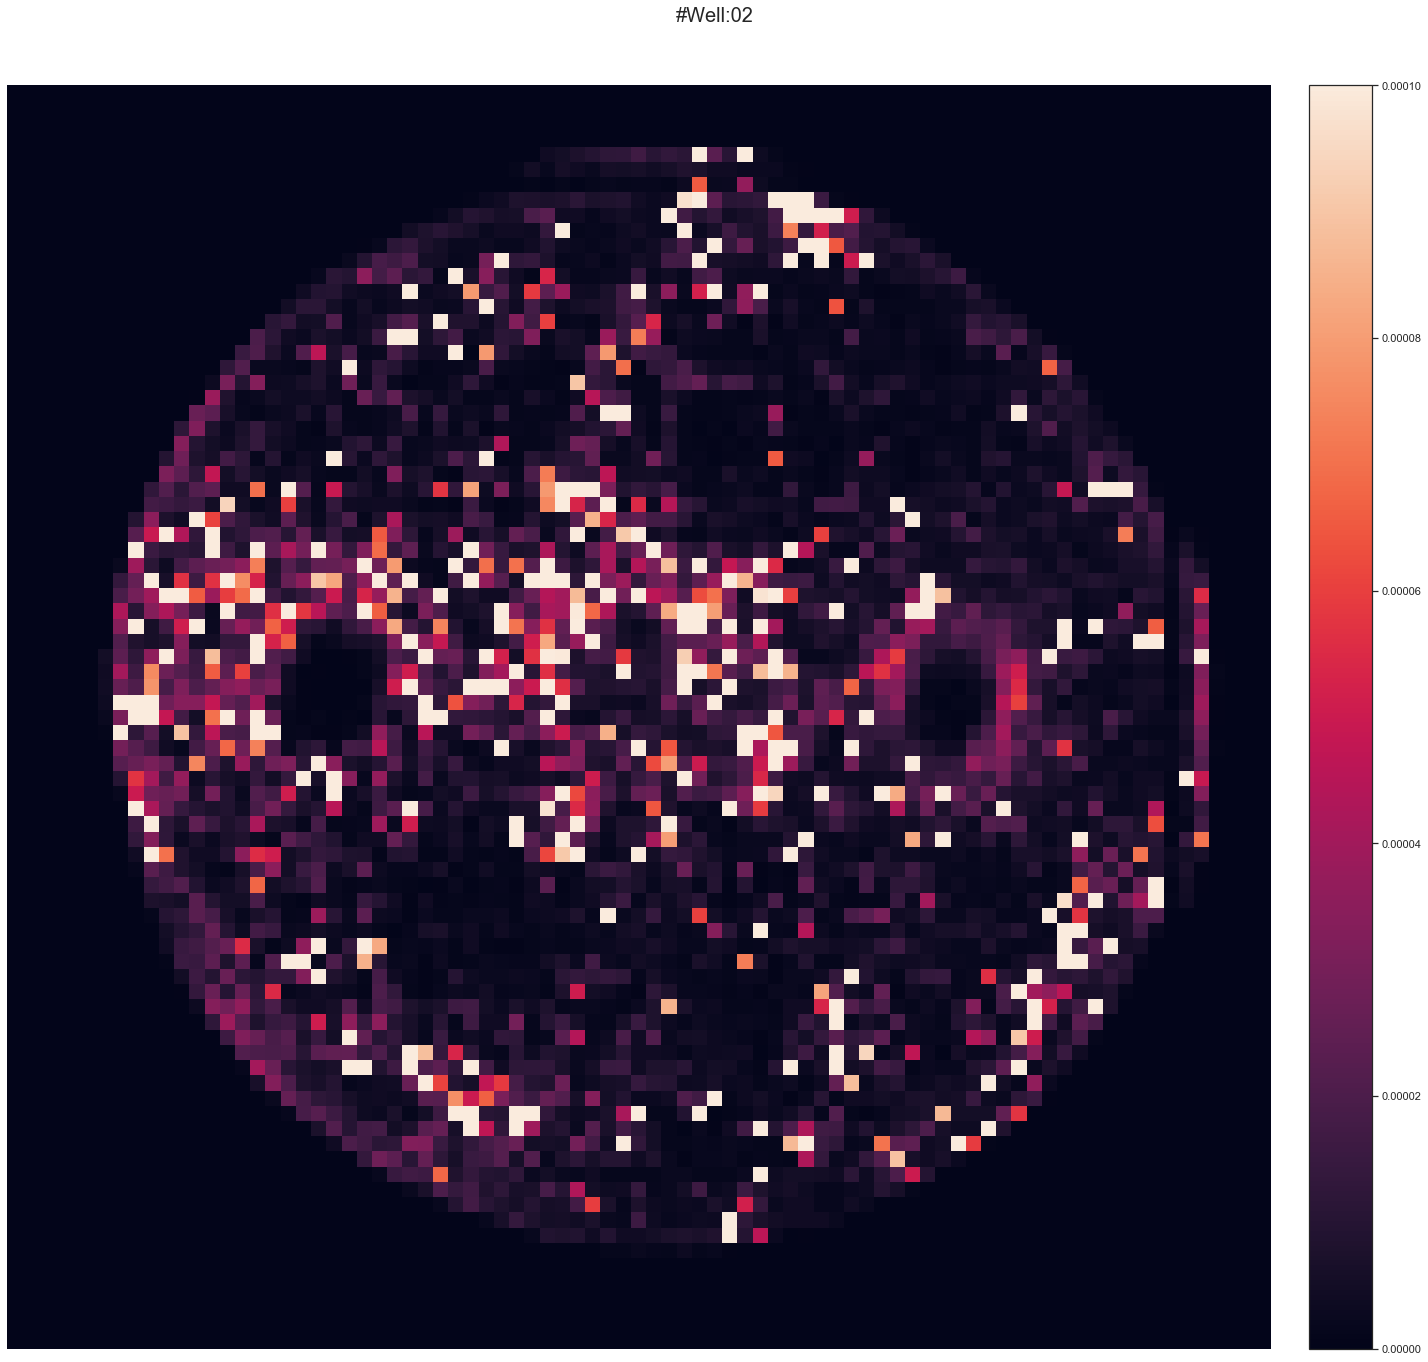

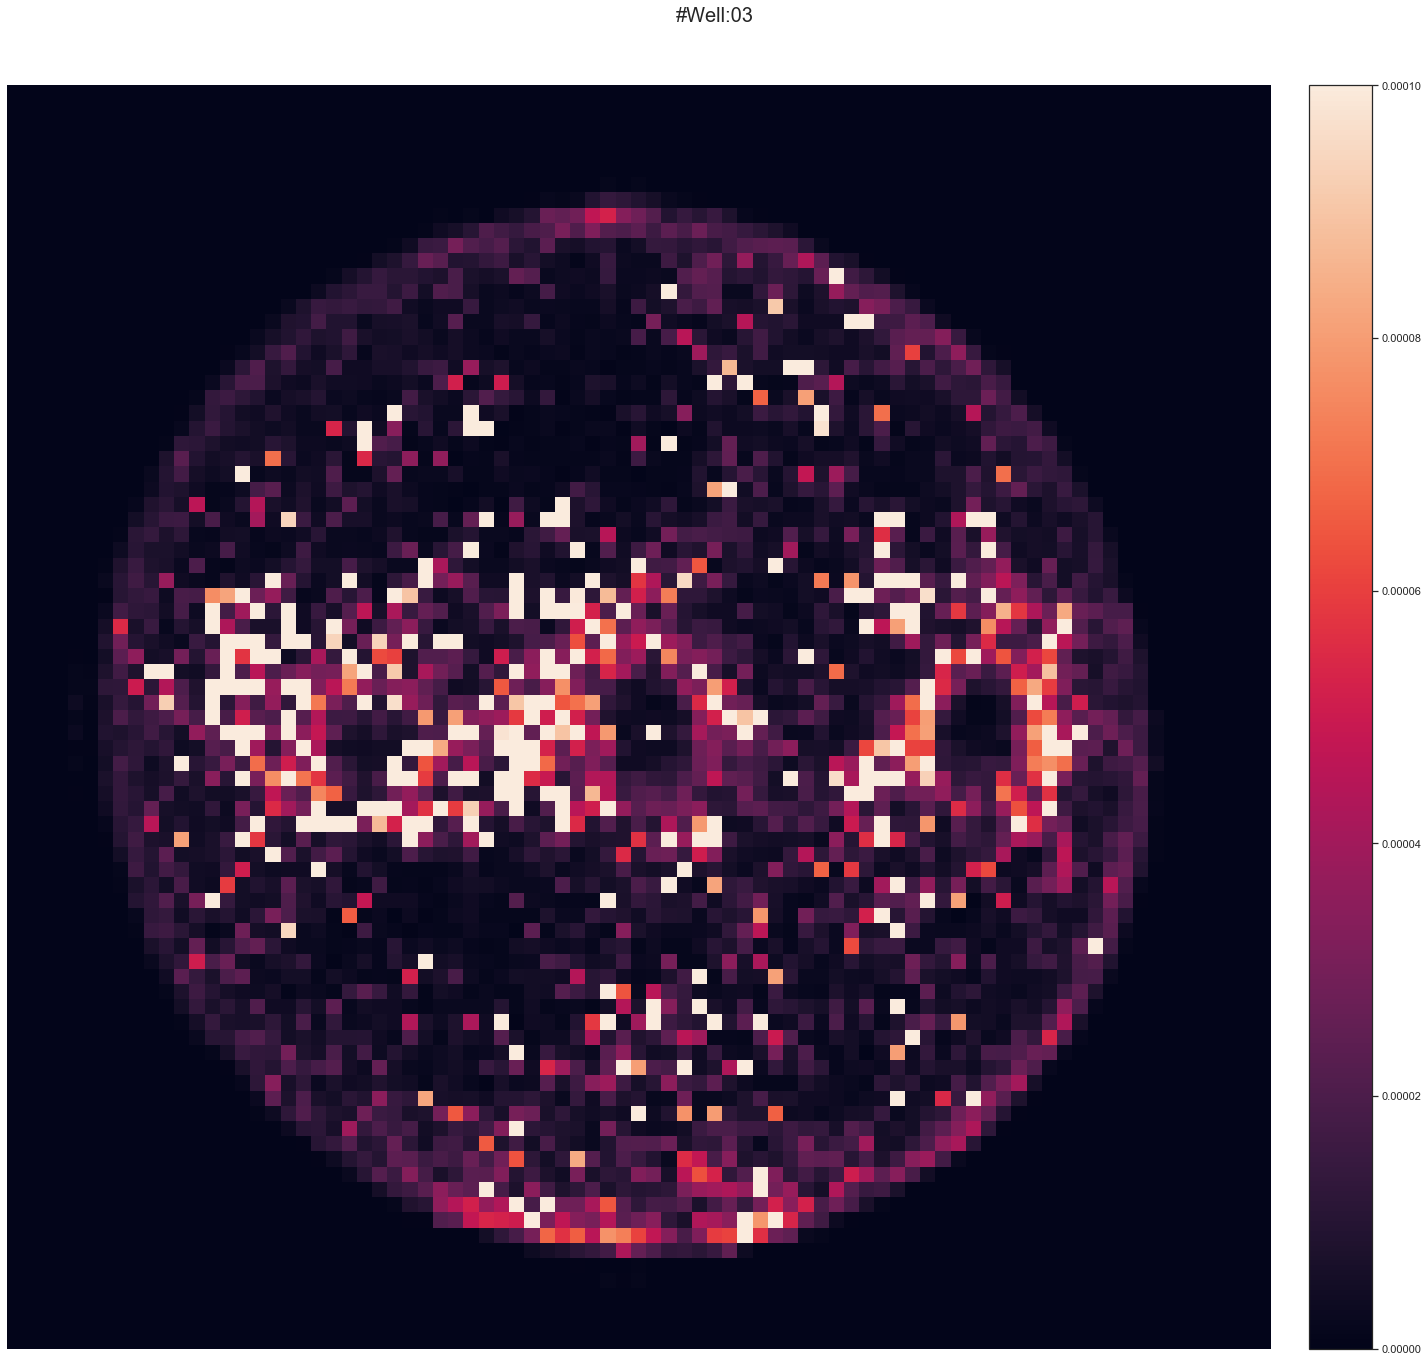

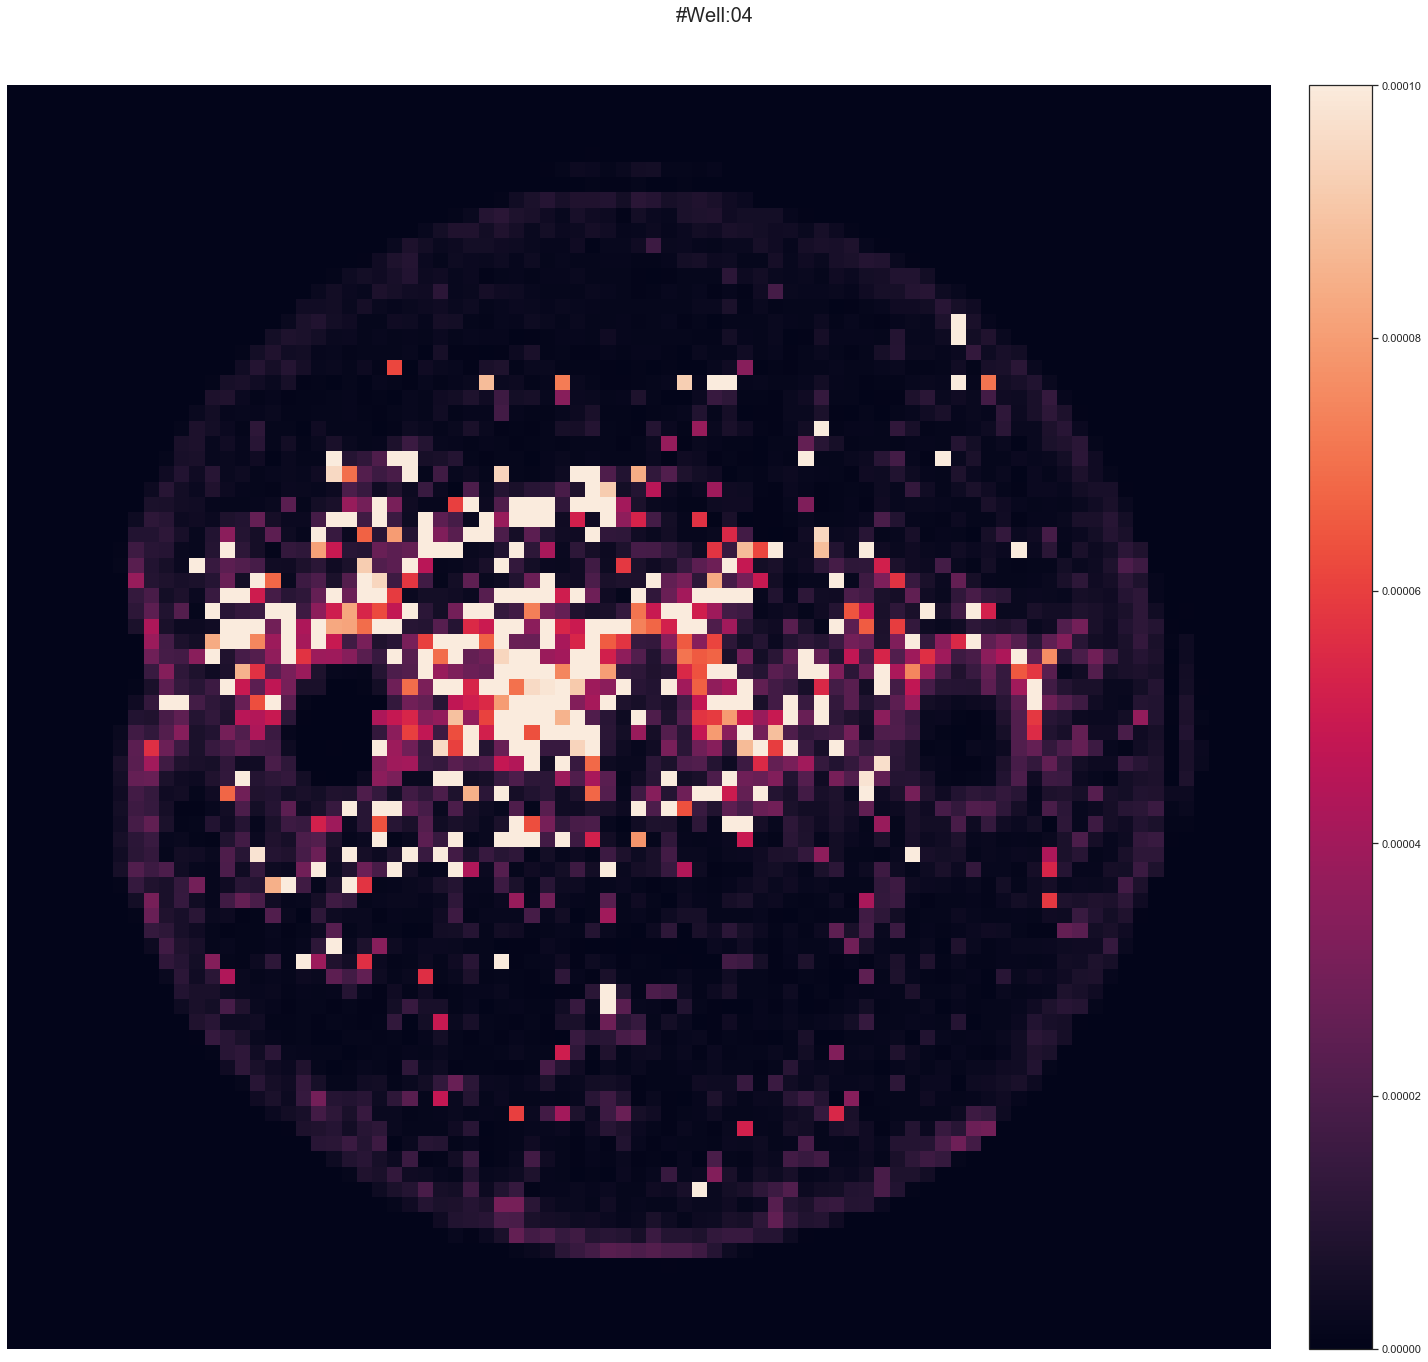

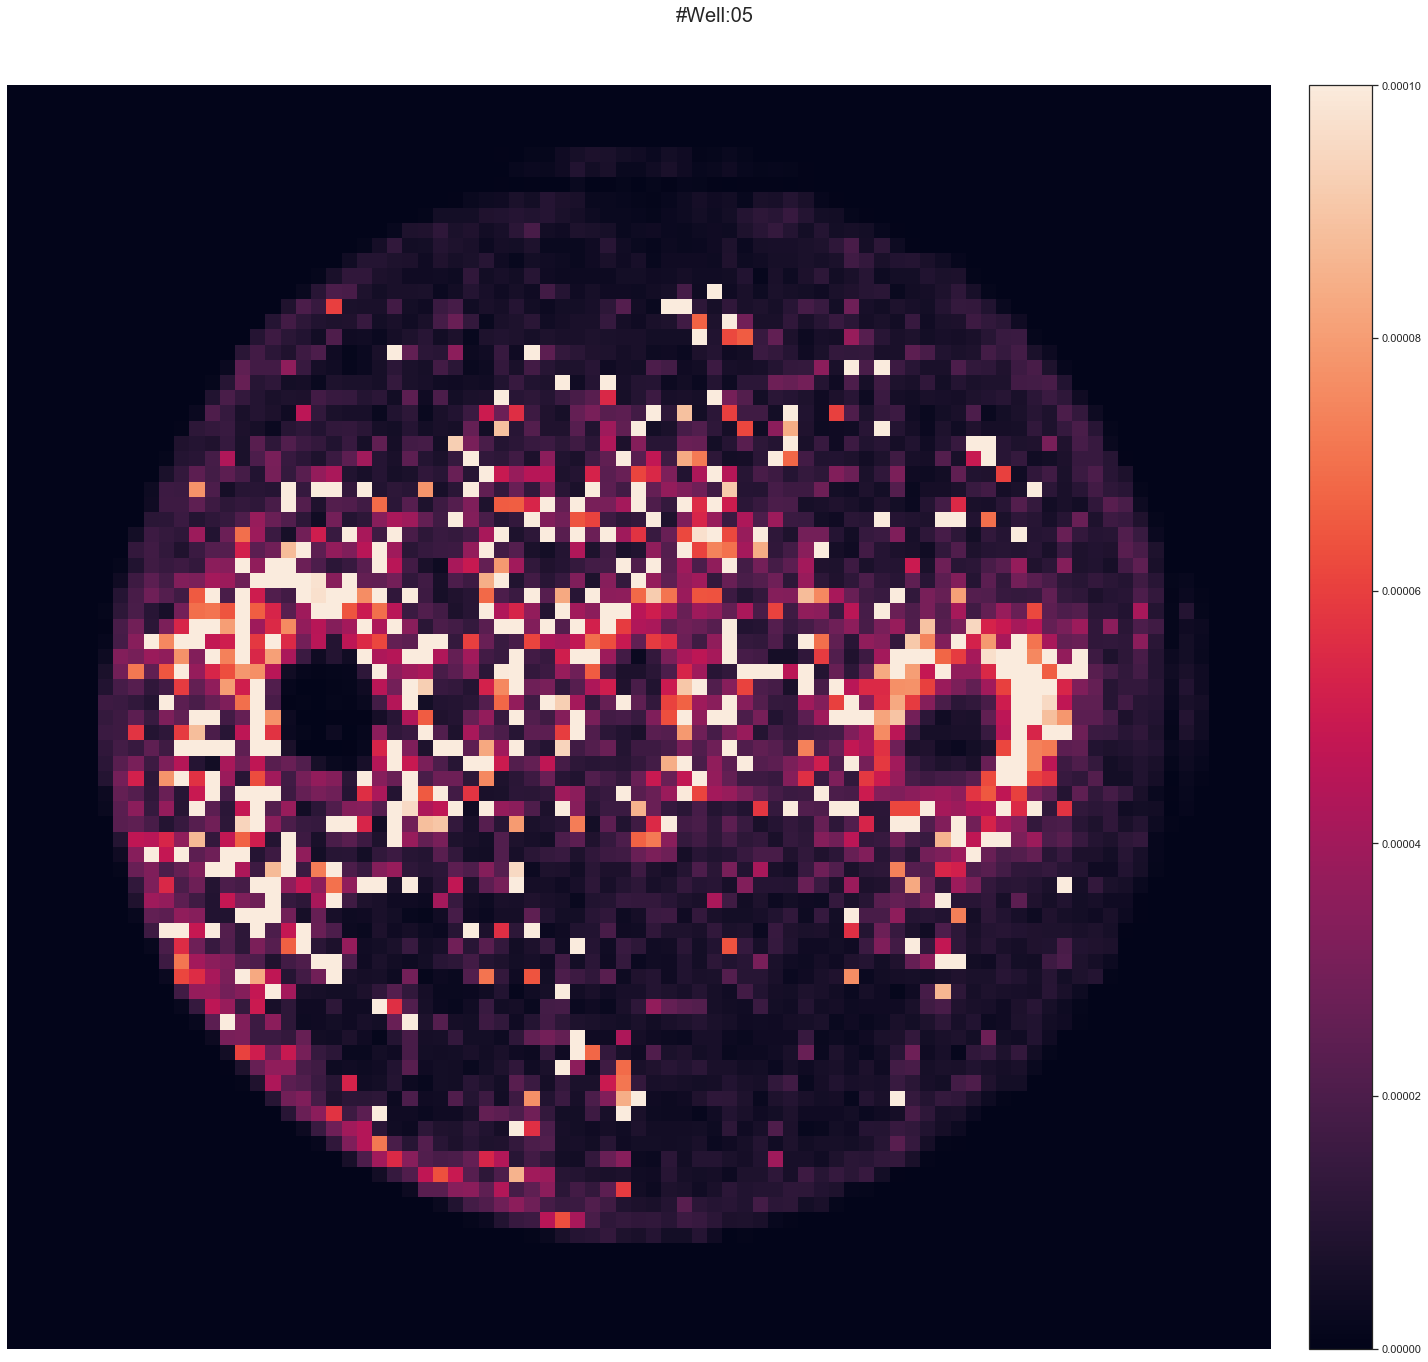

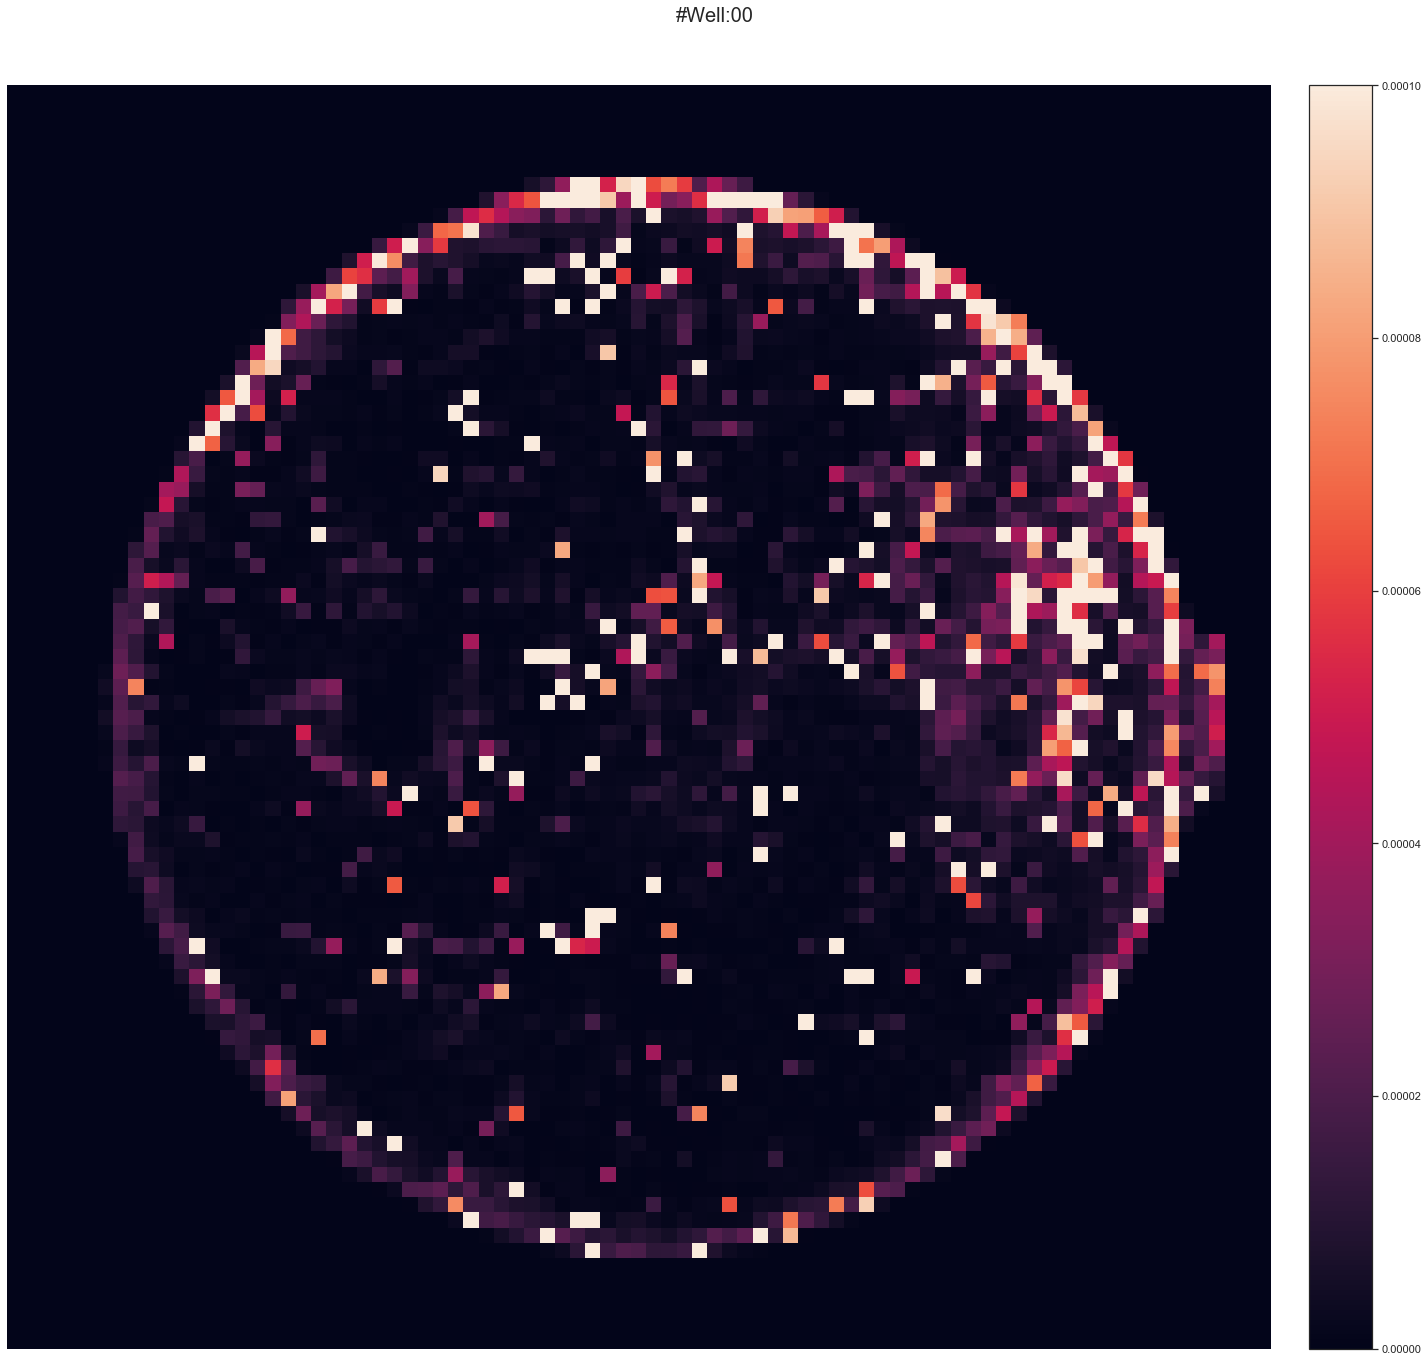

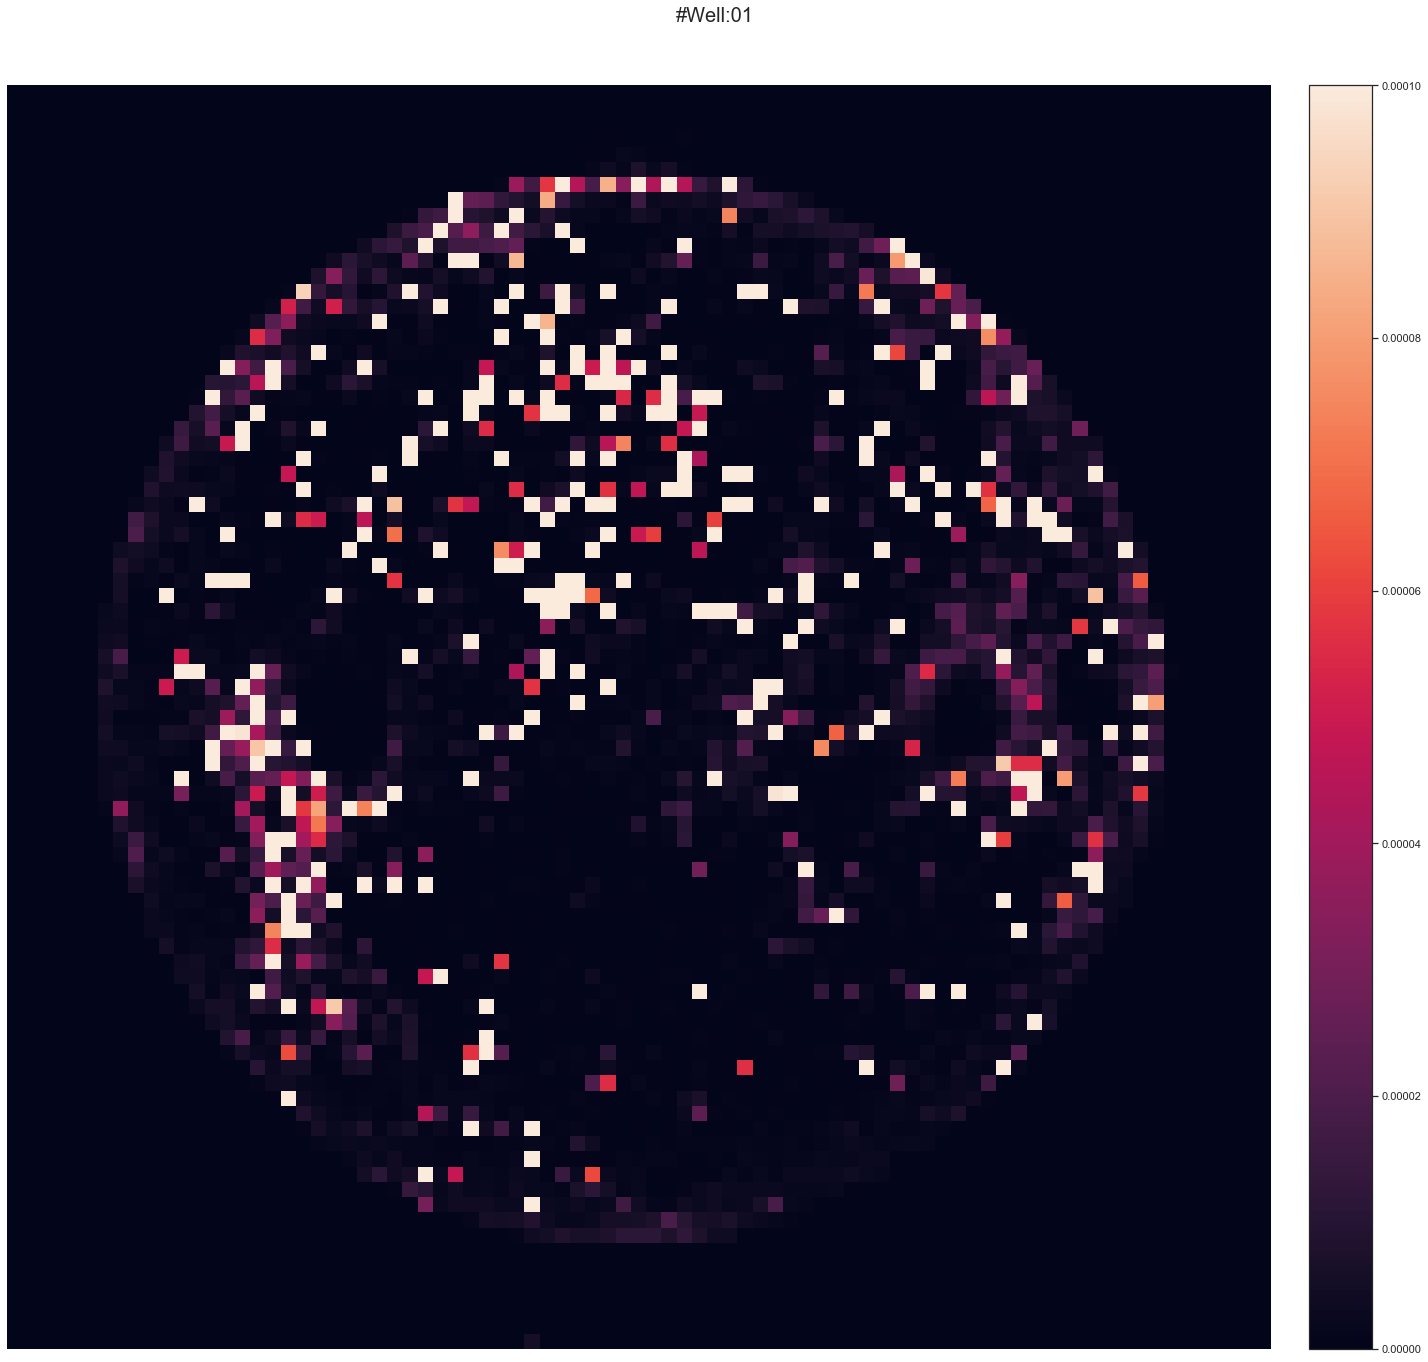

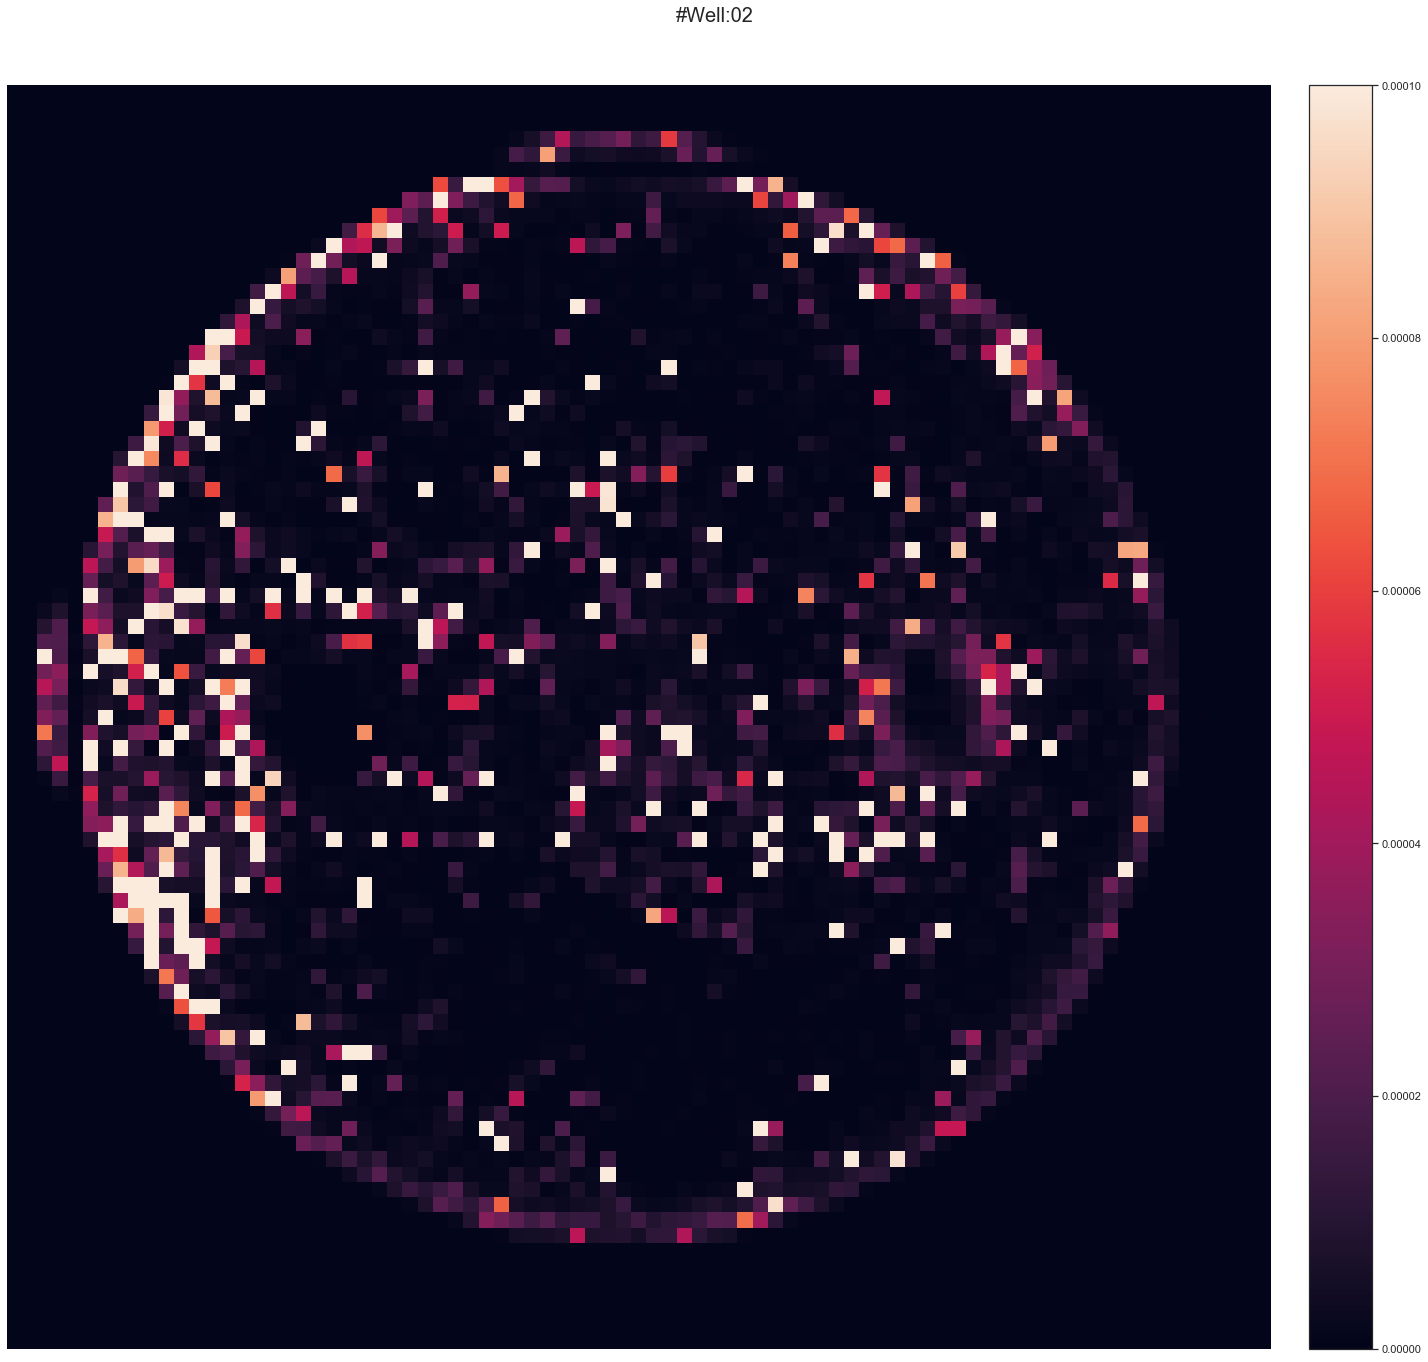

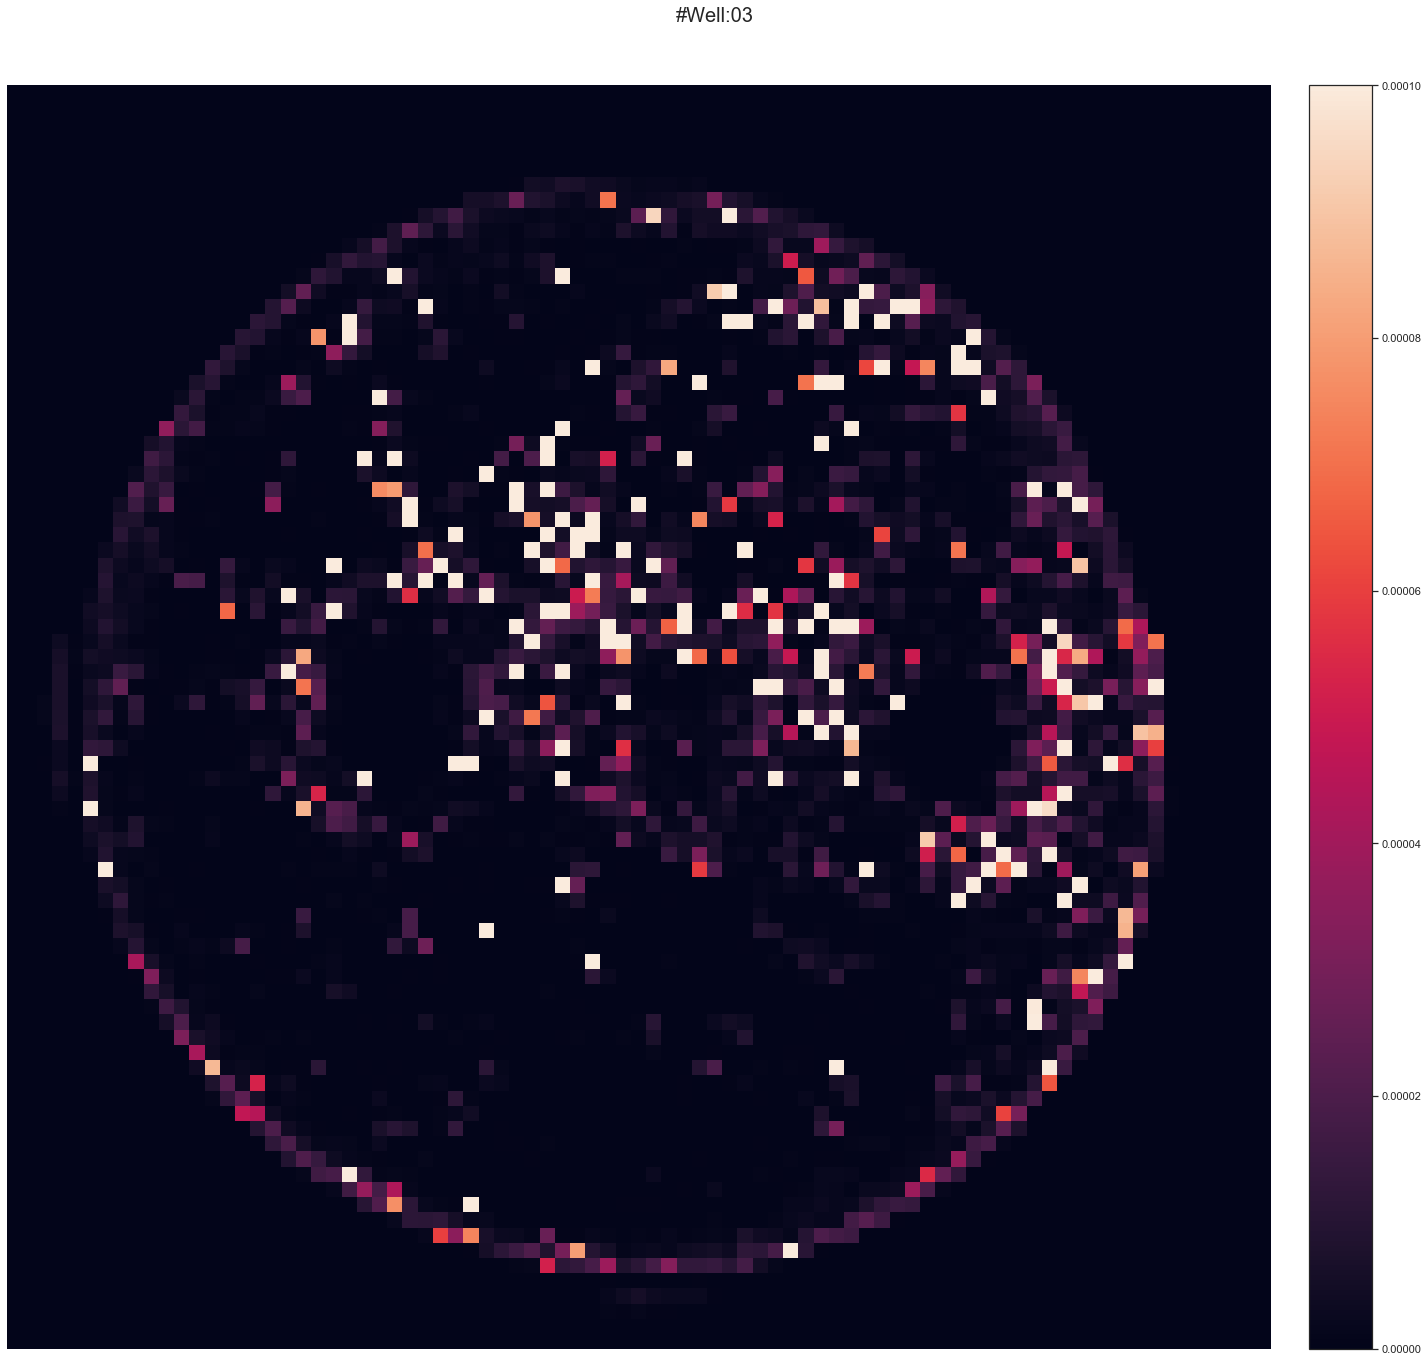

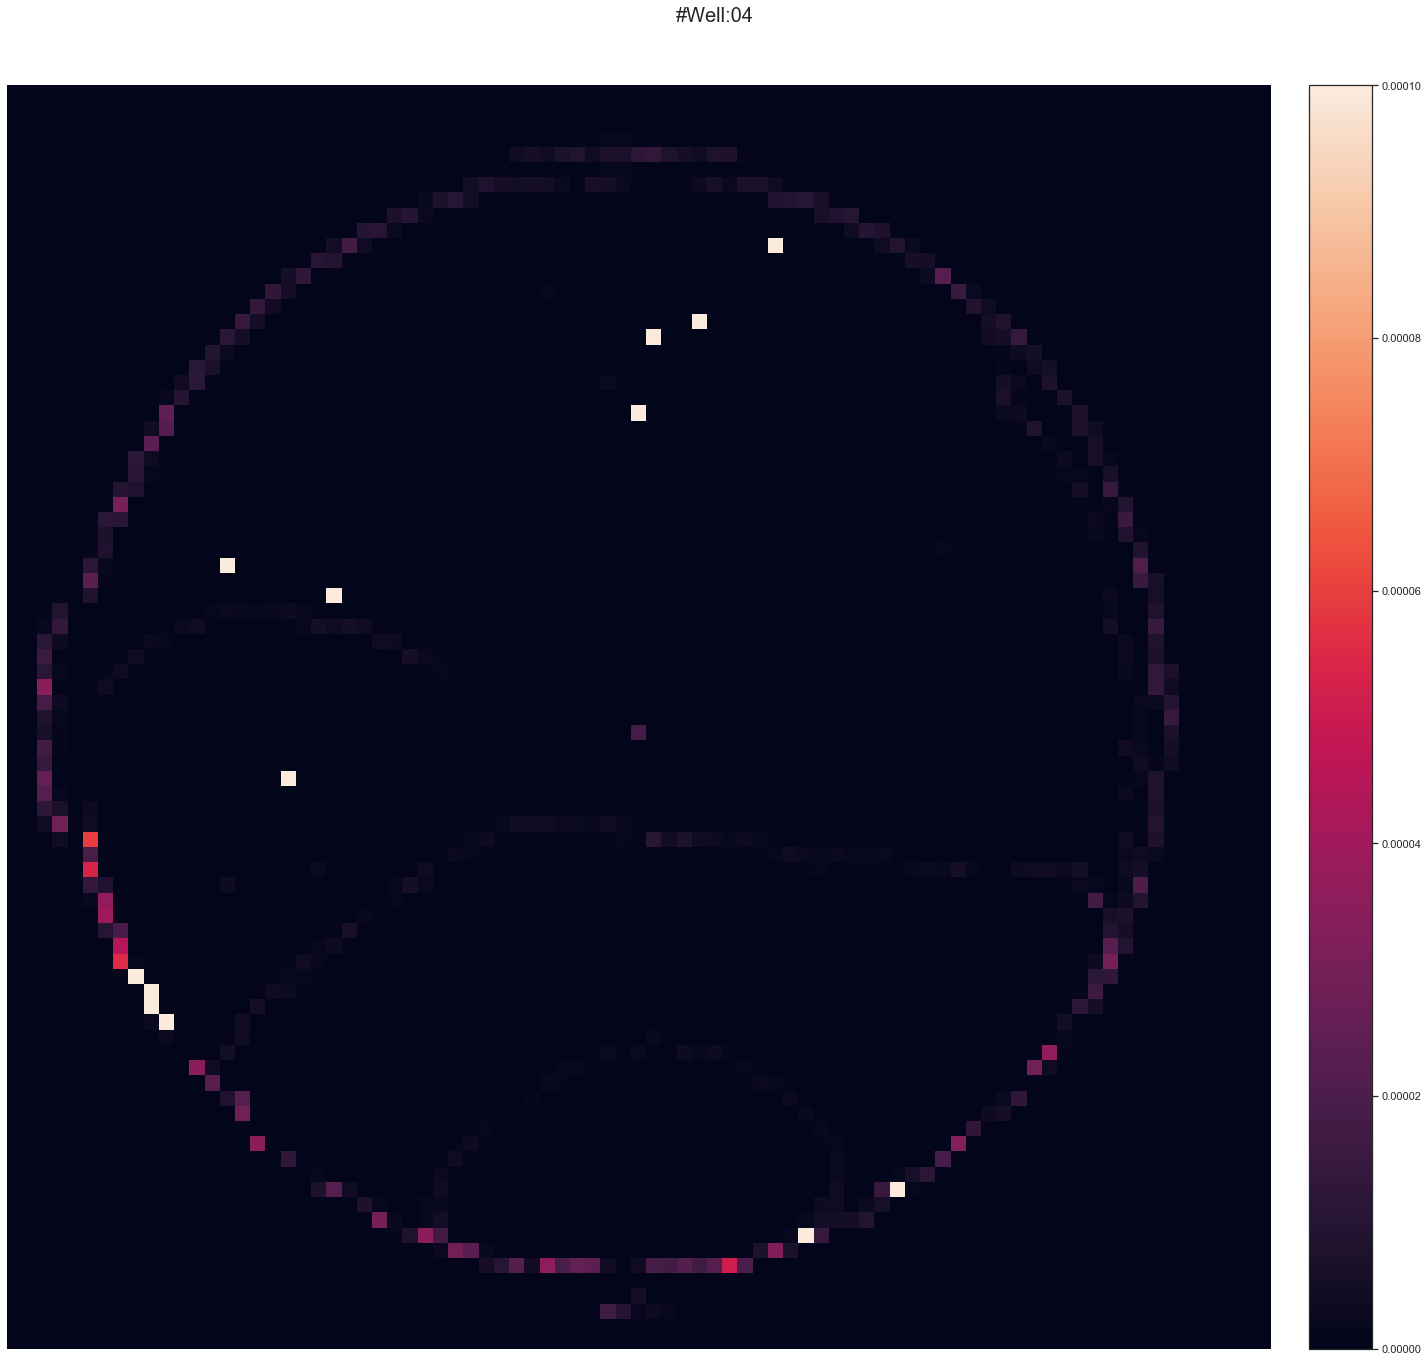

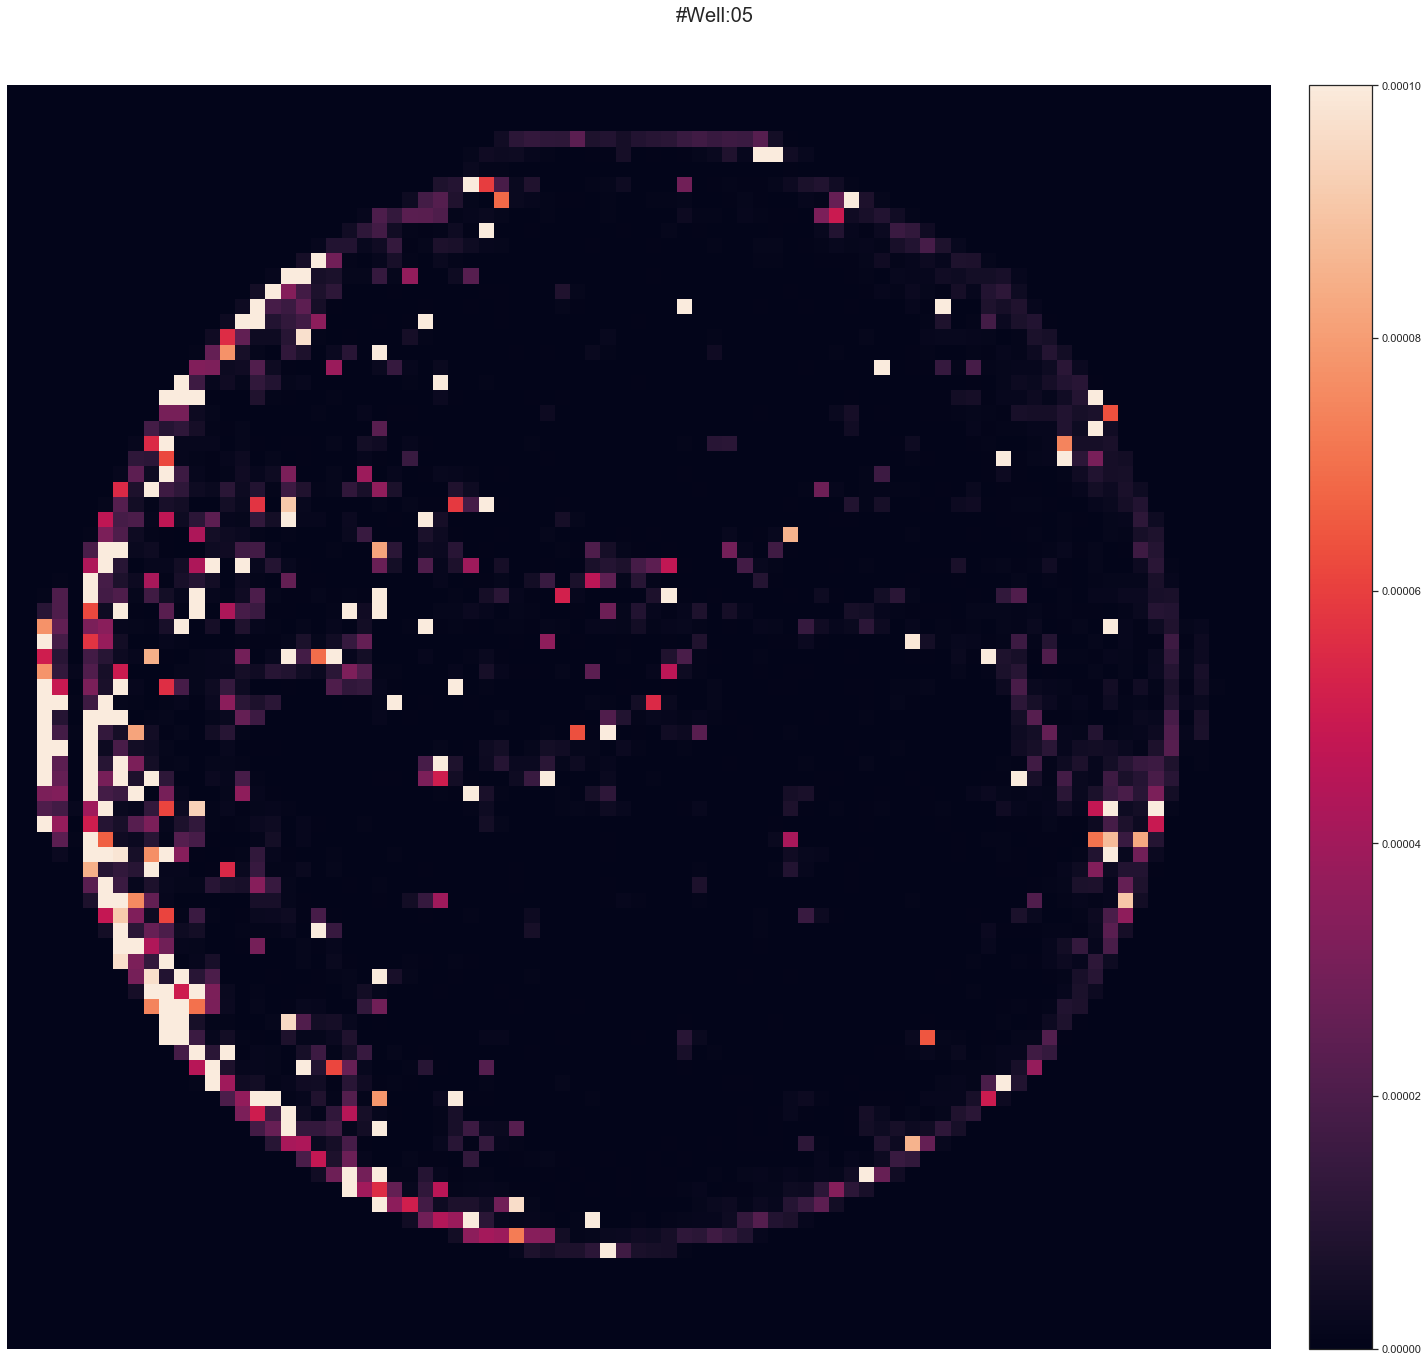


done.


In [10]:
tr_movies = [
            'MOG2',
            #'bg_MOG2',
            #'mdbg_MOG2',
            #'md_MOG2'
            ]

# eclosionの目視判定
eclo_time = {
            'w1118_1' : ['17:00:09', '19:53:18', '19:47:58', '21:24:47', '15:24:38', '19:39:20'],
            'w1118_2' : ['4:48:24', '20:1:57', '21:46:3', '5:17:2', '15:31:9','11:24:14'],
            'w1118_3' : ['2:17:11','2:30:46','21:0:15','20:18:22','14:50:57','2:35:20'],
            'OrR_1'   : ['3:17:17', '14:19:58', '11:32:9', '6:52:35', '11:29:47', '3:39:6'], 
            'OrR_2'   : ['11:19:30', '9:39:54', '10:2:29', '11:46:19', '9:49:48', '9:11:44'],
            'OrR_3'   : ['8:27:54','7:35:22','8:25:0','0:31:12','11:30:37','9:13:10'],
            'CS_1'    : ['12:9:6', '16:53:56', '14:16:44', '16:12:37', '13:11:6', '18:30:31'],
            'CS_2'    : ['16:11:28', '9:15:34', '0:0:0', '12:47:55', '13:42:40', '14:27:52'],
            'CS_3'    : ['12:5:21','12:44:23','6:41:34','11:26:11','11:6:31','8:3:1'],
            }


# 被接近対象の半径Xピクセル内に進入した回数をカウント
def count_entering(dl,dr,thre):
    ind1=np.where(dl<=thre)[0]
    ind2=np.where(dr<=thre)[0]
    x=np.zeros(len(dl))
    x[ind1]=1
    x[ind2]=-1
    n1=len(ind1)
    n2=len(ind2)
    return x,n1,n2

# グラフの整形のためのもの
def set_fontsize(ax,fontsize):
    itemsx=ax.get_xticklabels()
    itemsy=ax.get_yticklabels()
    for i in range(len(itemsx)):
        itemsx[i].set_fontsize(fontsize)
    for i in range(len(itemsy)):
        itemsy[i].set_fontsize(fontsize)

for target in tqdm(targets):
    data_dir = datasets[target]
    
    file_path = os.path.join("{}/{}/csv".format(server_data, data_dir))
    file_path1 = os.path.join("{}/{}/csv".format(local_data, data_dir))
    fs_dis = np.loadtxt("{}/fs_disper.csv".format(file_path1), delimiter=",")
    
    with open(os.path.join(server_data, data_dir, 'mask_params.json')) as f:
        params = json.load(f)
    
    x = params['n-rows']
    y = params['n-clms']
    xlen = params['well-w']
    ylen = params['well-h']
    X = params['x']
    Y = params['y']

    mv_num = len(movies[target])
    #mv_num = 2
    
    wnum = x*y
    
    data_dir = datasets[target]
    tar_mv = movies[target][1]

    tar_path = os.path.join('{}/{}/{}.mp4'.format(server_data, data_dir, tar_mv))

    # 前景用動画読み込みの設定
    movie = cv2.VideoCapture(tar_path)

    # 動画ファイル保存用の設定
    fps = int(movie.get(cv2.CAP_PROP_FPS))                         # 動画のFPSを取得
    
    #fps=3
    eclo_frames=np.zeros(wnum)
    for eclo in range(len(eclo_time[target])):
        tmp=eclo_time[target][eclo]
        h,m,s=tmp.split(':')
        hs=np.int(h)*3600
        ms=np.int(m)*60
        ss=np.int(s)
        alls=hs+ms+ss
        eclo_frames[eclo]=alls*fps
    
    fs_dis = fs_dis.reshape(x*y, 2, 3)

    dl_mean=np.zeros(wnum)
    dl_std=np.zeros(wnum)
    dr_mean=np.zeros(wnum)
    dr_std=np.zeros(wnum)
    distances=pd.DataFrame()

    n1s=np.array([])
    n2s=np.array([])

    # グラフ描画の範囲指定    
    dt_pre=3600*1 # eclosionから前1時間分
    dt_post=3600*20 # eclosion後20時間分
    dframe_pre=dt_pre*fps
    dframe_post=dt_post*fps

    disp_short=0
    # ********************************************
    #x = 1
    #y = 1
    cntr=0
    arr_all=np.array([])
    icntr=0
    for i in tqdm(range(x)): # for image placement
        arrs=np.array([])
        jcntr=0    
        for j in tqdm(range(y)): # for image placement
            fig = plt.figure(figsize=(20,20))
            #G = np.loadtxt(os.path.join(file_path, 'dispersion3/well{:03}.csv'.format(cntr)), delimiter=",")
            G = np.loadtxt(os.path.join(file_path1, 'dispersion/well{:03}.csv'.format(cntr)), delimiter=",")
            disp_range=[eclo_frames[cntr]-dframe_pre,eclo_frames[cntr]+dframe_post]
            if disp_short==1:
                f1=np.int(disp_range[0])
                f2=np.int(disp_range[1])
            else:
                f1=0
                f2=len(G)

            wellnum=str(cntr).zfill(2)
            #fname=h+wellnum+'.csv'
            #dat=pd.read_csv(fname,header=None)
            #data=pd.DataFrame(dat.values,columns=['y-coord','x-coord'])

            oy,ox=G.T
            lx=fs_dis[cntr,1,0]
            ly=fs_dis[cntr,0,0]
            rx=fs_dis[cntr,1,2]
            ry=fs_dis[cntr,0,2]

            #ox=grav['center_x'].values
            #oy=grav['center_y'].values

            dl=((ox-lx)**2+(oy-ly)**2)**0.5
            dr=((ox-rx)**2+(oy-ry)**2)**0.5

            #dl=((dat.values[:,0]-target_loc[cntr,0])**2+(dat.values[:,1]-target_loc[cntr,1])**2)**0.5
            #dr=((dat.values[:,0]-target_loc[cntr,2])**2+(dat.values[:,1]-target_loc[cntr,3])**2)**0.5

            dl_mean[cntr]=np.mean(dl)
            dl_std[cntr]=np.std(dl)
            dr_mean[cntr]=np.mean(dr)
            dr_std[cntr]=np.std(dr)

            w=np.ones(dl.size)*cntr
            df=pd.DataFrame(np.c_[dl,dr,w],columns=['dl','dr','well'])
            distances=pd.concat([distances,df])

            bias=(dl-dr)/(dl+dr)
            bias=pd.Series(bias)
            #bias=bias.rolling(window=30).mean()

            maxt=len(ox)
            sns.set(style="white", color_codes=True)

            xs=range(len(ox))
            # ***** Visualization *****
            #sns.jointplot(x='x-coord', y='y-coord', data=data, kind='kde') #kind=kde,hex
            fontsize=18

            # 保存先がそのままだと画像が上書きされるので注意！! 下の fname も変更
            if 1: # 滞在の時間分布の図を描画したい場合ここを1に。
                #ax=sns.jointplot(x=ox[::10],y=oy[::10],
                #                 xlim=(10,210),ylim=(10,210),kind='kde')
                #fig = plt.figure()
                ax = fig.add_subplot(111)

                H = ax.hist2d(ox[f1:f2],oy[f1:f2], 
                              bins=[np.linspace(0,210,84),np.linspace(0,210,84)],
                              normed=True)
                #ax.set_xlabel('x')
                #ax.set_ylabel('y')
                divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
                cax = divider.append_axes('right', '5%', pad='3%')             
                ax.axis("off")
                H[3].set_clim(0,1e-4)
                ax.set_aspect('equal')
                fig.colorbar(H[3],cax=cax)
                #cbar.set_label("color bar", fontname="Times New Roman", fontsize=10)

                #plt.title('#Well:'+wellnum,fontsize=fontsize)


            else: # 以下は様々な統計を描画               
                bias_thre=0.5 # Bias value

                # *** 1st row ***            
                c='blue'
                ax=plt.subplot2grid((3,6),(0,0),colspan=4)
                lp=plt.plot(xs[f1:f2], bias.values[f1:f2], color=c)
                plt.plot(xs[f1:f2], np.zeros(f2-f1), color='black')
                plt.plot(xs[f1:f2], np.ones(f2-f1)*bias_thre, color='black',alpha=0.5)
                plt.plot(xs[f1:f2], np.ones(f2-f1)*(-bias_thre), color='black',alpha=0.5)
                plt.xlim((-1,maxt+1))
                plt.ylim((-1.05,1.05))
                plt.plot([eclo_frames[cntr],eclo_frames[cntr]],[-1.05,1.05])
                plt.title('#Well:'+wellnum+'     Bias',fontsize=fontsize)
                set_fontsize(ax,fontsize)
                if disp_short==1:
                    plt.xlim(disp_range)

                ax=plt.subplot2grid((3,6),(0,4))
                plt.hist(bias.values[f1:f2],bins=50,range=(-1.0,1.0),orientation='horizontal',color=c)
                plt.title('Hist dr',fontsize=fontsize)
                plt.ylim(-1.05,1.05)
                set_fontsize(ax,fontsize)
                ax.set_yticklabels([])
                xl=ax.get_xlim()


                ax=plt.subplot2grid((3,6),(0,5))
                plt.bar([0,1],[np.mean(dl[f1:f2]),np.mean(dr[f1:f2])],color=c)
                ax.set_xticks([0,1])
                ax.set_xticklabels(['dL','dR'],fontsize=fontsize)
                plt.title('Average',fontsize=fontsize)
                set_fontsize(ax,fontsize)
                '''
                save_dir = os.path.join("{file_path1}/bias3".format(local_data, data_dir))
                os.makedirs(save_dir, exist_ok=True)
                np.savetxt("{}/well{:03}.csv".format(save_dir,cntr), bias.values, fmt="%f", delimiter=",") 
                '''

                # *** 2st row ***
                c='red'
                ind1=np.where(bias.values[f1:f2]>=bias_thre)[0]
                ind2=np.where(bias.values[f1:f2]<=-bias_thre)[0]
                n1=len(ind1)
                n2=len(ind2)

                biasmod=np.copy(bias.values[f1:f2])
                ind=np.where((biasmod<bias_thre)&(biasmod>(-bias_thre)))[0]
                biasmod[ind]=0.0

                plotdata=np.cumsum(biasmod)
                ymax=np.max(np.abs(plotdata))
                ax=plt.subplot2grid((3,6),(1,0),colspan=4)
                lp=plt.plot(xs[f1:f2], plotdata, color=c,linewidth=3)
                plt.plot(xs, np.zeros(len(xs)), color='black')
                plt.ylim([-ymax*1.1,ymax*1.1])
                plt.plot([eclo_frames[cntr],eclo_frames[cntr]],[-ymax*1.1,ymax*1.1],
                         color='k',linewidth=3)
                plt.xlim((-1,maxt+1))
                plt.title('Cumsum of Bias exceeding thre',fontsize=fontsize)
                set_fontsize(ax,fontsize)
                if disp_short==1:
                    plt.xlim(disp_range)


                ax=plt.subplot2grid((3,6),(1,4))
                plt.hist(np.r_[biasmod[ind1],biasmod[ind2]],bins=50,range=(-1.0,1.0),orientation='horizontal',color=c)
                set_fontsize(ax,fontsize)
                ax.set_xlim(xl)

                ax=plt.subplot2grid((3,6),(1,5))
                plt.bar([0,1],[n1,n2],color=c)
                ax.set_xticks([0,1])
                ax.set_xticklabels(['High','Low'],fontsize=fontsize)
                plt.title('Count',fontsize=fontsize)
                set_fontsize(ax,fontsize)
                '''
                save_dir = os.path.join("{file_path1}/th_bias3".format(local_data, data_dir))
                os.makedirs(save_dir, exist_ok=True)
                np.savetxt("{}/well{:03}.csv".format(save_dir,cntr), plotdata, fmt="%f", delimiter=",")
                '''

                # *** 3rd row ***
                thres=[15,20,25]
                if cntr==0:
                    onset_frames=np.zeros((wnum,len(thres)))
                xx=np.zeros((len(thres),len(dl)))
                nn1=np.zeros(len(thres))
                nn2=np.zeros(len(thres))
                for ii in range(len(thres)):
                    xx[ii,:],nn1[ii],nn2[ii]=count_entering(dl[f1:f2],dr[f1:f2],thres[ii])
                if cntr==0:
                    n1s=nn1
                    n2s=nn2
                else:
                    n1s=np.c_[n1s,nn1]
                    n2s=np.c_[n2s,nn2]

                cs=['green','magenta','cyan']
                ax=plt.subplot2grid((3,6),(2,0),colspan=4)
                if 0:
                    for ii in range(len(thres)):
                        d=np.cumsum(xx[ii])
                        lp=plt.plot(xs, d, color=cs[ii],linewidth=3)
                        enter_count_thre=600*fps
                        ind=np.where(d>enter_count_thre)[0]
                        if len(ind)==0:
                            onset_frames[cntr,ii]=0
                        else:
                            onset_frames[cntr,ii]=ind[0]
                else:
                    tmpmax=np.zeros_like(thres)
                    for ii in range(len(thres)):
                        d=np.cumsum(xx[ii])
                        ind_l=np.where(xx[ii]==+1)[0]
                        ind_r=np.where(xx[ii]==-1)[0]

                        lv,b=np.histogram(ind_l,bins=range(0,f2-f1,2000))
                        #plt.plot(b[:-1],lv,linewidth=3,color=cs[ii])
                        rv,b=np.histogram(ind_r,bins=range(0,f2-f1,2000))
                        #plt.plot(b[:-1],-rv,linewidth=3,color=cs[ii])
                        #plt.plot(b[:-1],-rv+lv,linewidth=3,color=cs[ii])
                        tmpmax[ii]=np.max([np.max(np.abs(lv)),np.max(np.abs(rv))])

                        plotdata=np.cumsum(-rv+lv)
                        plt.plot(b[:-1],np.cumsum(-rv+lv),linewidth=3,color=cs[ii])
                        tmpmax[ii]=np.max(np.abs(plotdata))


                        enter_count_thre=600*fps
                        ind=np.where(d>enter_count_thre)[0]
                        if len(ind)==0:
                            onset_frames[cntr,ii]=0
                        else:
                            onset_frames[cntr,ii]=ind[0]

                #ymax=np.max(np.abs(np.cumsum(xx[-1])))
                ymax=np.max(tmpmax)
                plt.plot(xs, np.zeros(len(xs)), color='black')
                plt.ylim([-ymax*1.1,ymax*1.1])
                for ii in range(len(thres)):        
                    plt.plot([onset_frames[cntr,ii],onset_frames[cntr,ii]],
                             [-ymax*1.1,ymax*1.1],color=cs[ii],linewidth=3)

                plt.plot([eclo_frames[cntr],eclo_frames[cntr]],[-ymax*1.1,ymax*1.1],
                        color='k',linewidth=3)
                plt.xlim((-1,maxt+1))
                plt.title('Cumsum of count entering circle (G:15,M:20,C:25 pixel)',
                          fontsize=fontsize)
                set_fontsize(ax,fontsize)
                if disp_short==1:
                    plt.xlim(disp_range)


                yl=np.max([np.max(nn1),np.max(nn2)])*1.1
                for ii in range(len(thres)):
                    ax=plt.subplot2grid((3,9),(2,6+ii))
                    plt.bar([0,1],[nn1[ii],nn2[ii]],color=cs[ii])
                    set_fontsize(ax,fontsize)
                    ax.set_xticks([0,1])
                    ax.set_xticklabels(['L','R'],fontsize=fontsize)
                    ax.set_ylim([0,yl])


            #sys.exit()
            # *************************
            
            # 滞在分布を出力する時はここも１に
            if 1:
                fname = os.path.join(local_data,data_dir,'img2')
            else:
                fname = os.path.join(local_data,data_dir,'th2_img')
            os.makedirs(fname, exist_ok=True)
            imfname = fname+'/well{}.png'.format(wellnum)
            plt.savefig(imfname)
            arr=np.array(Image.open(imfname))
            if jcntr==0: arrs=arr
            else: arrs=np.hstack((arrs,arr))
            jcntr+=1

            plt.suptitle('#Well:'+wellnum,verticalalignment='bottom',fontsize=20)        

            plt.tight_layout()
            plt.show()

            cntr+=1
        if icntr==0: arr_all=arrs
        else: arr_all=np.vstack((arr_all,arrs))
        icntr+=1

    pil_img = Image.fromarray(arr_all)
    pil_img.save(os.path.join(fname,'img-summary.png'))
    
#plt.figure(figsize=(15, 15))
#ax = sns.violinplot(x=distances['well'], y=pkmn["dr"], split=True) 

print('done.')

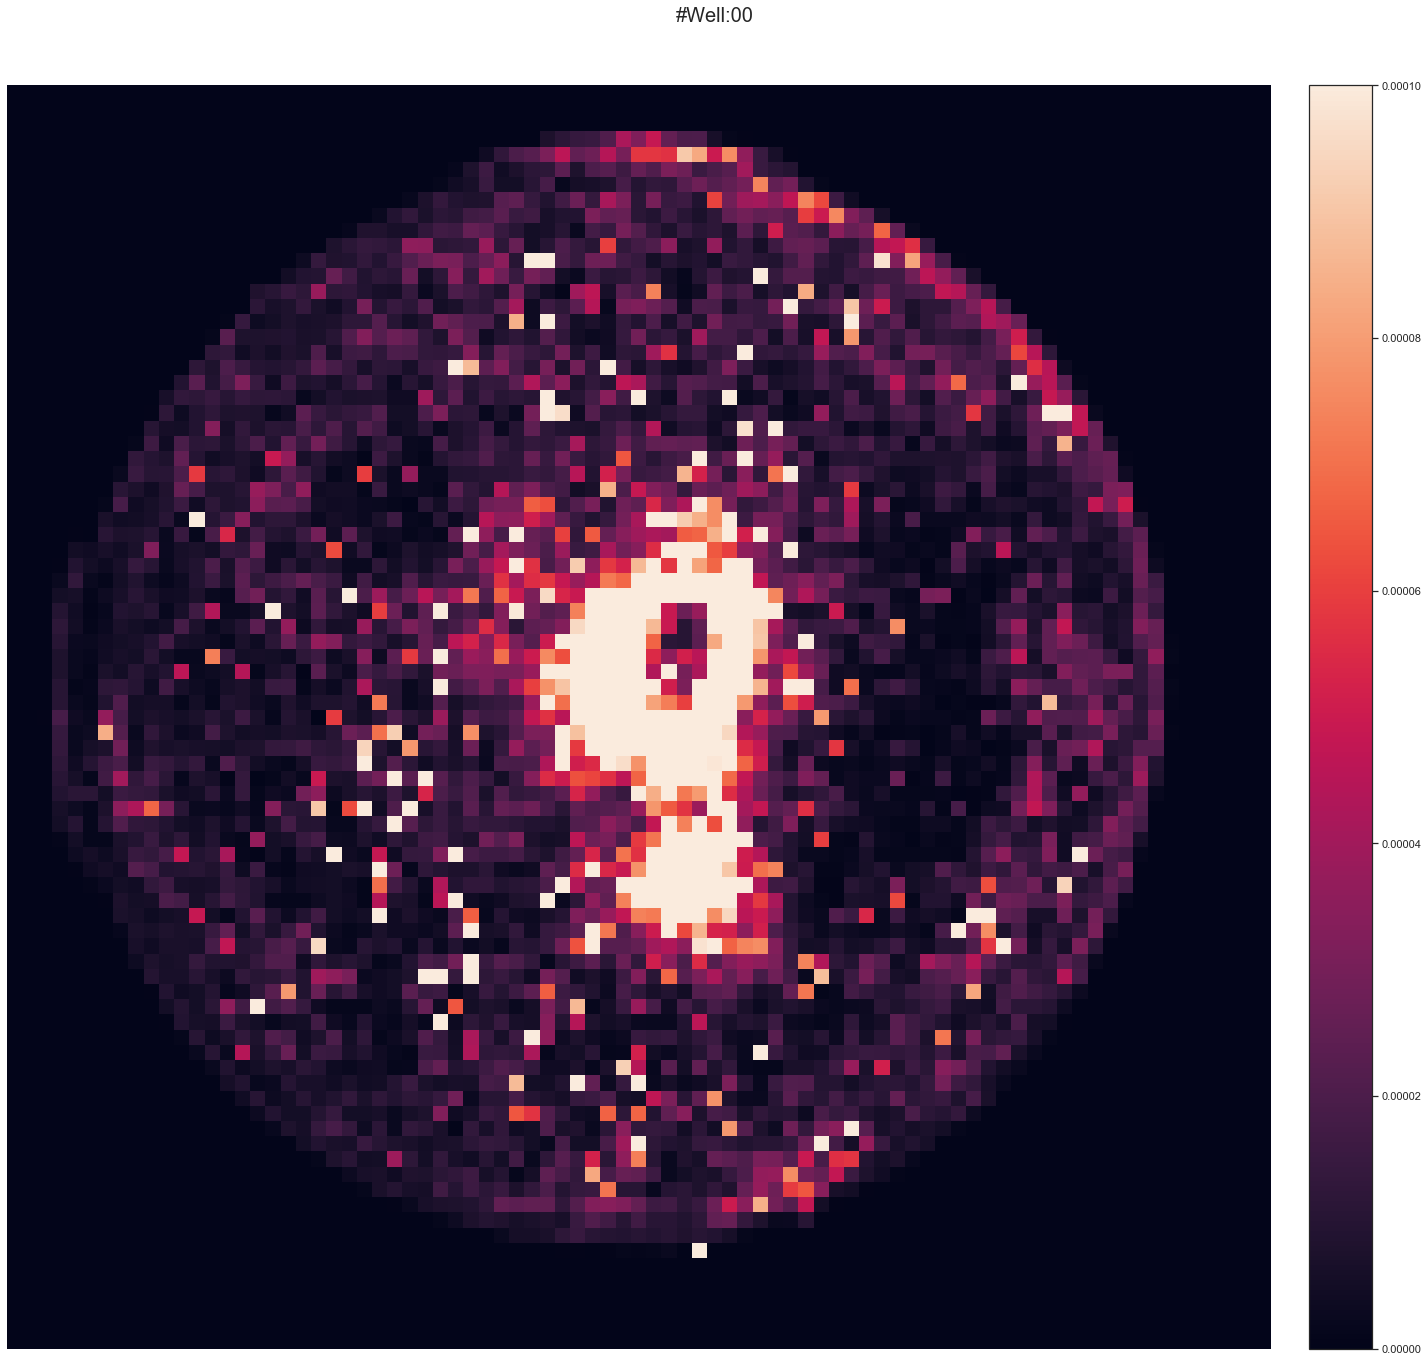

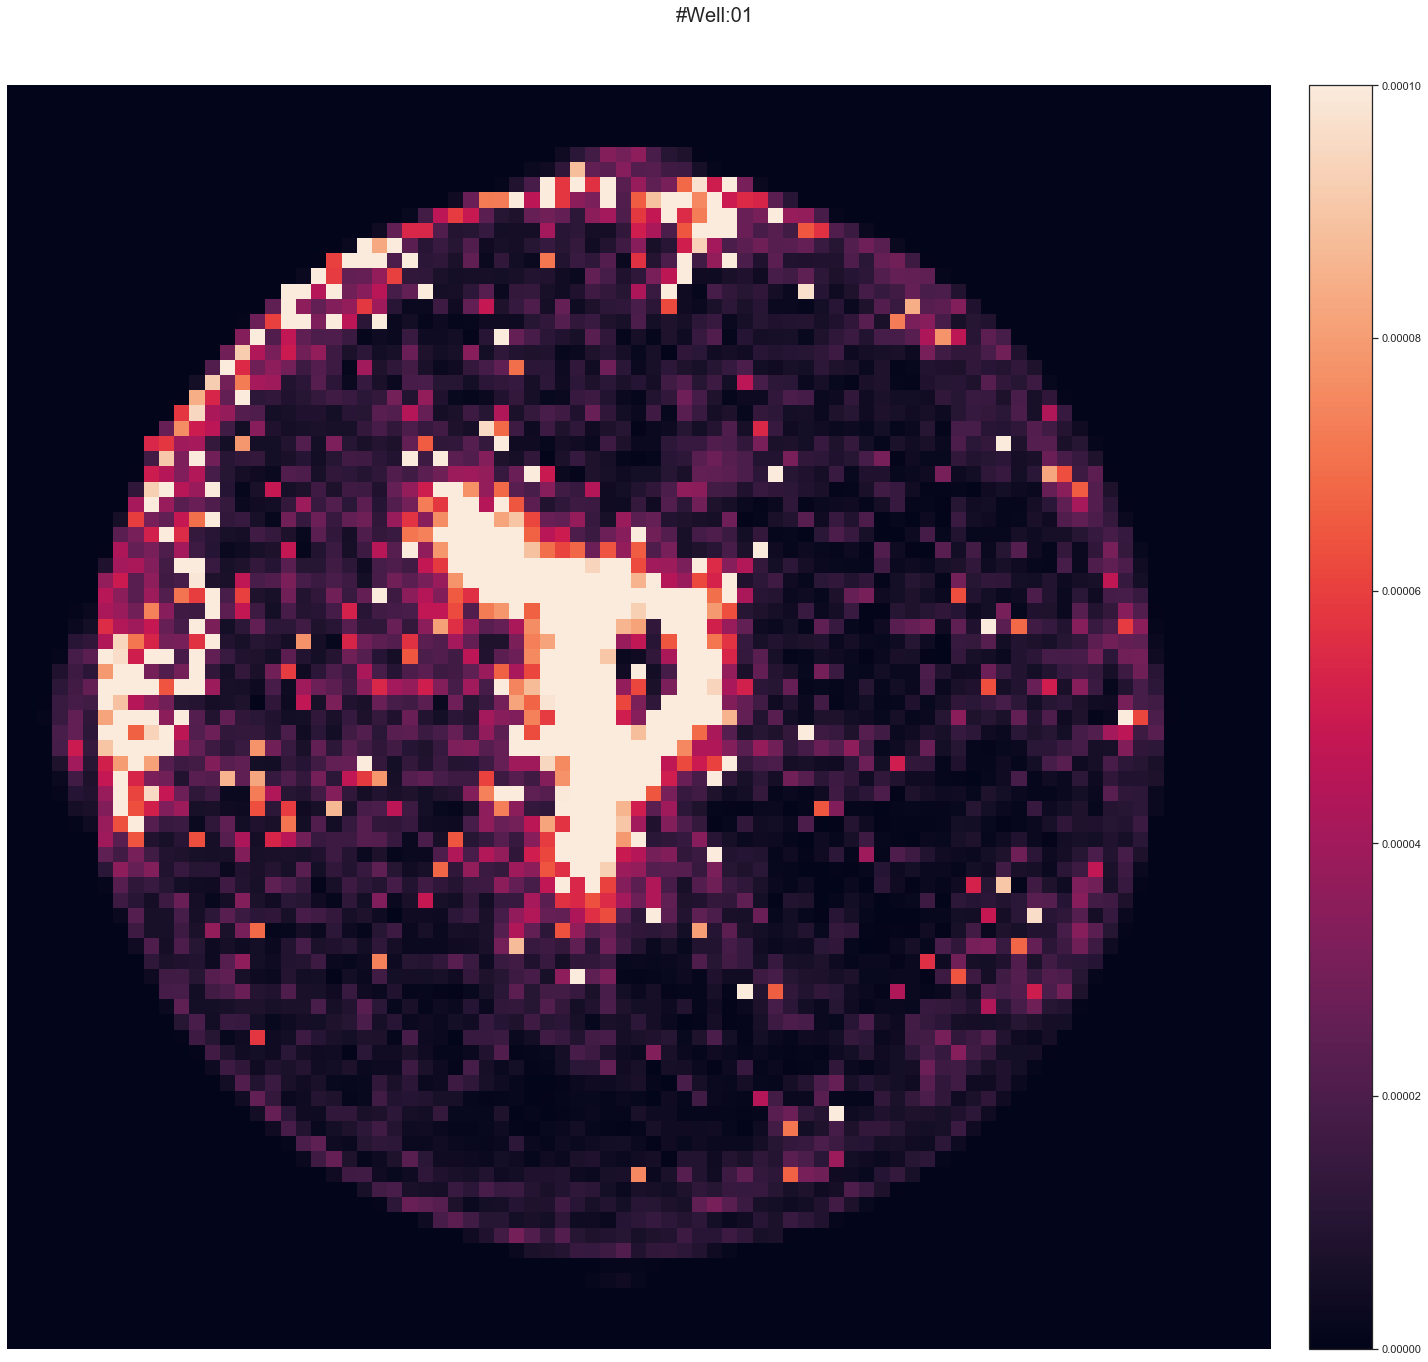

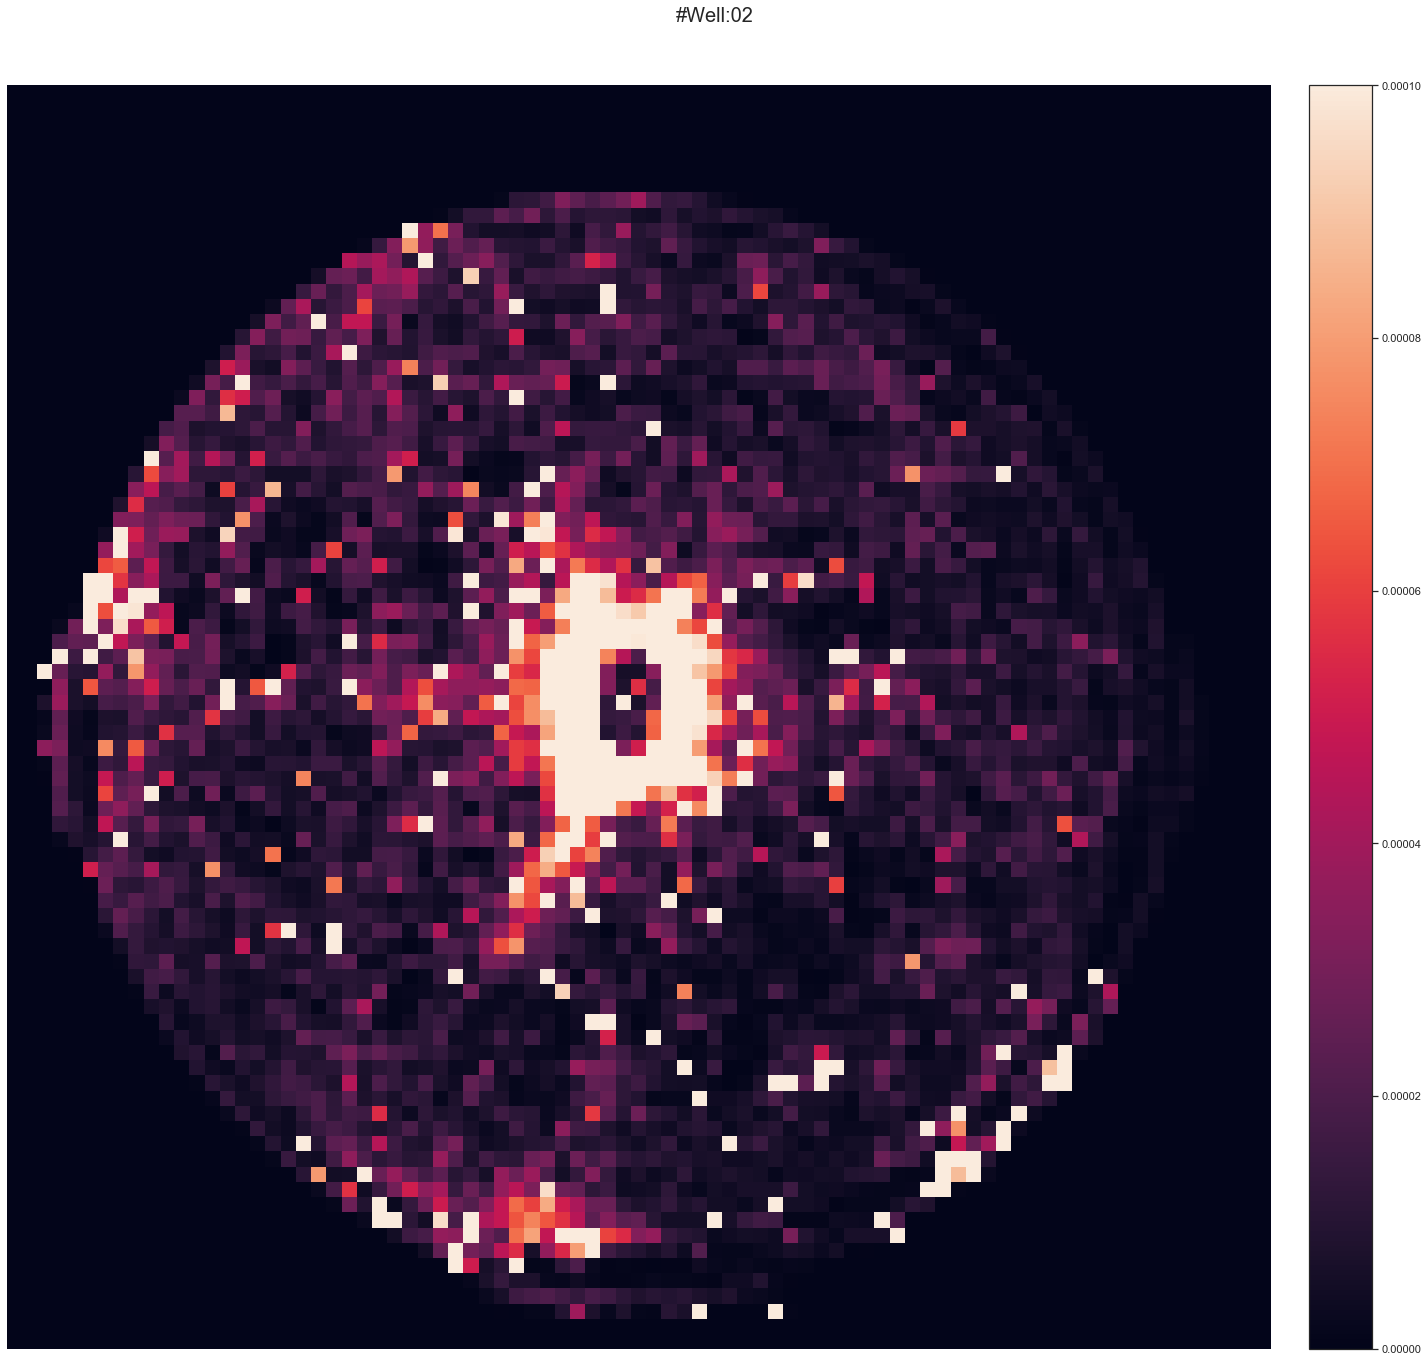

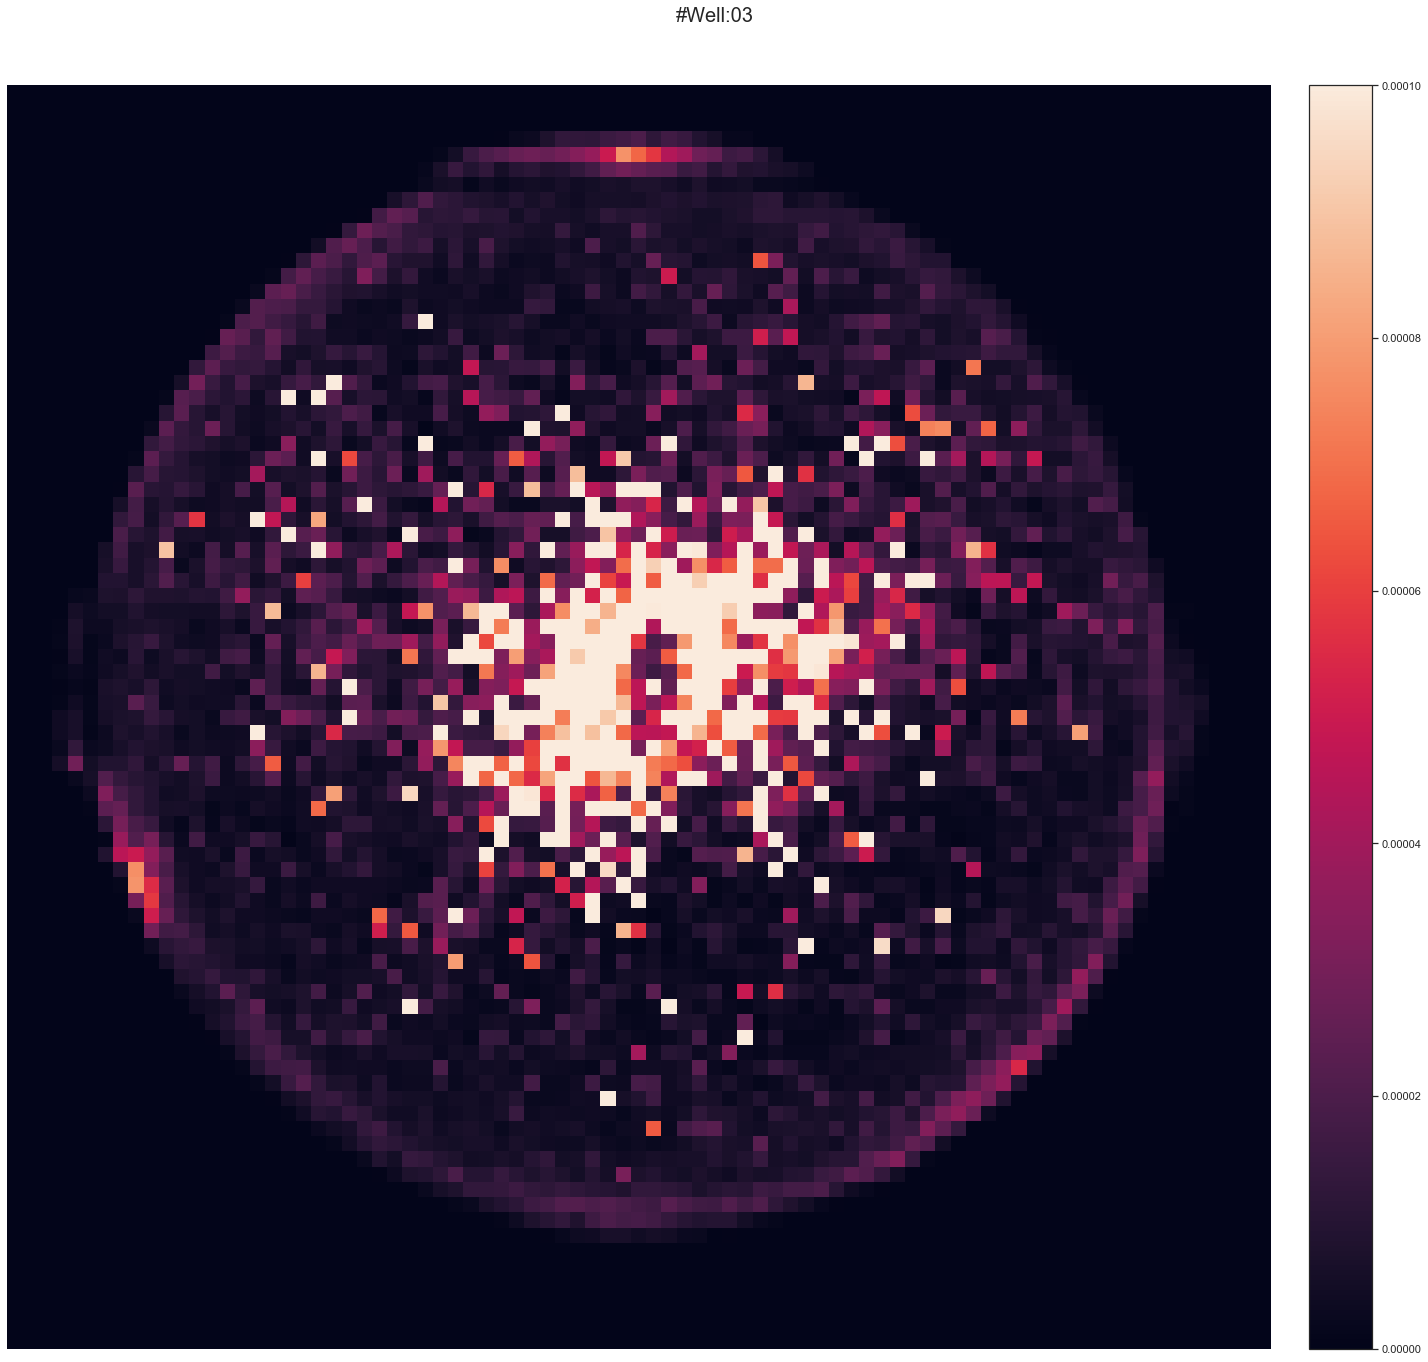

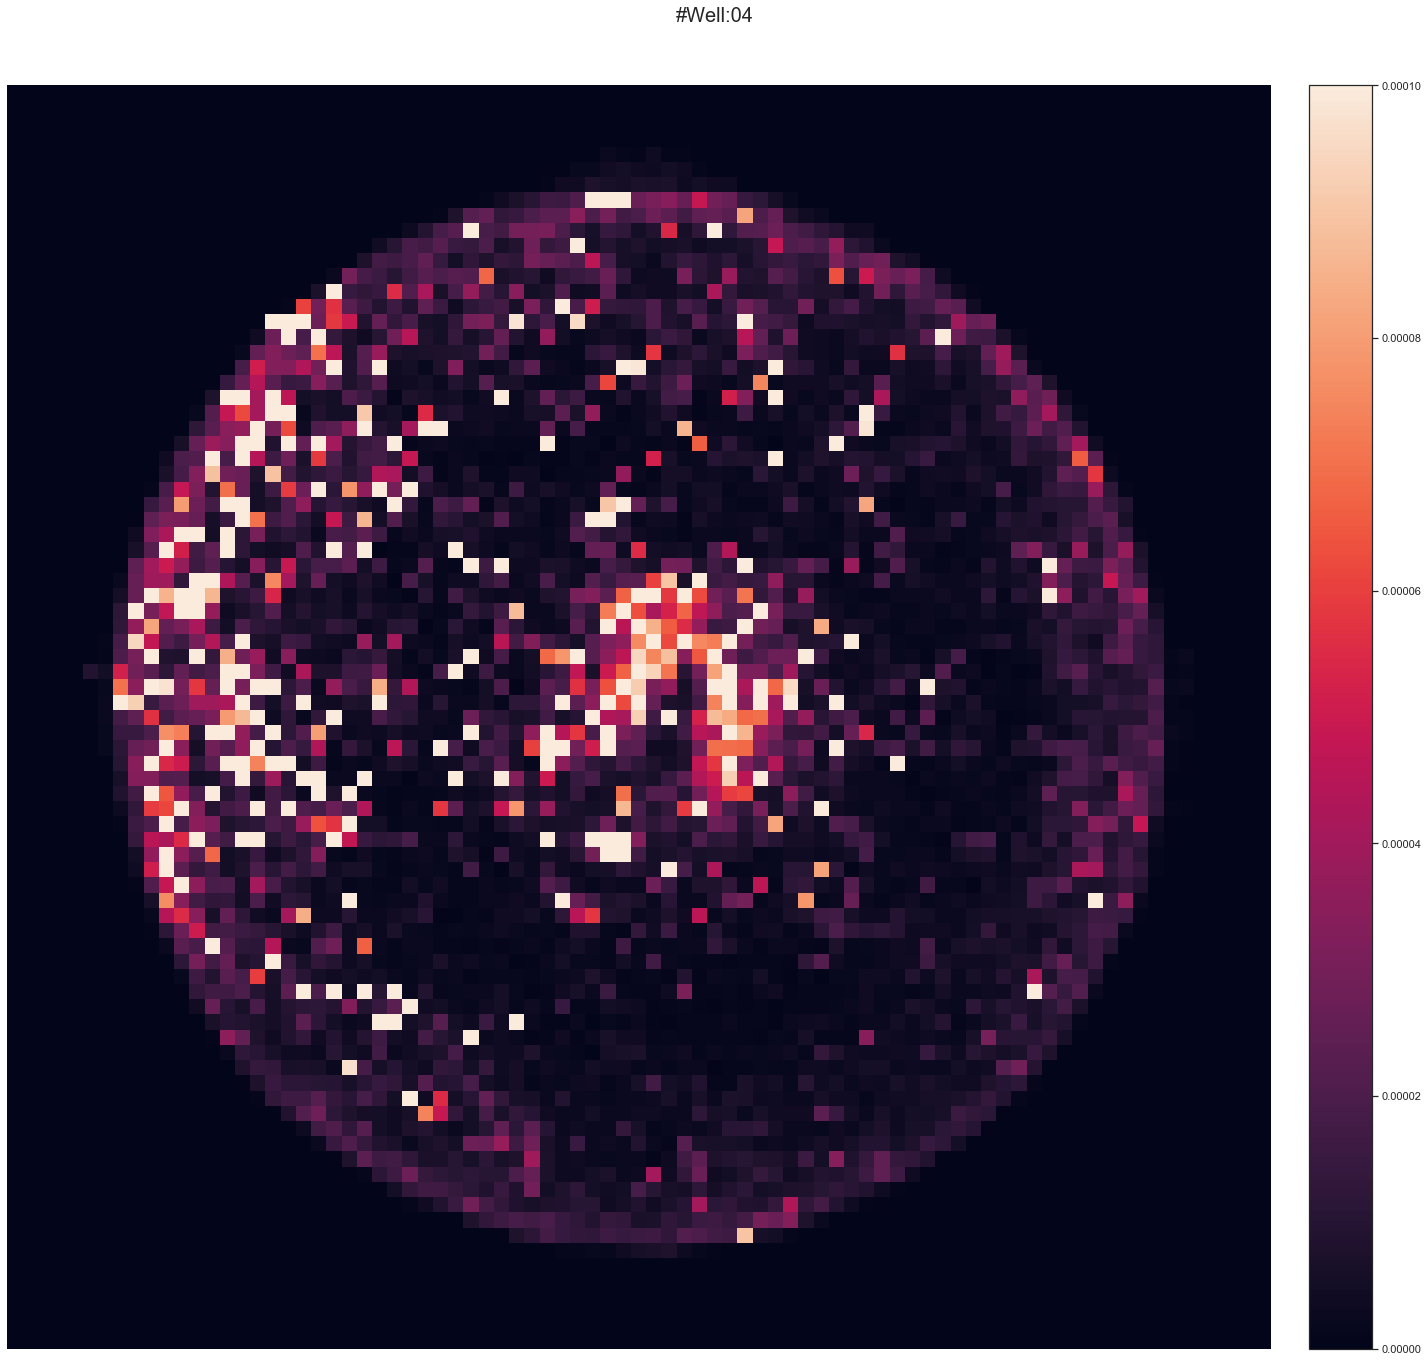

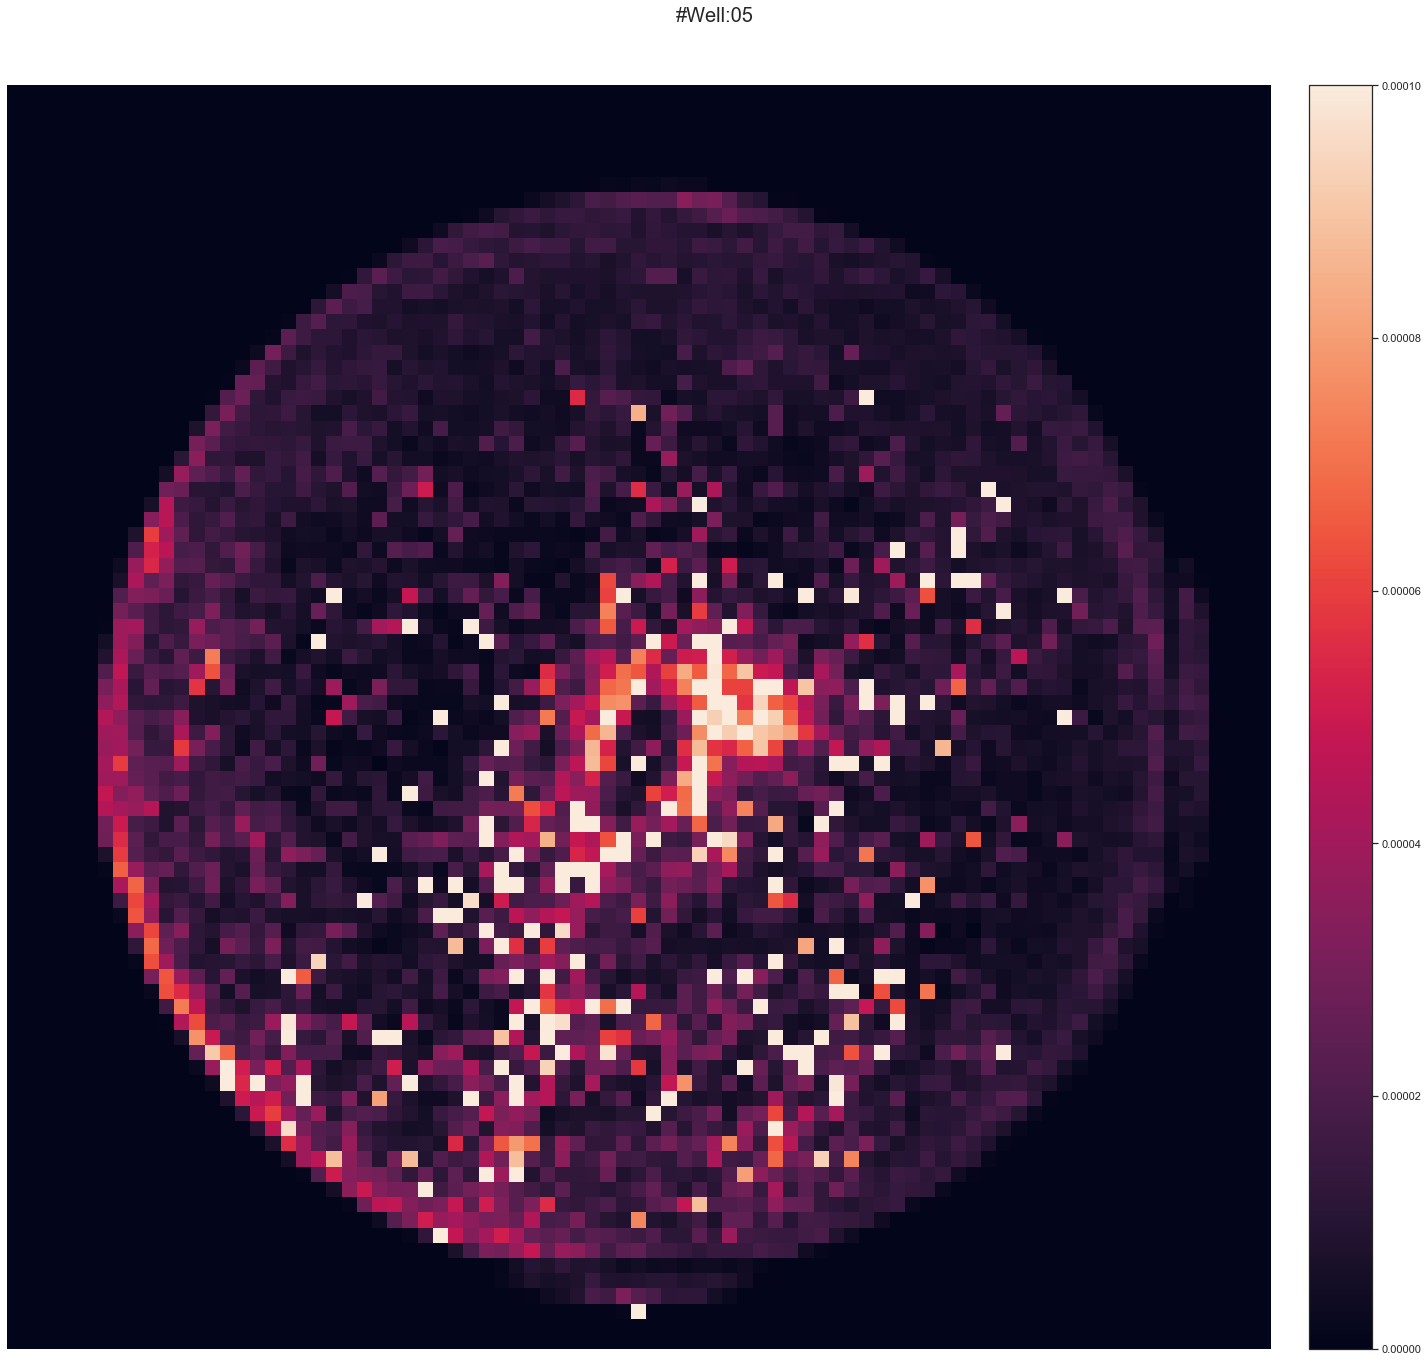

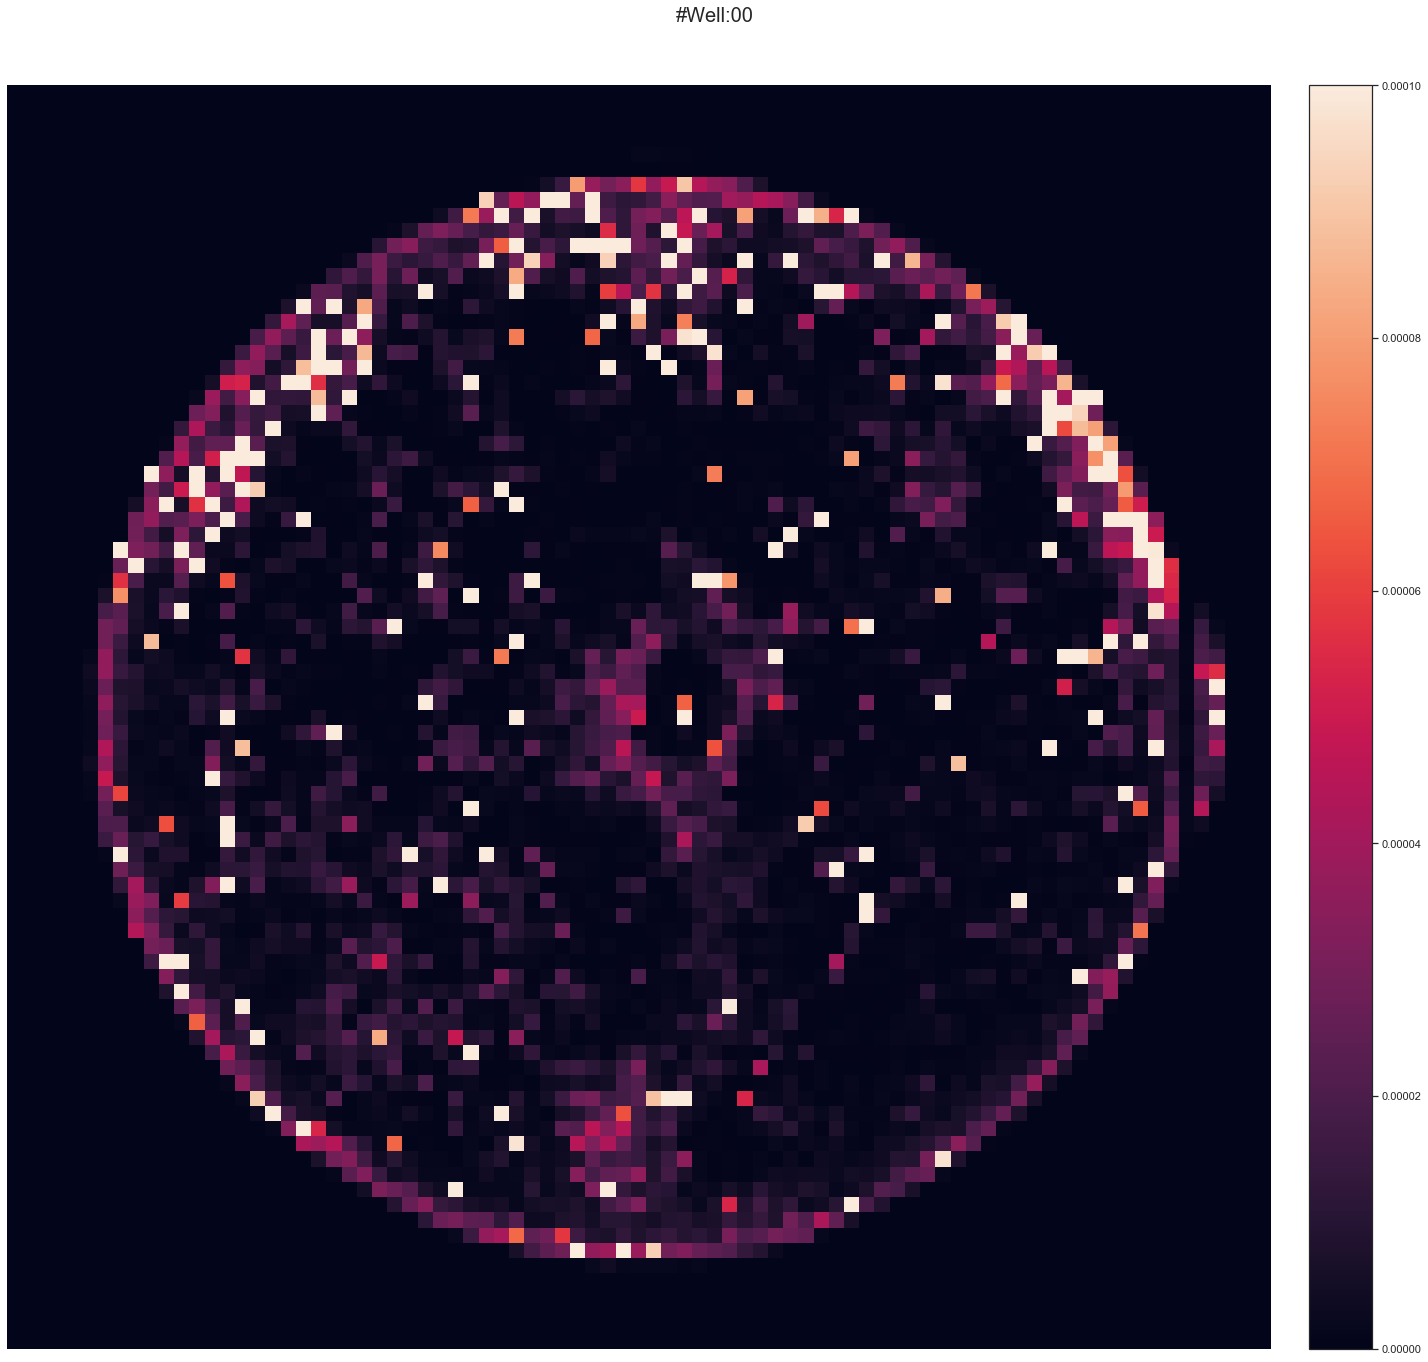

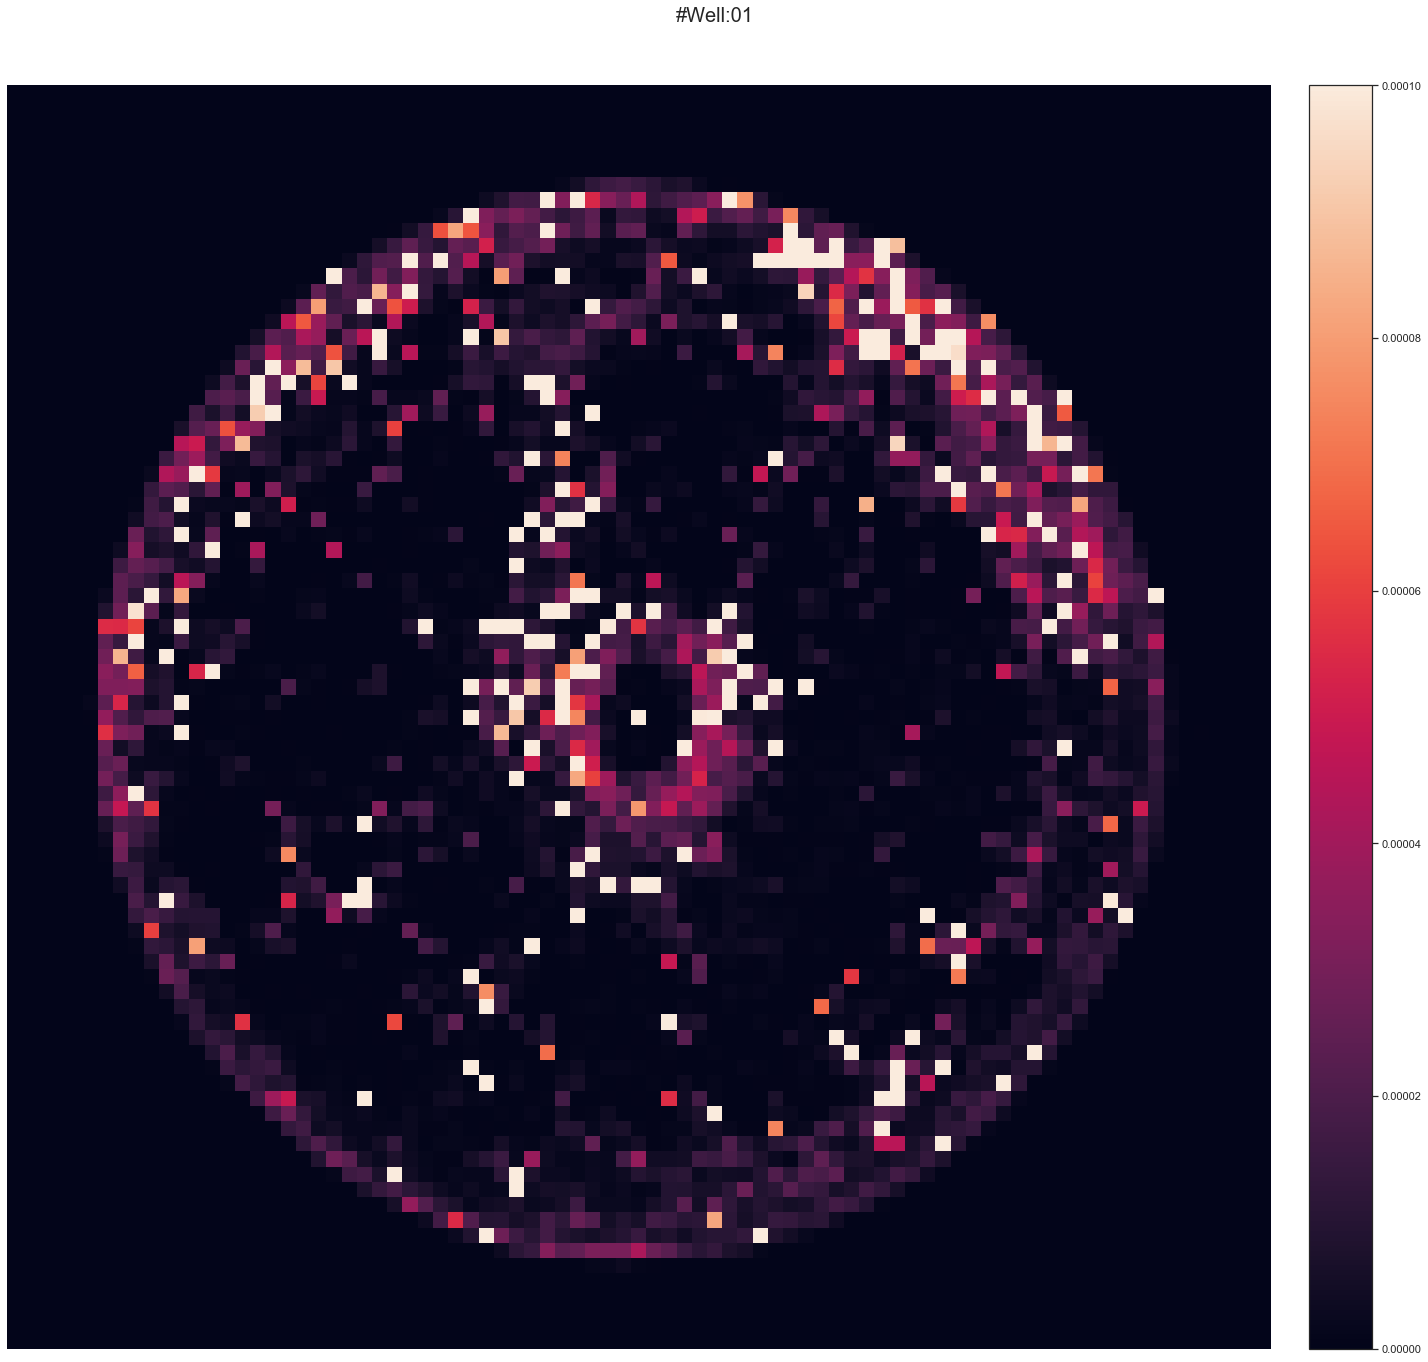

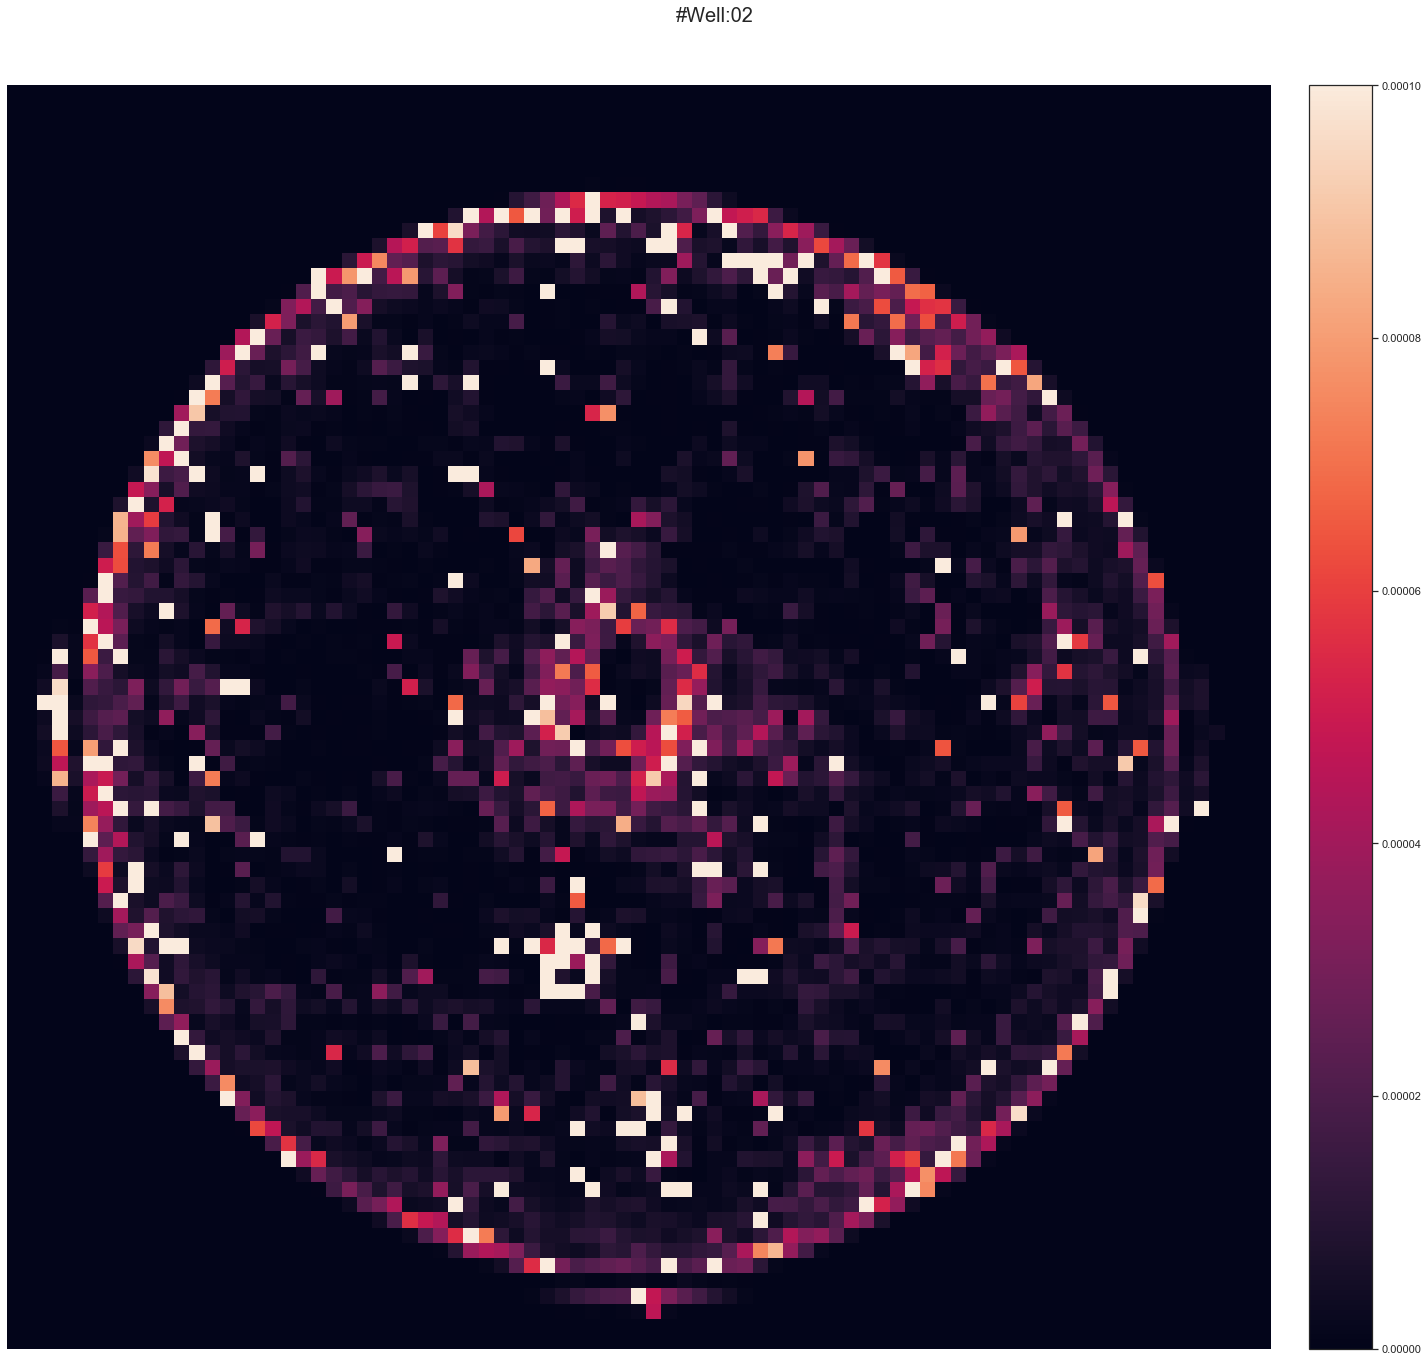

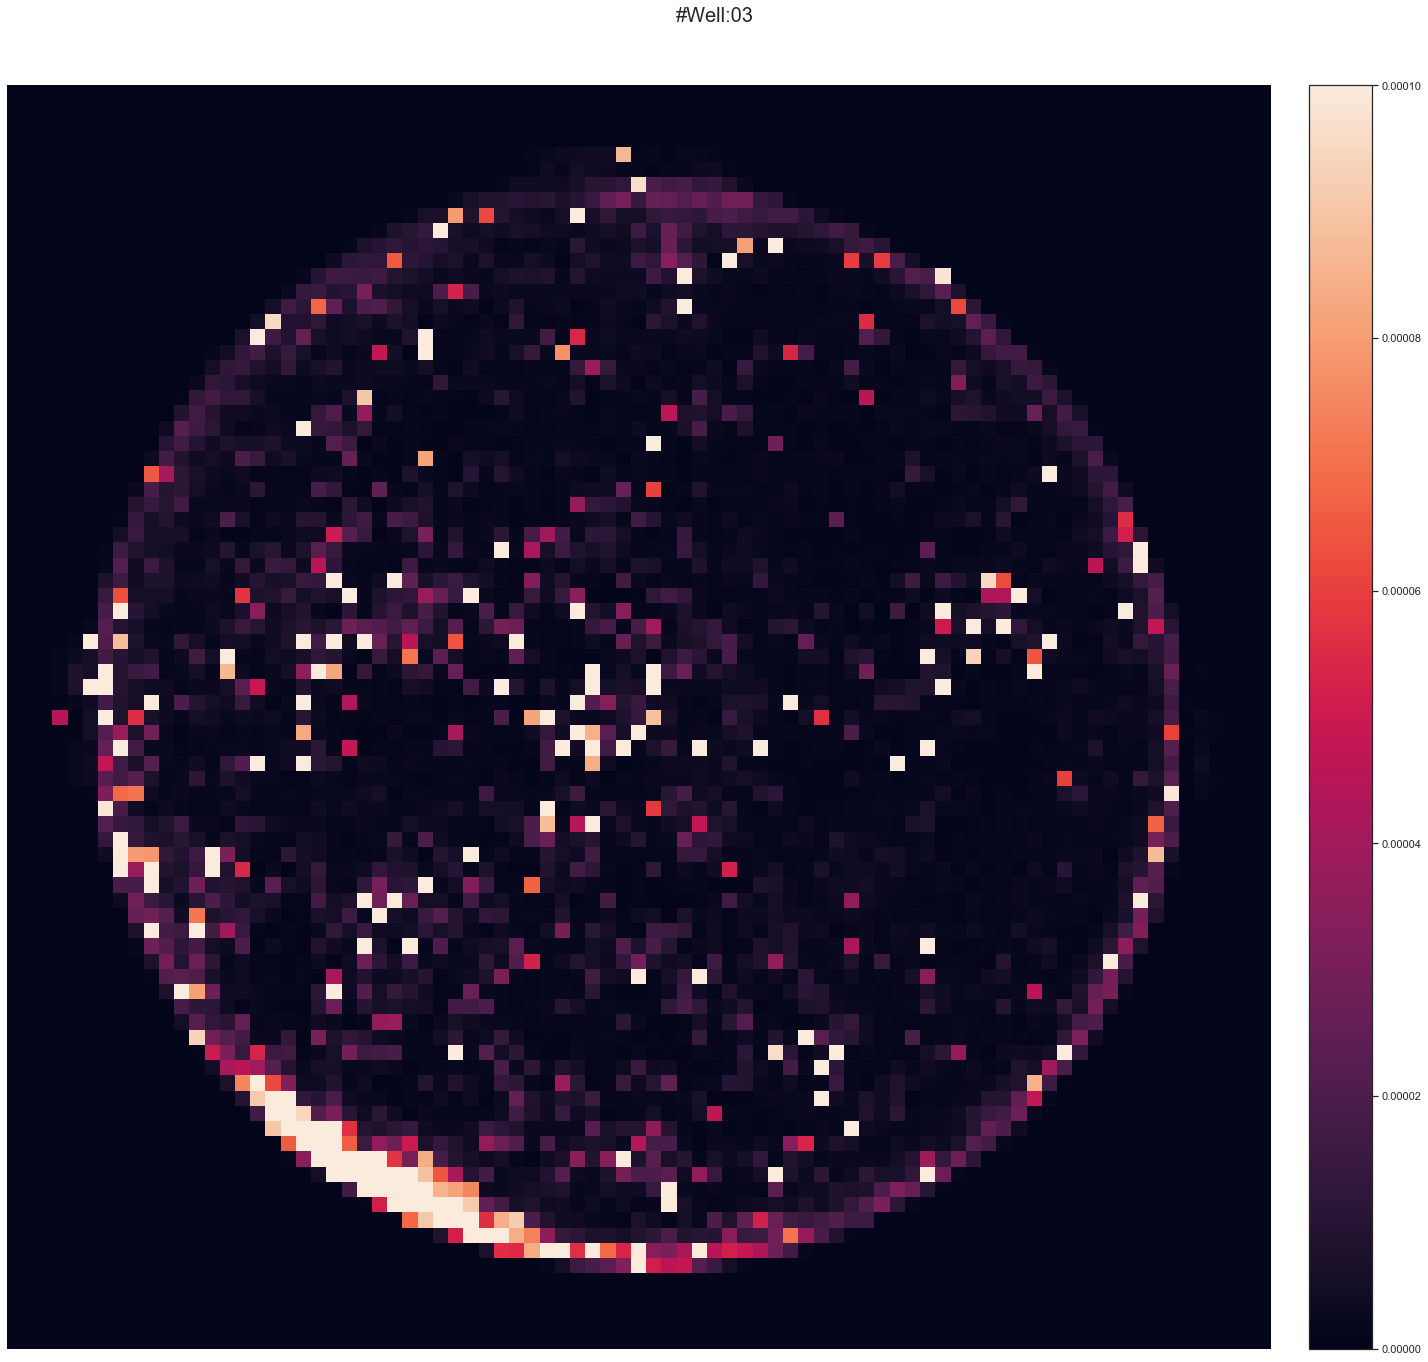

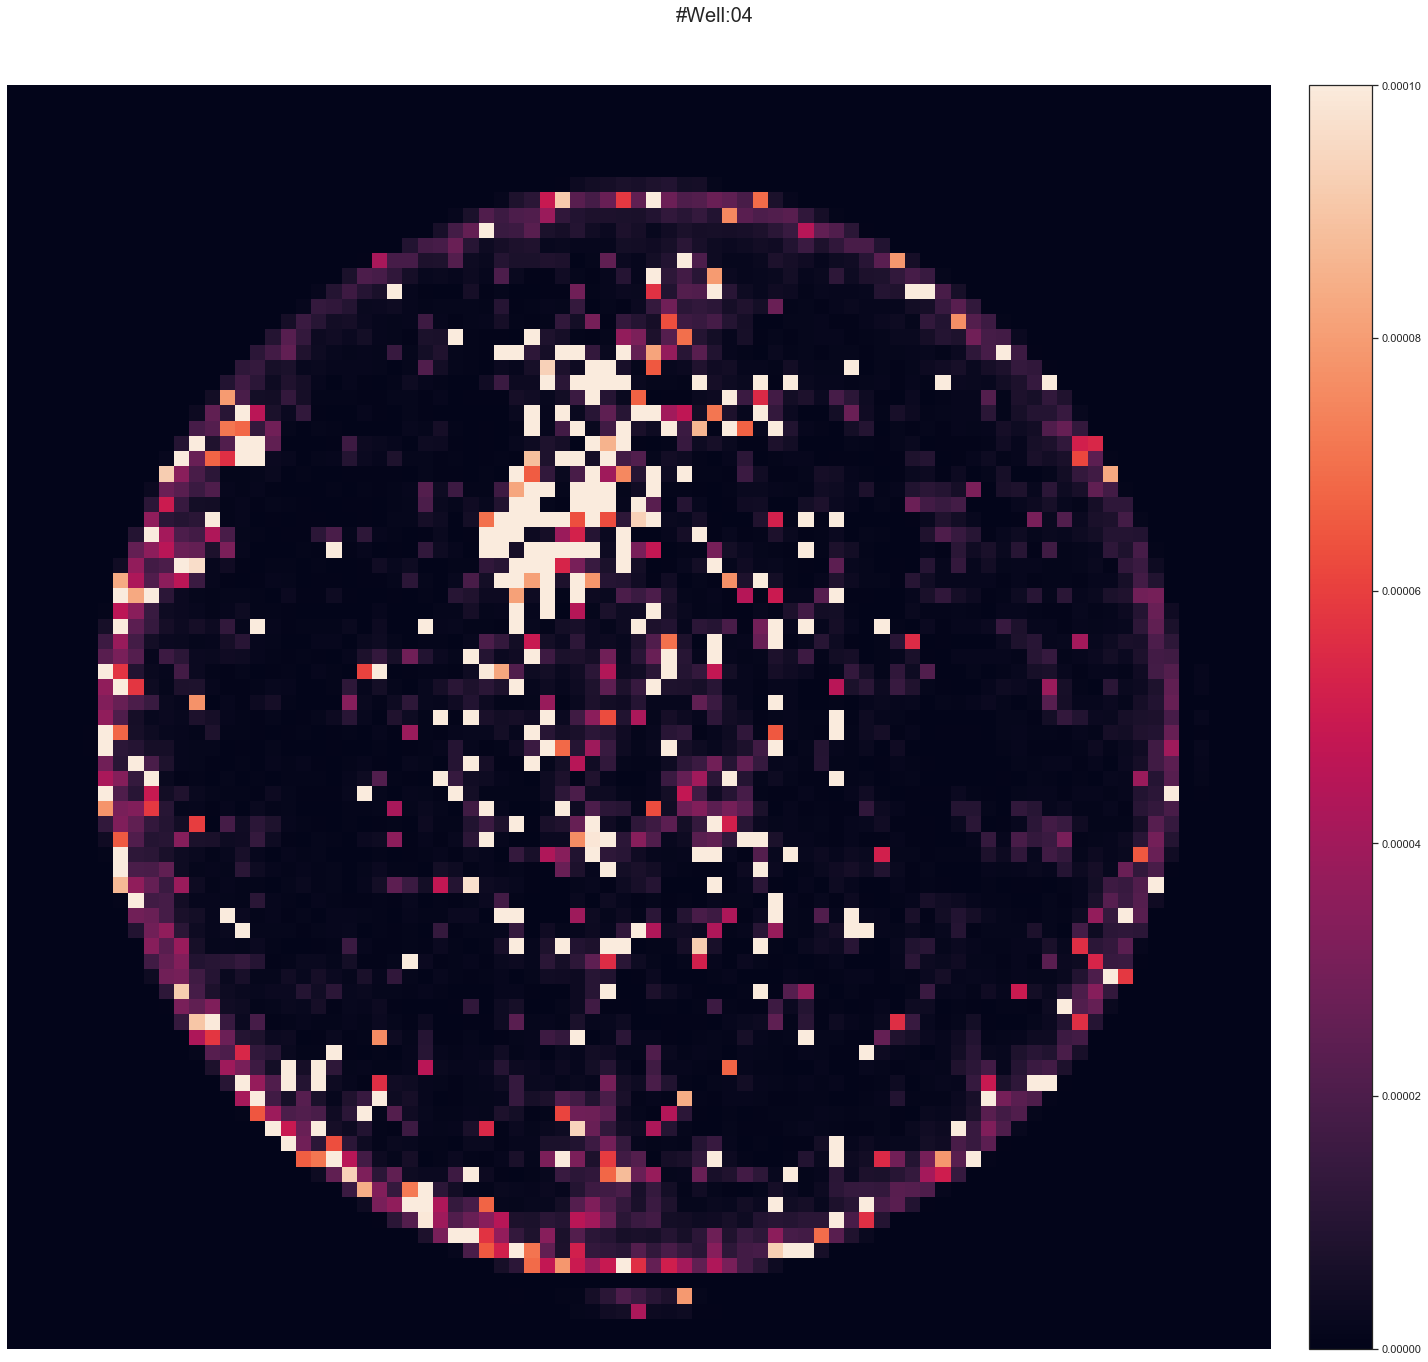

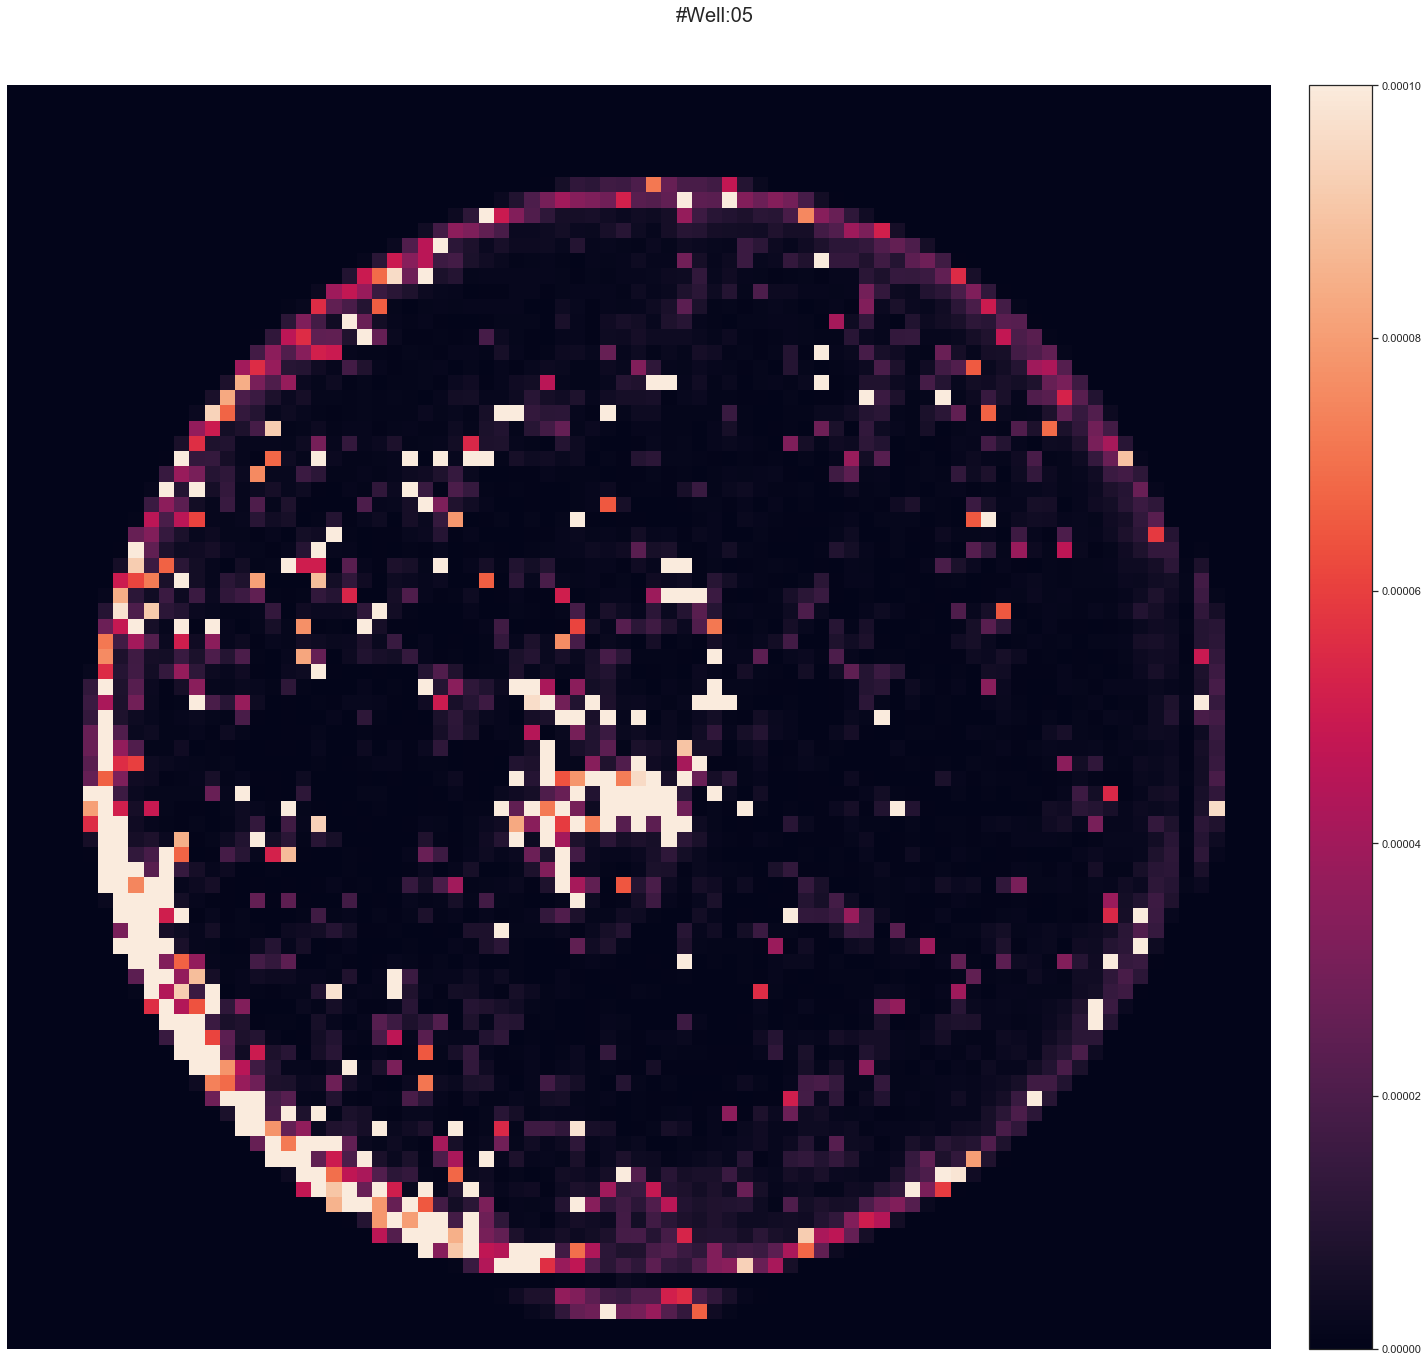


done.


In [8]:
tr_movies = [
            'MOG2',
            #'bg_MOG2',
            #'mdbg_MOG2',
            #'md_MOG2'
            ]

# eclosionの目視判定
eclo_time = {
            'w1118_1' : ['17:00:09', '19:53:18', '19:47:58', '21:24:47', '15:24:38', '19:39:20'],
            'w1118_2' : ['4:48:24', '20:1:57', '21:46:3', '5:17:2', '15:31:9','11:24:14'],
            'w1118_3' : ['2:17:11','2:30:46','21:0:15','20:18:22','14:50:57','2:35:20'],
            'OrR_1'   : ['3:17:17', '14:19:58', '11:32:9', '6:52:35', '11:29:47', '3:39:6'], 
            'OrR_2'   : ['11:19:30', '9:39:54', '10:2:29', '11:46:19', '9:49:48', '9:11:44'],
            'OrR_3'   : ['8:27:54','7:35:22','8:25:0','0:31:12','11:30:37','9:13:10'],
            'CS_1'    : ['12:9:6', '16:53:56', '14:16:44', '16:12:37', '13:11:6', '18:30:31'],
            'CS_2'    : ['16:11:28', '9:15:34', '0:0:0', '12:47:55', '13:42:40', '14:27:52'],
            'CS_3'    : ['12:5:21','12:44:23','6:41:34','11:26:11','11:6:31','8:3:1'],
            }


# 被接近対象の半径Xピクセル内に進入した回数をカウント
def count_entering(dl,dr,thre):
    ind1=np.where(dl<=thre)[0]
    ind2=np.where(dr<=thre)[0]
    x=np.zeros(len(dl))
    x[ind1]=1
    x[ind2]=-1
    n1=len(ind1)
    n2=len(ind2)
    return x,n1,n2

# グラフの整形のためのもの
def set_fontsize(ax,fontsize):
    itemsx=ax.get_xticklabels()
    itemsy=ax.get_yticklabels()
    for i in range(len(itemsx)):
        itemsx[i].set_fontsize(fontsize)
    for i in range(len(itemsy)):
        itemsy[i].set_fontsize(fontsize)

for target in tqdm(targets):
    data_dir = datasets[target]
    
    file_path = os.path.join("{}/{}/csv".format(server_data, data_dir))
    file_path1 = os.path.join("{}/{}/csv".format(local_data, data_dir))
    fs_dis = np.loadtxt("{}/fs_disper.csv".format(file_path1), delimiter=",")
    
    with open(os.path.join(server_data, data_dir, 'mask_params.json')) as f:
        params = json.load(f)
    
    x = params['n-rows']
    y = params['n-clms']
    xlen = params['well-w']
    ylen = params['well-h']
    X = params['x']
    Y = params['y']

    mv_num = len(movies[target])
    #mv_num = 2
    
    wnum = x*y
    
    data_dir = datasets[target]
    tar_mv = movies[target][1]

    tar_path = os.path.join('{}/{}/{}.mp4'.format(server_data, data_dir, tar_mv))

    # 前景用動画読み込みの設定
    movie = cv2.VideoCapture(tar_path)

    # 動画ファイル保存用の設定
    fps = int(movie.get(cv2.CAP_PROP_FPS))                         # 動画のFPSを取得
    
    #fps=3
    eclo_frames=np.zeros(wnum)
    for eclo in range(len(eclo_time[target])):
        tmp=eclo_time[target][eclo]
        h,m,s=tmp.split(':')
        hs=np.int(h)*3600
        ms=np.int(m)*60
        ss=np.int(s)
        alls=hs+ms+ss
        eclo_frames[eclo]=alls*fps
    
    fs_dis = fs_dis.reshape(x*y, 2, 1)

    dl_mean=np.zeros(wnum)
    dl_std=np.zeros(wnum)
    dr_mean=np.zeros(wnum)
    dr_std=np.zeros(wnum)
    distances=pd.DataFrame()

    n1s=np.array([])
    n2s=np.array([])

    # グラフ描画の範囲指定    
    dt_pre=3600*1 # eclosionから前1時間分
    dt_post=3600*20 # eclosion後20時間分
    dframe_pre=dt_pre*fps
    dframe_post=dt_post*fps

    disp_short=0
    # ********************************************
    #x = 1
    #y = 1
    cntr=0
    arr_all=np.array([])
    icntr=0
    for i in tqdm(range(x)): # for image placement
        arrs=np.array([])
        jcntr=0    
        for j in tqdm(range(y)): # for image placement
            fig = plt.figure(figsize=(20,20))
            #G = np.loadtxt(os.path.join(file_path, 'dispersion3/well{:03}.csv'.format(cntr)), delimiter=",")
            G = np.loadtxt(os.path.join(file_path1, 'dispersion/well{:03}.csv'.format(cntr)), delimiter=",")
            disp_range=[eclo_frames[cntr]-dframe_pre,eclo_frames[cntr]+dframe_post]
            if disp_short==1:
                f1=np.int(disp_range[0])
                f2=np.int(disp_range[1])
            else:
                f1=0
                f2=len(G)

            wellnum=str(cntr).zfill(2)
            #fname=h+wellnum+'.csv'
            #dat=pd.read_csv(fname,header=None)
            #data=pd.DataFrame(dat.values,columns=['y-coord','x-coord'])

            oy,ox=G.T

            #ox=grav['center_x'].values
            #oy=grav['center_y'].values

            maxt=len(ox)
            sns.set(style="white", color_codes=True)

            xs=range(len(ox))
            # ***** Visualization *****
            #sns.jointplot(x='x-coord', y='y-coord', data=data, kind='kde') #kind=kde,hex
            fontsize=18

            # 保存先がそのままだと画像が上書きされるので注意！! 下の fname も変更
            if 1: # 滞在の時間分布の図を描画したい場合ここを1に。
                #ax=sns.jointplot(x=ox[::10],y=oy[::10],
                #                 xlim=(10,210),ylim=(10,210),kind='kde')
                #fig = plt.figure()
                ax = fig.add_subplot(111)

                H = ax.hist2d(ox[f1:f2],oy[f1:f2], 
                              bins=[np.linspace(0,210,84),np.linspace(0,210,84)],
                              normed=True)
                #ax.set_xlabel('x')
                #ax.set_ylabel('y')
                divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
                cax = divider.append_axes('right', '5%', pad='3%')             
                ax.axis("off")
                H[3].set_clim(0,1e-4)
                ax.set_aspect('equal')
                fig.colorbar(H[3],cax=cax)
                #cbar.set_label("color bar", fontname="Times New Roman", fontsize=10)

                #plt.title('#Well:'+wellnum,fontsize=fontsize)


            else: # 以下は様々な統計を描画               
                bias_thre=0.5 # Bias value

                # *** 1st row ***            
                c='blue'
                ax=plt.subplot2grid((3,6),(0,0),colspan=4)
                lp=plt.plot(xs[f1:f2], bias.values[f1:f2], color=c)
                plt.plot(xs[f1:f2], np.zeros(f2-f1), color='black')
                plt.plot(xs[f1:f2], np.ones(f2-f1)*bias_thre, color='black',alpha=0.5)
                plt.plot(xs[f1:f2], np.ones(f2-f1)*(-bias_thre), color='black',alpha=0.5)
                plt.xlim((-1,maxt+1))
                plt.ylim((-1.05,1.05))
                plt.plot([eclo_frames[cntr],eclo_frames[cntr]],[-1.05,1.05])
                plt.title('#Well:'+wellnum+'     Bias',fontsize=fontsize)
                set_fontsize(ax,fontsize)
                if disp_short==1:
                    plt.xlim(disp_range)

                ax=plt.subplot2grid((3,6),(0,4))
                plt.hist(bias.values[f1:f2],bins=50,range=(-1.0,1.0),orientation='horizontal',color=c)
                plt.title('Hist dr',fontsize=fontsize)
                plt.ylim(-1.05,1.05)
                set_fontsize(ax,fontsize)
                ax.set_yticklabels([])
                xl=ax.get_xlim()


                ax=plt.subplot2grid((3,6),(0,5))
                plt.bar([0,1],[np.mean(dl[f1:f2]),np.mean(dr[f1:f2])],color=c)
                ax.set_xticks([0,1])
                ax.set_xticklabels(['dL','dR'],fontsize=fontsize)
                plt.title('Average',fontsize=fontsize)
                set_fontsize(ax,fontsize)
                '''
                save_dir = os.path.join("{file_path1}/bias3".format(local_data, data_dir))
                os.makedirs(save_dir, exist_ok=True)
                np.savetxt("{}/well{:03}.csv".format(save_dir,cntr), bias.values, fmt="%f", delimiter=",") 
                '''

                # *** 2st row ***
                c='red'
                ind1=np.where(bias.values[f1:f2]>=bias_thre)[0]
                ind2=np.where(bias.values[f1:f2]<=-bias_thre)[0]
                n1=len(ind1)
                n2=len(ind2)

                biasmod=np.copy(bias.values[f1:f2])
                ind=np.where((biasmod<bias_thre)&(biasmod>(-bias_thre)))[0]
                biasmod[ind]=0.0

                plotdata=np.cumsum(biasmod)
                ymax=np.max(np.abs(plotdata))
                ax=plt.subplot2grid((3,6),(1,0),colspan=4)
                lp=plt.plot(xs[f1:f2], plotdata, color=c,linewidth=3)
                plt.plot(xs, np.zeros(len(xs)), color='black')
                plt.ylim([-ymax*1.1,ymax*1.1])
                plt.plot([eclo_frames[cntr],eclo_frames[cntr]],[-ymax*1.1,ymax*1.1],
                         color='k',linewidth=3)
                plt.xlim((-1,maxt+1))
                plt.title('Cumsum of Bias exceeding thre',fontsize=fontsize)
                set_fontsize(ax,fontsize)
                if disp_short==1:
                    plt.xlim(disp_range)


                ax=plt.subplot2grid((3,6),(1,4))
                plt.hist(np.r_[biasmod[ind1],biasmod[ind2]],bins=50,range=(-1.0,1.0),orientation='horizontal',color=c)
                set_fontsize(ax,fontsize)
                ax.set_xlim(xl)

                ax=plt.subplot2grid((3,6),(1,5))
                plt.bar([0,1],[n1,n2],color=c)
                ax.set_xticks([0,1])
                ax.set_xticklabels(['High','Low'],fontsize=fontsize)
                plt.title('Count',fontsize=fontsize)
                set_fontsize(ax,fontsize)
                '''
                save_dir = os.path.join("{file_path1}/th_bias3".format(local_data, data_dir))
                os.makedirs(save_dir, exist_ok=True)
                np.savetxt("{}/well{:03}.csv".format(save_dir,cntr), plotdata, fmt="%f", delimiter=",")
                '''

                # *** 3rd row ***
                thres=[15,20,25]
                if cntr==0:
                    onset_frames=np.zeros((wnum,len(thres)))
                xx=np.zeros((len(thres),len(dl)))
                nn1=np.zeros(len(thres))
                nn2=np.zeros(len(thres))
                for ii in range(len(thres)):
                    xx[ii,:],nn1[ii],nn2[ii]=count_entering(dl[f1:f2],dr[f1:f2],thres[ii])
                if cntr==0:
                    n1s=nn1
                    n2s=nn2
                else:
                    n1s=np.c_[n1s,nn1]
                    n2s=np.c_[n2s,nn2]

                cs=['green','magenta','cyan']
                ax=plt.subplot2grid((3,6),(2,0),colspan=4)
                if 0:
                    for ii in range(len(thres)):
                        d=np.cumsum(xx[ii])
                        lp=plt.plot(xs, d, color=cs[ii],linewidth=3)
                        enter_count_thre=600*fps
                        ind=np.where(d>enter_count_thre)[0]
                        if len(ind)==0:
                            onset_frames[cntr,ii]=0
                        else:
                            onset_frames[cntr,ii]=ind[0]
                else:
                    tmpmax=np.zeros_like(thres)
                    for ii in range(len(thres)):
                        d=np.cumsum(xx[ii])
                        ind_l=np.where(xx[ii]==+1)[0]
                        ind_r=np.where(xx[ii]==-1)[0]

                        lv,b=np.histogram(ind_l,bins=range(0,f2-f1,2000))
                        #plt.plot(b[:-1],lv,linewidth=3,color=cs[ii])
                        rv,b=np.histogram(ind_r,bins=range(0,f2-f1,2000))
                        #plt.plot(b[:-1],-rv,linewidth=3,color=cs[ii])
                        #plt.plot(b[:-1],-rv+lv,linewidth=3,color=cs[ii])
                        tmpmax[ii]=np.max([np.max(np.abs(lv)),np.max(np.abs(rv))])

                        plotdata=np.cumsum(-rv+lv)
                        plt.plot(b[:-1],np.cumsum(-rv+lv),linewidth=3,color=cs[ii])
                        tmpmax[ii]=np.max(np.abs(plotdata))


                        enter_count_thre=600*fps
                        ind=np.where(d>enter_count_thre)[0]
                        if len(ind)==0:
                            onset_frames[cntr,ii]=0
                        else:
                            onset_frames[cntr,ii]=ind[0]

                #ymax=np.max(np.abs(np.cumsum(xx[-1])))
                ymax=np.max(tmpmax)
                plt.plot(xs, np.zeros(len(xs)), color='black')
                plt.ylim([-ymax*1.1,ymax*1.1])
                for ii in range(len(thres)):        
                    plt.plot([onset_frames[cntr,ii],onset_frames[cntr,ii]],
                             [-ymax*1.1,ymax*1.1],color=cs[ii],linewidth=3)

                plt.plot([eclo_frames[cntr],eclo_frames[cntr]],[-ymax*1.1,ymax*1.1],
                        color='k',linewidth=3)
                plt.xlim((-1,maxt+1))
                plt.title('Cumsum of count entering circle (G:15,M:20,C:25 pixel)',
                          fontsize=fontsize)
                set_fontsize(ax,fontsize)
                if disp_short==1:
                    plt.xlim(disp_range)


                yl=np.max([np.max(nn1),np.max(nn2)])*1.1
                for ii in range(len(thres)):
                    ax=plt.subplot2grid((3,9),(2,6+ii))
                    plt.bar([0,1],[nn1[ii],nn2[ii]],color=cs[ii])
                    set_fontsize(ax,fontsize)
                    ax.set_xticks([0,1])
                    ax.set_xticklabels(['L','R'],fontsize=fontsize)
                    ax.set_ylim([0,yl])


            #sys.exit()
            # *************************
            
            # 滞在分布を出力する時はここも１に
            if 1:
                fname = os.path.join(local_data,data_dir,'img2')
            else:
                fname = os.path.join(local_data,data_dir,'th2_img')
            os.makedirs(fname, exist_ok=True)
            imfname = fname+'/well{}.png'.format(wellnum)
            plt.savefig(imfname)
            arr=np.array(Image.open(imfname))
            if jcntr==0: arrs=arr
            else: arrs=np.hstack((arrs,arr))
            jcntr+=1

            plt.suptitle('#Well:'+wellnum,verticalalignment='bottom',fontsize=20)        

            plt.tight_layout()
            plt.show()

            cntr+=1
        if icntr==0: arr_all=arrs
        else: arr_all=np.vstack((arr_all,arrs))
        icntr+=1

    pil_img = Image.fromarray(arr_all)
    pil_img.save(os.path.join(fname,'img-summary.png'))
    
#plt.figure(figsize=(15, 15))
#ax = sns.violinplot(x=distances['well'], y=pkmn["dr"], split=True) 

print('done.')

In [4]:
tr_movies = [
            'MOG2',
            #'bg_MOG2',
            #'mdbg_MOG2',
            #'md_MOG2'
            ]

# eclosionの目視判定
eclo_time = {
            'w1118_1' : ['17:00:09', '19:53:18', '19:47:58', '21:24:47', '15:24:38', '19:39:20'],
            'w1118_2' : ['4:48:24', '20:1:57', '21:46:3', '5:17:2', '15:31:9','11:24:14'],
            'w1118_3' : ['2:17:11','2:30:46','21:0:15','20:18:22','14:50:57','2:35:20'],
            'OrR_1'   : ['3:17:17', '14:19:58', '11:32:9', '6:52:35', '11:29:47', '3:39:6'], 
            'OrR_2'   : ['11:19:30', '9:39:54', '10:2:29', '11:46:19', '9:49:48', '9:11:44'],
            'OrR_3'   : ['8:27:54','7:35:22','8:25:0','0:31:12','11:30:37','9:13:10'],
            'CS_1'    : ['12:9:6', '16:53:56', '14:16:44', '16:12:37', '13:11:6', '18:30:31'],
            'CS_2'    : ['16:11:28', '9:15:34', '0:0:0', '12:47:55', '13:42:40', '14:27:52'],
            'CS_3'    : ['12:5:21','12:44:23','6:41:34','11:26:11','11:6:31','8:3:1'],
            }


# 被接近対象の半径Xピクセル内に進入した回数をカウント
def count_entering(dl,dr,thre):
    ind1=np.where(dl<=thre)[0]
    ind2=np.where(dr<=thre)[0]
    x=np.zeros(len(dl))
    x[ind1]=1
    x[ind2]=-1
    n1=len(ind1)
    n2=len(ind2)
    return x,ind1,ind2,n1,n2

# グラフの整形のためのもの
def set_fontsize(ax,fontsize):
    itemsx=ax.get_xticklabels()
    itemsy=ax.get_yticklabels()
    for i in range(len(itemsx)):
        itemsx[i].set_fontsize(fontsize)
    for i in range(len(itemsy)):
        itemsy[i].set_fontsize(fontsize)

for target in tqdm(targets):
    data_dir = datasets[target]
    
    file_path = os.path.join("{}/{}/csv".format(server_data, data_dir))
    file_path1 = os.path.join("{}/{}/csv".format(local_data, data_dir))
    fs_dis = np.loadtxt("{}/fs_disper.csv".format(file_path1), delimiter=",")
    
    with open(os.path.join(server_data, data_dir, 'mask_params.json')) as f:
        params = json.load(f)
    
    x = params['n-rows']
    y = params['n-clms']
    xlen = params['well-w']
    ylen = params['well-h']
    X = params['x']
    Y = params['y']

    mv_num = len(movies[target])
    #mv_num = 2
    
    wnum = x*y
    
    data_dir = datasets[target]
    tar_mv = movies[target][1]

    tar_path = os.path.join('{}/{}/{}.mp4'.format(server_data, data_dir, tar_mv))

    # 前景用動画読み込みの設定
    movie = cv2.VideoCapture(tar_path)

    # 動画ファイル保存用の設定
    fps = int(movie.get(cv2.CAP_PROP_FPS))                         # 動画のFPSを取得
    #fps=3
    eclo_frames=np.zeros(wnum)
    for eclo in range(len(eclo_time[target])):
        tmp=eclo_time[target][eclo]
        h,m,s=tmp.split(':')
        hs=np.int(h)*3600
        ms=np.int(m)*60
        ss=np.int(s)
        alls=hs+ms+ss
        eclo_frames[eclo]=alls*fps
    
    fs_dis = fs_dis.reshape(x*y, 2, 3)

    dl_mean=np.zeros(wnum)
    dl_std=np.zeros(wnum)
    dr_mean=np.zeros(wnum)
    dr_std=np.zeros(wnum)
    distances=pd.DataFrame()

    n1s=np.array([])
    n2s=np.array([])

    # グラフ描画の範囲指定    
    dt_pre=3600*1 # eclosionから前1時間分
    dt_post=3600*20 # eclosion後20時間分
    dframe_pre=dt_pre*fps
    dframe_post=dt_post*fps

    disp_short=0
    # ********************************************
    #x = 1
    #y = 1
    cntr=0
    arr_all=np.array([])
    icntr=0
    for i in tqdm(range(y)): # for image placement
        arrs=np.array([])
        jcntr=0    
        for j in tqdm(range(x)): # for image placement
            fig = plt.figure(figsize=(20,20))
            #G = np.loadtxt(os.path.join(file_path, 'dispersion3/well{:03}.csv'.format(cntr)), delimiter=",")
            G = np.loadtxt(os.path.join(file_path1, 'dispersion/well{:03}.csv'.format(cntr)), delimiter=",")
            disp_range=[eclo_frames[cntr]-dframe_pre,eclo_frames[cntr]+dframe_post]
            if disp_short==1:
                f1=np.int(disp_range[0])
                f2=np.int(disp_range[1])
            else:
                f1=0
                f2=len(G)

            wellnum=str(cntr).zfill(2)
            #fname=h+wellnum+'.csv'
            #dat=pd.read_csv(fname,header=None)
            #data=pd.DataFrame(dat.values,columns=['y-coord','x-coord'])

            oy,ox=G.T
            lx=fs_dis[cntr,1,0]
            ly=fs_dis[cntr,0,0]
            rx=fs_dis[cntr,1,2]
            ry=fs_dis[cntr,0,2]

            #ox=grav['center_x'].values
            #oy=grav['center_y'].values

            dl=((ox-lx)**2+(oy-ly)**2)**0.5
            dr=((ox-rx)**2+(oy-ry)**2)**0.5

            #dl=((dat.values[:,0]-target_loc[cntr,0])**2+(dat.values[:,1]-target_loc[cntr,1])**2)**0.5
            #dr=((dat.values[:,0]-target_loc[cntr,2])**2+(dat.values[:,1]-target_loc[cntr,3])**2)**0.5

            dl_mean[cntr]=np.mean(dl)
            dl_std[cntr]=np.std(dl)
            dr_mean[cntr]=np.mean(dr)
            dr_std[cntr]=np.std(dr)

            w=np.ones(dl.size)*cntr
            df=pd.DataFrame(np.c_[dl,dr,w],columns=['dl','dr','well'])
            distances=pd.concat([distances,df])

            bias=(dl-dr)/(dl+dr)
            bias=pd.Series(bias)
            #bias=bias.rolling(window=30).mean()

            maxt=len(ox)
            sns.set(style="white", color_codes=True)

            xs=range(len(ox))
            # ***** Visualization *****
            #sns.jointplot(x='x-coord', y='y-coord', data=data, kind='kde') #kind=kde,hex
            fontsize=18

            # 保存先がそのままだと画像が上書きされるので注意！! 下の fname も変更
            if 0: # 滞在の時間分布の図を描画したい場合ここを1に。
                #ax=sns.jointplot(x=ox[::10],y=oy[::10],
                #                 xlim=(10,210),ylim=(10,210),kind='kde')
                #fig = plt.figure()
                ax = fig.add_subplot(111)

                H = ax.hist2d(ox[f1:f2],oy[f1:f2], 
                              bins=[np.linspace(0,210,84),np.linspace(0,210,84)],
                              normed=True)
                #ax.set_xlabel('x')
                #ax.set_ylabel('y')
                divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
                cax = divider.append_axes('right', '5%', pad='3%')             
                ax.axis("off")
                H[3].set_clim(0,1e-4)
                ax.set_aspect('equal')
                fig.colorbar(H[3],cax=cax)
                #cbar.set_label("color bar", fontname="Times New Roman", fontsize=10)

                #plt.title('#Well:'+wellnum,fontsize=fontsize)


            else: # 以下は様々な統計を描画               
                bias_thre=0.5 # Bias value
                
                # *** 3rd row ***
                thres=[15,20,25,30,35,40]
                if cntr==0:
                    onset_frames=np.zeros((wnum,len(thres)))
                xx=np.zeros((len(thres),len(dl)))
                nn1=np.zeros(len(thres))
                nn2=np.zeros(len(thres))
                for ii in range(len(thres)):
                    xx[ii,:],ind1,ind2,nn1[ii],nn2[ii]=count_entering(dl[f1:f2],dr[f1:f2],thres[ii])
                if cntr==0:
                    n1s=nn1
                    n2s=nn2
                    ind1s=ind1
                    ind2s=ind2
                else:
                    n1s=np.c_[n1s,nn1]
                    n2s=np.c_[n2s,nn2]
                    ind1s=np.r_['0',ind1s,ind1]
                    ind2s=np.r_['0',ind2s,ind2]

                cs=['green','magenta','cyan','orange','gray','gold']
                ax=plt.subplot2grid((3,6),(0,0),colspan=4)
                count_thre = 600
                if 0:
                    for ii in range(len(thres)):
                        d=np.cumsum(xx[ii])
                        lp=plt.plot(xs, d, color=cs[ii],linewidth=3)
                        enter_count_thre=count_thre*fps
                        ind=np.where(d>enter_count_thre)[0]
                        if len(ind)==0:
                            onset_frames[cntr,ii]=0
                        else:
                            onset_frames[cntr,ii]=ind[0]
                else:
                    tmpmax=np.zeros_like(thres)
                    for ii in range(len(thres)):
                        d=np.cumsum(xx[ii])
                        ind_l=np.where(xx[ii]==+1)[0]
                        ind_r=np.where(xx[ii]==-1)[0]

                        lv,b=np.histogram(ind_l,bins=range(0,f2-f1,2000))
                        #plt.plot(b[:-1],lv,linewidth=3,color=cs[ii])
                        rv,b=np.histogram(ind_r,bins=range(0,f2-f1,2000))
                        #plt.plot(b[:-1],-rv,linewidth=3,color=cs[ii])
                        #plt.plot(b[:-1],-rv+lv,linewidth=3,color=cs[ii])
                        tmpmax[ii]=np.max([np.max(np.abs(lv)),np.max(np.abs(rv))])

                        plotdata=np.cumsum(-rv+lv)
                        plt.plot(b[:-1],np.cumsum(-rv+lv),linewidth=3,color=cs[ii])
                        tmpmax[ii]=np.max(np.abs(plotdata))


                        enter_count_thre=count_thre*fps
                        ind=np.where(d>enter_count_thre)[0]
                        if len(ind)==0:
                            onset_frames[cntr,ii]=0
                        else:
                            onset_frames[cntr,ii]=ind[0]

                #ymax=np.max(np.abs(np.cumsum(xx[-1])))
                ymax=np.max(tmpmax)
                plt.plot(xs, np.zeros(len(xs)), color='black')
                plt.ylim([-ymax*1.1,ymax*1.1])
                for ii in range(len(thres)):        
                    plt.plot([onset_frames[cntr,ii],onset_frames[cntr,ii]],
                             [-ymax*1.1,ymax*1.1],color=cs[ii],linewidth=3)

                plt.plot([eclo_frames[cntr],eclo_frames[cntr]],[-ymax*1.1,ymax*1.1],
                        color='k',linewidth=3)
                plt.xlim((-1,maxt+1))
                plt.title('Cumsum of count entering circle (G:15,M:20,C:25,O:30,Gr:35,Go:40 pixel)',
                          fontsize=fontsize)
                set_fontsize(ax,fontsize)
                if disp_short==1:
                    plt.xlim(disp_range)


                yl=np.max([np.max(nn1),np.max(nn2)])*1.1
                for ii in range(len(thres)):
                    ax=plt.subplot2grid((3,9),(1,0+ii))
                    plt.bar([0,1],[nn1[ii],nn2[ii]],color=cs[ii])
                    set_fontsize(ax,fontsize)
                    ax.set_xticks([0,1])
                    ax.set_xticklabels(['L','R'],fontsize=fontsize)
                    ax.set_ylim([0,yl])


            #sys.exit()
            # *************************
            
            # 滞在分布を出力する時はここも１に
            if 0:
                fname = os.path.join(local_data,data_dir,'img2')
            else:
                fname = os.path.join(local_data,data_dir,'th2_img3/th{}'.format(count_thre))
            os.makedirs(fname, exist_ok=True)
            imfname = fname+'/well{}.png'.format(wellnum)
            plt.savefig(imfname)
            arr=np.array(Image.open(imfname))
            if jcntr==0: arrs=arr
            else: arrs=np.hstack((arrs,arr))
            jcntr+=1

            plt.suptitle('#Well:'+wellnum,verticalalignment='bottom',fontsize=20)        

            plt.tight_layout()
            plt.show()

            cntr+=1
        if icntr==0: arr_all=arrs
        else: arr_all=np.vstack((arr_all,arrs))
        icntr+=1

    pil_img = Image.fromarray(arr_all)
    pil_img.save(os.path.join(fname,'img-summary.png'))
    
#plt.figure(figsize=(15, 15))
#ax = sns.violinplot(x=distances['well'], y=pkmn["dr"], split=True) 

print('done.')

KeyError: 'w1118_2'

IndexError: list index out of range

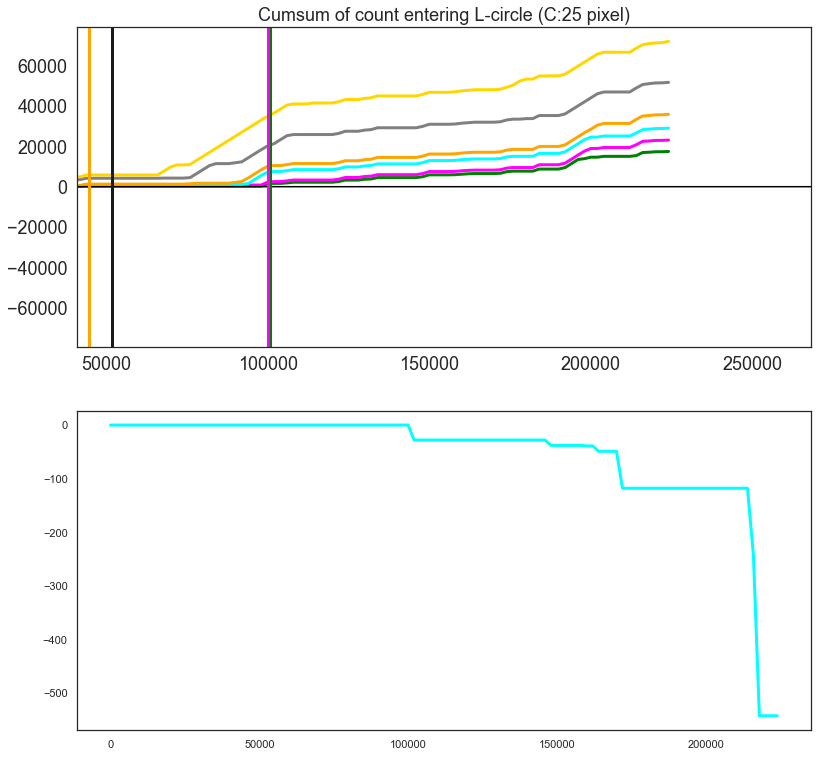

In [6]:
# eclosionの目視判定
eclo_time = {
            'w1118_1' : ['17:00:09', '19:53:18', '19:47:58', '21:24:47', '15:24:38', '19:39:20'],
            'w1118_2' : ['4:48:24', '20:1:57', '21:46:3', '5:17:2', '15:31:9','11:24:14'],
            'w1118_3' : ['2:17:11','2:30:46','21:0:15','20:18:22','14:50:57','2:35:20'],
            'OrR_1'   : ['3:17:17', '14:19:58', '11:32:9', '6:52:35', '11:29:47', '3:39:6'], 
            'OrR_2'   : ['11:19:30', '9:39:54', '10:2:29', '11:46:19', '9:49:48', '9:11:44'],
            'OrR_3'   : ['8:27:54','7:35:22','8:25:0','0:31:12','11:30:37','9:13:10'],
            'CS_1'    : ['12:9:6', '16:53:56', '14:16:44', '16:12:37', '13:11:6', '18:30:31'],
            'CS_2'    : ['16:11:28', '9:15:34', '0:0:0', '12:47:55', '13:42:40', '14:27:52'],
            'CS_3'    : ['12:5:21','12:44:23','6:41:34','11:26:11','11:6:31','8:3:1'],
            }


# 被接近対象の半径Xピクセル内に進入した回数をカウント
def count_entering(dl,dr,thre):
    ind1=np.where(dl<=thre)[0]
    ind2=np.where(dr<=thre)[0]
    x1=np.zeros(len(dl))
    x2=np.zeros(len(dl))
    x1[ind1]=1
    x2[ind2]=-1
    n1=len(ind1)
    n2=len(ind2)
    return x1,x2,n1,n2

# グラフの整形のためのもの
def set_fontsize(ax,fontsize):
    itemsx=ax.get_xticklabels()
    itemsy=ax.get_yticklabels()
    for i in range(len(itemsx)):
        itemsx[i].set_fontsize(fontsize)
    for i in range(len(itemsy)):
        itemsy[i].set_fontsize(fontsize)

for target in tqdm(targets):
    data_dir = datasets[target]
    
    file_path = os.path.join("{}/{}/csv".format(server_data, data_dir))
    file_path1 = os.path.join("{}/{}/csv".format(local_data, data_dir))
    fs_dis = np.loadtxt("{}/fs_disper.csv".format(file_path1), delimiter=",")
    
    with open(os.path.join(server_data, data_dir, 'mask_params.json')) as f:
        params = json.load(f)
    
    x = params['n-rows']
    y = params['n-clms']
    xlen = params['well-w']
    ylen = params['well-h']
    X = params['x']
    Y = params['y']

    mv_num = len(movies[target])
    #mv_num = 2
    
    wnum = x*y
    
    data_dir = datasets[target]
    tar_mv = movies[target][1]

    tar_path = os.path.join('{}/{}/{}.mp4'.format(server_data, data_dir, tar_mv))

    # 前景用動画読み込みの設定
    movie = cv2.VideoCapture(tar_path)

    # 動画ファイル保存用の設定
    fps = int(movie.get(cv2.CAP_PROP_FPS))                         # 動画のFPSを取得
    #fps=3
    eclo_frames=np.zeros(wnum)
    for eclo in range(len(eclo_time[target])):
        tmp=eclo_time[target][eclo]
        h,m,s=tmp.split(':')
        hs=np.int(h)*3600
        ms=np.int(m)*60
        ss=np.int(s)
        alls=hs+ms+ss
        eclo_frames[eclo]=alls*fps
    
    fs_dis = fs_dis.reshape(x*y, 2, 3)

    dl_mean=np.zeros(wnum)
    dl_std=np.zeros(wnum)
    dr_mean=np.zeros(wnum)
    dr_std=np.zeros(wnum)
    distances=pd.DataFrame()

    n1s=np.array([])
    n2s=np.array([])

    # グラフ描画の範囲指定    
    dt_pre=3600*1 # eclosionから前1時間分
    dt_post=3600*20 # eclosion後20時間分
    dframe_pre=dt_pre*fps
    dframe_post=dt_post*fps

    disp_short=1
    # ********************************************
    x = 1
    y = 1
    
    arr_all=np.array([])
    count_thres = [300,600,900]
    onset_frames = np.zeros((len(count_thres),wnum))
    onset_labels = np.zeros_like(onset_frames)
    ccc = 0
    for count_thre in tqdm(count_thres):
        cntr=0
        icntr=0
        for i in tqdm(range(y)): # for image placement
            arrs=np.array([])
            jcntr=0    
            for j in tqdm(range(x)): # for image placement
                fig = plt.figure(figsize=(20,20))
                if target == 'w1118_1':
                    G = np.loadtxt(os.path.join(file_path, 'dispersion3/well{:03}.csv'.format(cntr)), delimiter=",")
                else:
                    G = np.loadtxt(os.path.join(file_path1, 'dispersion/well{:03}.csv'.format(cntr)), delimiter=",")
                disp_range=[eclo_frames[cntr]-dframe_pre,eclo_frames[cntr]+dframe_post]
                if disp_short==1:
                    f1=np.int(disp_range[0])
                    f2=np.int(disp_range[1])
                else:
                    f1=0
                    f2=len(G)

                wellnum=str(cntr).zfill(2)
                #fname=h+wellnum+'.csv'
                #dat=pd.read_csv(fname,header=None)
                #data=pd.DataFrame(dat.values,columns=['y-coord','x-coord'])

                oy,ox=G.T
                lx=fs_dis[cntr,1,0]
                ly=fs_dis[cntr,0,0]
                rx=fs_dis[cntr,1,2]
                ry=fs_dis[cntr,0,2]

                #ox=grav['center_x'].values
                #oy=grav['center_y'].values

                dl=((ox-lx)**2+(oy-ly)**2)**0.5
                dr=((ox-rx)**2+(oy-ry)**2)**0.5

                if cntr==0:
                    dls=dl
                    drs=dr
                else:
                    dls=np.c_[dls,dl]
                    drs=np.c_[drs,dr]

                #dl=((dat.values[:,0]-target_loc[cntr,0])**2+(dat.values[:,1]-target_loc[cntr,1])**2)**0.5
                #dr=((dat.values[:,0]-target_loc[cntr,2])**2+(dat.values[:,1]-target_loc[cntr,3])**2)**0.5

                dl_mean[cntr]=np.mean(dl)
                dl_std[cntr]=np.std(dl)
                dr_mean[cntr]=np.mean(dr)
                dr_std[cntr]=np.std(dr)

                w=np.ones(dl.size)*cntr
                df=pd.DataFrame(np.c_[dl,dr,w],columns=['dl','dr','well'])
                distances=pd.concat([distances,df])

                bias=(dl-dr)/(dl+dr)
                bias=pd.Series(bias)
                #bias=bias.rolling(window=30).mean()

                maxt=len(ox)
                sns.set(style="white", color_codes=True)

                xs=range(len(ox))
                # ***** Visualization *****
                #sns.jointplot(x='x-coord', y='y-coord', data=data, kind='kde') #kind=kde,hex
                fontsize=18

                # 保存先がそのままだと画像が上書きされるので注意！! 下の fname も変更
                if 0: # 滞在の時間分布の図を描画したい場合ここを1に。
                    #ax=sns.jointplot(x=ox[::10],y=oy[::10],
                    #                 xlim=(10,210),ylim=(10,210),kind='kde')
                    #fig = plt.figure()
                    ax = fig.add_subplot(111)

                    H = ax.hist2d(ox[f1:f2],oy[f1:f2], 
                                  bins=[np.linspace(0,210,84),np.linspace(0,210,84)],
                                  normed=True)
                    #ax.set_xlabel('x')
                    #ax.set_ylabel('y')
                    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
                    cax = divider.append_axes('right', '5%', pad='3%')             
                    ax.axis("off")
                    H[3].set_clim(0,1e-4)
                    ax.set_aspect('equal')
                    fig.colorbar(H[3],cax=cax)
                    #cbar.set_label("color bar", fontname="Times New Roman", fontsize=10)

                    #plt.title('#Well:'+wellnum,fontsize=fontsize)


                else: # 以下は様々な統計を描画               
                    bias_thre=0.5 # Bias value

                    # *** row1 ***
                    thres=[15,20,25,30,35,40]
                    if cntr==0:
                        onset_frames1=np.zeros((wnum,len(thres)))
                        onset_frames2=np.zeros((wnum,len(thres)))
                    xxl=np.zeros((len(thres),len(dl[f1:f2])))
                    xxr=np.zeros((len(thres),len(dr[f1:f2])))
                    nn1=np.zeros(len(thres))
                    nn2=np.zeros(len(thres))
                    for ii in range(len(thres)):
                        xxl[ii,:],xxr[ii,:],nn1[ii],nn2[ii]=count_entering(dl[f1:f2],dr[f1:f2],thres[ii])
                    if cntr==0:
                        n1s=nn1
                        n2s=nn2

                    else:
                        n1s=np.c_[n1s,nn1]
                        n2s=np.c_[n2s,nn2]

                    cs=['green','magenta','cyan','orange','gray','gold']
                    ax=plt.subplot2grid((3,6),(0,0),colspan=4)
                    #count_thre = 900
                    if 0:
                        for ii in range(len(thres)):
                            d1=np.cumsum(xxl[ii])
                            #d2=np.cumsum(xxr[ii])
                            lp=plt.plot(xs, d1, color=cs[ii],linewidth=3)
                            enter_count_thre=count_thre*fps
                            ind=np.where(d1>enter_count_thre)[0]
                            if len(ind)==0:
                                onset_frames1[cntr,ii]=0
                            else:
                                onset_frames1[cntr,ii]=ind[0]
                    else:
                        tmpmax=np.zeros_like(thres)
                        for ii in range(len(thres)):
                            d1=np.cumsum(xxl[ii])

                            ind_l=np.where(xxl[ii]==+1)[0]
                            #ind_r=np.where(xxr[ii]==-1)[0]

                            lv,b=np.histogram(ind_l,bins=range(0,f2-f1,2000))
                            #plt.plot(b[:-1],lv,linewidth=3,color=cs[ii])
                            #rv,b=np.histogram(ind_r,bins=range(0,f2-f1,2000))
                            #plt.plot(b[:-1],-rv,linewidth=3,color=cs[ii])
                            #plt.plot(b[:-1],-rv+lv,linewidth=3,color=cs[ii])
                            tmpmax[ii]=np.max(np.abs(lv))

                            plotdata=np.cumsum(lv)
                            plt.plot(b[:-1],np.cumsum(lv),linewidth=3,color=cs[ii])
                            tmpmax[ii]=np.max(np.abs(plotdata))


                            enter_count_thre=count_thre*fps
                            ind=np.where(d1>enter_count_thre)[0]
                            if len(ind)==0:
                                onset_frames1[cntr,ii]=0
                            else:
                                onset_frames1[cntr,ii]=ind[0]

                    #ymax=np.max(np.abs(np.cumsum(xx[-1])))
                    ymax=np.max(tmpmax)
                    plt.plot(xs, np.zeros(len(xs)), color='black')
                    plt.ylim([-ymax*1.1,ymax*1.1])
                    for ii in range(len(thres)):        
                        plt.plot([onset_frames1[cntr,ii],onset_frames1[cntr,ii]],
                                 [-ymax*1.1,ymax*1.1],color=cs[ii],linewidth=3)

                    plt.plot([eclo_frames[cntr],eclo_frames[cntr]],[-ymax*1.1,ymax*1.1],
                            color='k',linewidth=3)
                    plt.xlim((-1,maxt+1))
                    #plt.title('Cumsum of count entering L-circle (G:15,M:20,C:25,O:30,Gr:35,Go:40 pixel)',fontsize=fontsize)
                    plt.title('Cumsum of count entering L-circle (C:25 pixel)',
                              fontsize=fontsize)
                    set_fontsize(ax,fontsize)
                    if disp_short==1:
                        plt.xlim(disp_range)

                    # *** row2 ***
                    #cs=['green','magenta','cyan','orange','gray','gold']
                    cs=['cyan']
                    ax=plt.subplot2grid((3,6),(1,0),colspan=4)
                    if 0:
                        for ii in range(len(thres)):
                            d2=np.cumsum(xxr[ii])
                            lp=plt.plot(xs, d2, color=cs[ii],linewidth=3)
                            enter_count_thre2=-(count_thre*fps)
                            ind=np.where(d2<enter_count_thre2)[0]
                            if len(ind)==0:
                                onset_frames2[cntr,ii]=0
                            else:
                                onset_frames2[cntr,ii]=ind[0]
                    else:
                        tmpmax=np.zeros_like(thres)
                        for ii in range(len(thres)):
                            d2=np.cumsum(xxr[ii])
                            ind_r=np.where(xxr[ii]==-1)[0]

                            #lv,b=np.histogram(ind_l,bins=range(0,f2-f1,2000))
                            #plt.plot(b[:-1],lv,linewidth=3,color=cs[ii])
                            rv,b=np.histogram(ind_r,bins=range(0,f2-f1,2000))
                            #plt.plot(b[:-1],-rv,linewidth=3,color=cs[ii])
                            #plt.plot(b[:-1],-rv+lv,linewidth=3,color=cs[ii])
                            tmpmax[ii]=np.max(np.abs(rv))

                            plotdata=np.cumsum(-rv)
                            plt.plot(b[:-1],np.cumsum(-rv),linewidth=3,color=cs[ii])
                            tmpmax[ii]=np.max(np.abs(plotdata))


                            enter_count_thre2=-(count_thre*fps)
                            ind=np.where(d2<enter_count_thre2)[0]
                            if len(ind)==0:
                                onset_frames2[cntr,ii]=0
                            else:
                                onset_frames2[cntr,ii]=ind[0]

                    #ymax=np.max(np.abs(np.cumsum(xx[-1])))
                    ymax=np.max(tmpmax)
                    plt.plot(xs, np.zeros(len(xs)), color='black')
                    plt.ylim([-ymax*1.1,ymax*1.1])
                    for ii in range(len(thres)):        
                        plt.plot([onset_frames2[cntr,ii],onset_frames2[cntr,ii]],
                                 [-ymax*1.1,ymax*1.1],color=cs[ii],linewidth=3)

                    plt.plot([eclo_frames[cntr],eclo_frames[cntr]],[-ymax*1.1,ymax*1.1],
                            color='k',linewidth=3)
                    plt.xlim((-1,maxt+1))
                    plt.title('Cumsum of count entering R-circle (C:25 pixel)',
                              fontsize=fontsize)
                    set_fontsize(ax,fontsize)
                    if disp_short==1:
                        plt.xlim(disp_range)



                    yl=np.max([np.max(nn1),np.max(nn2)])*1.1
                    for ii in range(len(thres)):
                        ax=plt.subplot2grid((3,9),(2,0+ii))
                        plt.bar([0,1],[nn1[ii],nn2[ii]],color=cs[ii])
                        set_fontsize(ax,fontsize)
                        ax.set_xticks([0,1])
                        ax.set_xticklabels(['L','R'],fontsize=fontsize)
                        ax.set_ylim([0,yl])


                #sys.exit()
                # *************************
                
                if onset_frames1[cntr,2] > onset_frames2[cntr,2]:
                    onset_frames[ccc,cntr] = onset_frames2[cntr,2]
                    onset_labels[ccc,cntr] = -1
                else:
                    onset_frames[ccc,cntr] = onset_frames1[cntr,2]
                    onset_labels[ccc,cntr] = 1

                # 滞在分布を出力する時はここも１に
                if 0:
                    fname = os.path.join(local_data,data_dir,'img2')
                else:
                    fname = os.path.join(local_data,data_dir,'th2_img10/th{:03}'.format(count_thre))
                os.makedirs(fname, exist_ok=True)
                imfname = fname+'/well{}.png'.format(wellnum)
                plt.savefig(imfname)
                arr=np.array(Image.open(imfname))
                if jcntr==0: arrs=arr
                else: arrs=np.hstack((arrs,arr))
                jcntr+=1

                plt.suptitle('#Well:'+wellnum,verticalalignment='bottom',fontsize=20)        

                #plt.tight_layout()
                #plt.show()

                cntr+=1
            if icntr==0: arr_all=arrs
            else: arr_all=np.vstack((arr_all,arrs))
            icntr+=1

        pil_img = Image.fromarray(arr_all)
        pil_img.save(os.path.join(fname,'img-summary.png'))
        ccc+=1
    
#plt.figure(figsize=(15, 15))
#ax = sns.violinplot(x=distances['well'], y=pkmn["dr"], split=True) 

print('done.')

In [9]:
b[:-1].shape

(113,)

In [11]:
np.cumsum(-rv).shape

(113,)

In [309]:
onset_frames

array([[ 85921., 228906., 315047.,  67583., 210905., 191842.],
       [137364., 229806., 315947.,  68549., 211805., 192742.],
       [138264., 230706., 316847.,  80940., 228990., 193642.]])

In [304]:
onset_labels

array([[ 1., -1.,  1.,  1.,  1.,  1.],
       [ 1., -1.,  1.,  1.,  1.,  1.],
       [ 1., -1.,  1.,  1.,  1.,  1.]])

In [287]:
eclo_frames

array([174864., 100002.,      0., 138225., 148080., 156216.])

In [271]:
DIS1 = np.zeros((6,2))

for i in range(6):
    DIS1[i][0] = np.linalg.norm(fs_dis[i,:,0] - fs_dis[i,:,1])
    DIS1[i][1] = np.linalg.norm(fs_dis[i,:,2] - fs_dis[i,:,1])
    
print( DIS1 )

[[53.63572668 47.05096085]
 [49.94127813 50.99021631]
 [50.13774755 53.47706022]
 [49.33898754 51.4141082 ]
 [52.81738227 47.68856854]
 [52.14812292 55.10356101]]


In [252]:
DIS = np.zeros((6))

for i in range(6):
    DIS[i] = np.linalg.norm(fs_dis[i,:,0] - fs_dis[i,:,2])
    #DIS[i][1] = np.linalg.norm(fs_dis[i,:,2] - fs_dis[i,:,1])
    
print( DIS )

[100.54342669 100.9305621  103.60433044 100.21716454 100.3524119
 107.18674589]


In [281]:
dl

array([49.94127813, 49.94127813, 49.94127813, ..., 69.26252473,
       69.26252473, 69.26252473])

In [282]:
ind1s.shape

(38751,)

In [189]:
time_diff = onset_frames[:,2] - eclo_frames

In [190]:
time_diff

array([-203850.,   21369.,  209685.,  165859.,  176186., -165520.])

In [154]:
time_diff / fps / 3600

array([-16.19111111,   1.94509259,   0.        ,   9.63814815,
        16.0187963 ,   5.82259259])

In [367]:
tdiffs = []
ahos = []
ahs = []
for j in range(3):
    time_diff = onset_frames[j] - eclo_frames
    tdiff = time_diff / fps / 3600
    aho = []
    for i in range(6):
        if tdiff[i] > 0:
            hour_ = math.floor(tdiff[i])
            min_ = math.floor((tdiff[i]-hour_)*60)
            sec_ = math.floor((((tdiff[i]-hour_)*60-min_))*60)
            time_ = str(hour_) + ':' + str(min_) + ':' + str(sec_)
            aho.append(time_)

        else:
            time_diff[i] = 0
            aho.append('0:0:0')

    tdiffs.append(time_diff)
    ahos.append(aho)
    ahs.append(tdiff)
    
print(tdiffs)
print(ahos)
print(ahs)

[array([ 29100.,  12068.,      0.,   3510., 119303.,  47109.]), array([ 30000.,  20060.,      0.,  12745., 173001.,  62810.]), array([ 30901.,  20961.,      0.,  13873., 193649.,  71924.])]
[['2:41:40', '1:7:2', '0:0:0', '0:19:30', '11:2:47', '4:21:42'], ['2:46:39', '1:51:26', '0:0:0', '1:10:48', '16:1:6', '5:48:56'], ['2:51:40', '1:56:27', '0:0:0', '1:17:4', '17:55:49', '6:39:34']]
[array([ 2.69444444,  1.11740741,  0.        ,  0.325     , 11.04657407,
        4.36194444]), array([ 2.77777778,  1.85740741,  0.        ,  1.18009259, 16.01861111,
        5.81574074]), array([ 2.8612037 ,  1.94083333,  0.        ,  1.28453704, 17.93046296,
        6.65962963])]


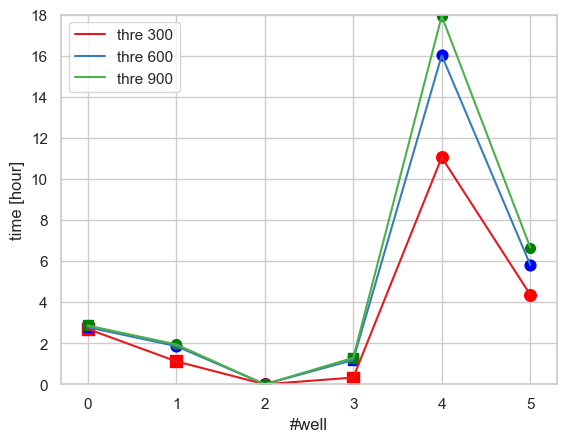

In [374]:
plt.style.use('default')
sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set1')

x = np.array([0,1,2,3,4,5])

df = pd.DataFrame({
    'x': x, 'thre300': ahs[0], 'thre600': ahs[1], 'thre900': ahs[2]
})

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
'''
ax.plot('x', 'thre300', data=df, label='thre 300', marker='o')
ax.plot('x', 'thre600', data=df, label='thre 600', marker='x')
ax.plot('x', 'thre900', data=df, label='thre 900', marker='^')
'''
ax.plot('x', 'thre300', data=df, label='thre 300')
ax.plot('x', 'thre600', data=df, label='thre 600')
ax.plot('x', 'thre900', data=df, label='thre 900')

ymax = 12

for i in range(len(ahs)):
    for j in range(len(ahs[i])):
        if i==0:
            if onset_labels[i][j]==1:
                ax.scatter(x=j, y=ahs[i][j], s=70, c='red', marker='o')
            else:
                ax.scatter(x=j, y=ahs[i][j], s=70, c='red', marker=',')
        elif i==1:
            if onset_labels[i][j]==1:
                ax.scatter(x=j, y=ahs[i][j], s=60, c='blue', marker='o')
            else:
                ax.scatter(x=j, y=ahs[i][j], s=60, c='blue', marker=',')
        elif i==2:
            if onset_labels[i][j]==1:
                ax.scatter(x=j, y=ahs[i][j], s=50, c='green', marker='o')
            else:
                ax.scatter(x=j, y=ahs[i][j], s=50, c='green', marker=',')
    
    array_max = max(ahs[i])
    if array_max > ymax:
        ymax = round(array_max)
            
ax.legend()
ax.set_xlabel("#well")
ax.set_ylabel("time [hour]")
ax.set_ylim(0, ymax)

fname = os.path.join(local_data,data_dir,'th2_img5')
os.makedirs(fname, exist_ok=True)
imfname = fname+'/graph.png'.format()
plt.savefig(imfname)

plt.show()

In [372]:
ahs

[array([ 2.69444444,  1.11740741,  0.        ,  0.325     , 11.04657407,
         4.36194444]),
 array([ 2.77777778,  1.85740741,  0.        ,  1.18009259, 16.01861111,
         5.81574074]),
 array([ 2.8612037 ,  1.94083333,  0.        ,  1.28453704, 17.93046296,
         6.65962963])]

In [373]:
max(ahs[0])

11.046574074074073